In [1]:
!pip install ptflops

In [2]:
# Import required libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import kagglehub
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset, Dataset

import torch.nn.utils.prune as prune
import copy
import math
import time
import timm
from torchvision.models import mobilenet_v3_large
from ptflops import get_model_complexity_info

import warnings
warnings.filterwarnings("ignore")

# Set seeds for reproducibility
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
os.environ["PYTHONHASHSEED"] = str(SEED)

/ephemeral/home/salhosani/anaconda3/envs/tf215/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Check for available device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
def load_dataset_filepaths():
    print("Downloading and preparing dataset")
    path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")
    dataset_dir = Path(path)

    # Handle nested folder
    first_level_folder = dataset_dir / "New Plant Diseases Dataset(Augmented)"
    second_level_folder = first_level_folder / "New Plant Diseases Dataset(Augmented)"

    train_dir = second_level_folder / "train"
    val_dir = second_level_folder / "valid"

    # Initialize containers
    filenames_train, label_train = [], []
    filenames_val, label_val = [], []

    # Load train data
    for fold in os.listdir(train_dir):
        FoldPath = train_dir / fold
        if FoldPath.is_dir():
            for file in os.listdir(FoldPath):
                filenames_train.append(str(FoldPath / file))
                label_train.append(fold)

    # Load val data
    for fold in os.listdir(val_dir):
        FoldPath = val_dir / fold
        if FoldPath.is_dir():
            for file in os.listdir(FoldPath):
                filenames_val.append(str(FoldPath / file))
                label_val.append(fold)

    classes = sorted(set(label_train))
    NUM_CLASSES = len(classes)

    print(f"Total training images: {len(filenames_train)}")
    print(f"Total validation images: {len(filenames_val)}")
    print(f"Number of classes: {NUM_CLASSES}")
    print(f"Class names: {classes[:5]}...")

    return filenames_train, label_train, filenames_val, label_val, NUM_CLASSES, classes

# Call the function
filenames_train, label_train, filenames_val, label_val, NUM_CLASSES, class_names = load_dataset_filepaths()


Total training images: 70295
Total validation images: 17572
Number of classes: 38
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']...


In [5]:
# Federated Learning Configuration
NUM_CLIENTS = 5
EPOCHS = 5  # Local epochs per client
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SHARDS_PER_CLIENT = 2
NUM_ROUNDS = 10 # Number of federated rounds
LR = 1e-4

print("Federated Learning Configuration")
print(f"Number of Clients: {NUM_CLIENTS}")
print(f"Number of Federated Rounds: {NUM_ROUNDS}")
print(f"Local Training Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Image Size: {IMG_SIZE}")
print(f"Learning Rate: {LR}")

Federated Learning Configuration
Number of Clients: 5
Number of Federated Rounds: 10
Local Training Epochs: 5
Batch Size: 32
Image Size: (224, 224)
Learning Rate: 0.0001


In [6]:
# Define image transformations
train_transform = transforms.ToTensor()
val_transform = transforms.ToTensor()

# Define custom dataset
class CustomPlantDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.label_to_idx = {label: idx for idx, label in enumerate(sorted(set(labels)))}
        self.encoded_labels = [self.label_to_idx[label] for label in labels]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = self.encoded_labels[idx]
        return img, label

# Load datasets
print("Loading datasets")
try:
    # Use the lists returned from Code Box 1
    train_dataset = CustomPlantDataset(filenames_train, label_train, transform=train_transform)
    print(f"Training dataset loaded with {len(train_dataset)} images")

    val_dataset = CustomPlantDataset(filenames_val, label_val, transform=val_transform)
    print(f"Validation dataset loaded with {len(val_dataset)} images")

    # Create validation data loader
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

except Exception as e:
    print(f"Error loading datasets: {e}")
    raise


Loading datasets
Training dataset loaded with 70295 images
Validation dataset loaded with 17572 images


Analyzing class distribution of training data


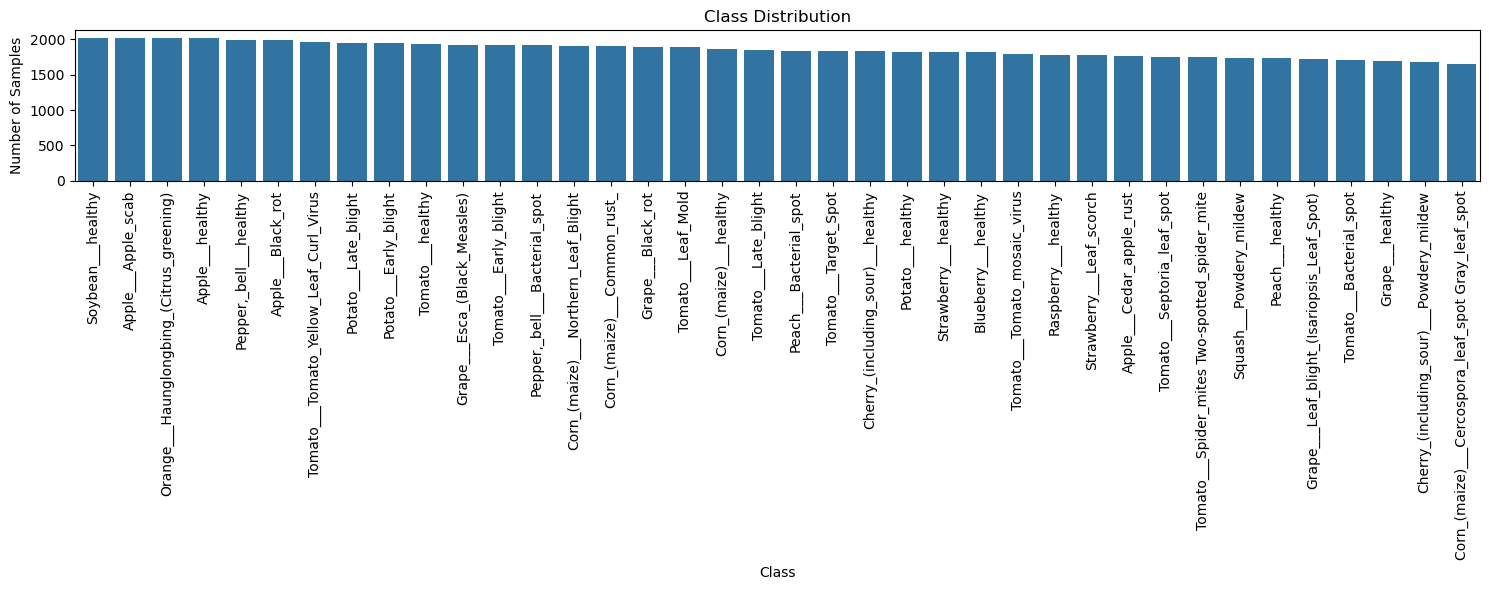

Class statistics:
Min: 1642, Max: 2022, Mean: 1849.87, Std: 104.32


In [7]:
def analyze_class_distribution(dataset):
    """Plot class distribution of CustomPlantDataset"""
    if hasattr(dataset, 'encoded_labels') and hasattr(dataset, 'label_to_idx'):
        targets = dataset.encoded_labels
        label_map = dataset.label_to_idx
        class_labels = [None] * len(label_map)
        for label, idx in label_map.items():
            class_labels[idx] = label
    else:
        print("This function only works with CustomPlantDataset.")
        return

    # Count occurrences
    class_counts = np.bincount(targets)

    # Create DataFrame for plotting
    df = pd.DataFrame({
        'Class': class_labels,
        'Count': class_counts
    })

    # Sort for better visualization
    df = df.sort_values('Count', ascending=False).reset_index(drop=True)

    # Plot
    plt.figure(figsize=(15, 6))
    sns.barplot(x='Class', y='Count', data=df)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # Stats
    print(f"Class statistics:")
    print(f"Min: {class_counts.min()}, Max: {class_counts.max()}, Mean: {class_counts.mean():.2f}, Std: {class_counts.std():.2f}")
    return df

# Call it
print("Analyzing class distribution of training data")
class_distribution = analyze_class_distribution(train_dataset)


In [8]:
def create_non_iid_shards(dataset, num_clients, shards_per_client):
    """Create non-IID distribution using the shard approach"""
    print("Creating Non-IID data distribution with shards")

    # Get all indices and labels
    indices = list(range(len(dataset)))

    # For CustomPlantDataset
    if hasattr(dataset, 'encoded_labels'):
        labels = dataset.encoded_labels
    else:
        raise ValueError("Dataset must have 'encoded_labels'")

    # Sort indices by label
    indices_labels = list(zip(indices, labels))
    indices_labels.sort(key=lambda x: x[1])
    sorted_indices = [i for i, _ in indices_labels]

    # Total number of shards
    num_shards = num_clients * shards_per_client
    shard_size = len(dataset) // num_shards

    # Create shards
    shards = [sorted_indices[i * shard_size:(i + 1) * shard_size] for i in range(num_shards)]

    # Assign shards to clients
    client_indices = [[] for _ in range(num_clients)]
    shard_ids = list(range(num_shards))
    random.shuffle(shard_ids)

    for i in range(num_clients):
        assigned_shards = shard_ids[i * shards_per_client:(i + 1) * shards_per_client]
        for sid in assigned_shards:
            client_indices[i].extend(shards[sid])
        print(f"Client {i+1} assigned {len(client_indices[i])} samples")

    return client_indices

# Usage
client_indices = create_non_iid_shards(train_dataset, NUM_CLIENTS, SHARDS_PER_CLIENT)


Creating Non-IID data distribution with shards
Client 1 assigned 14058 samples
Client 2 assigned 14058 samples
Client 3 assigned 14058 samples
Client 4 assigned 14058 samples
Client 5 assigned 14058 samples


In [9]:
# Define the function
def visualize_client_distributions(dataset, client_indices):
    """Visualize class distribution for each client (CustomPlantDataset-compatible)"""
    print("Visualizing class distribution for each client")

    if hasattr(dataset, 'label_to_idx'):
        idx_to_label = {v: k for k, v in dataset.label_to_idx.items()}
        class_names = [idx_to_label[i] for i in range(len(idx_to_label))]
    else:
        class_names = [f"Class {i}" for i in range(NUM_CLASSES)]

    for i, indices in enumerate(client_indices):
        if hasattr(dataset, 'encoded_labels'):
            client_labels = [dataset.encoded_labels[idx] for idx in indices]
        else:
            print(f"Cannot determine labels for client {i+1}")
            continue

        # Count class occurrences
        class_counts = np.zeros(NUM_CLASSES, dtype=int)
        for label in client_labels:
            class_counts[label] += 1

        df = pd.DataFrame({
            'Class': class_names,
            'Count': class_counts
        })

        df = df[df['Count'] > 0].sort_values('Count', ascending=False).reset_index(drop=True)

        plt.figure(figsize=(12, 5))
        sns.barplot(x='Class', y='Count', data=df)
        plt.title(f'Client {i+1} Class Distribution')
        plt.xlabel('Class')
        plt.ylabel('Number of Samples')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

        print(f"Client {i+1} has {len(np.nonzero(class_counts)[0])} unique classes out of {NUM_CLASSES}")


Visualizing class distribution for each client


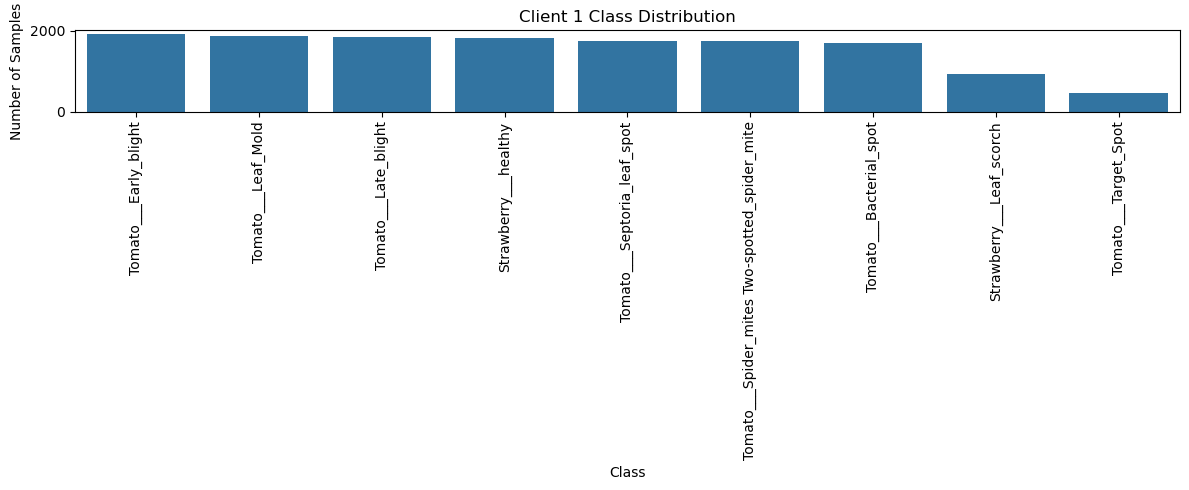

Client 1 has 9 unique classes out of 38


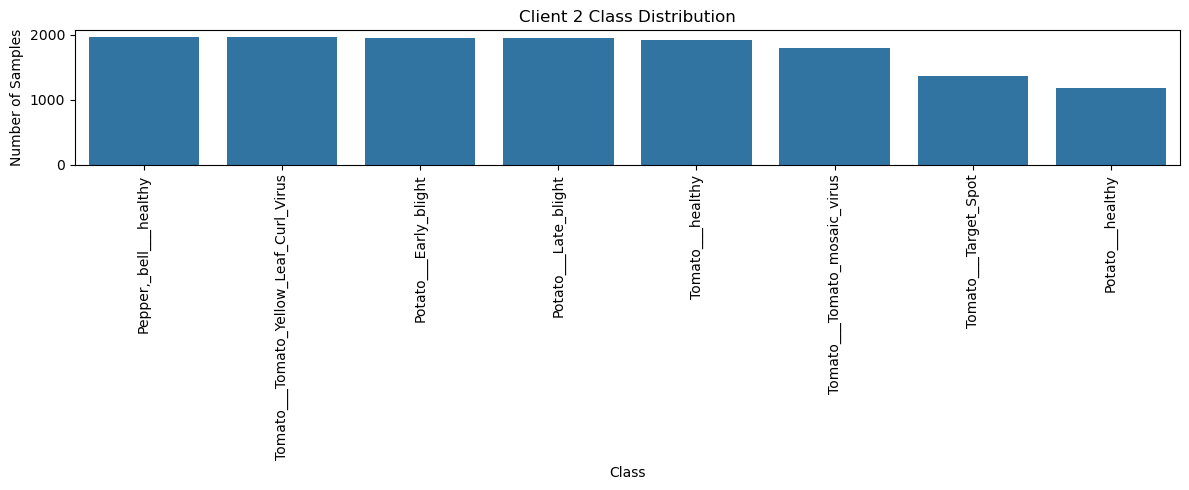

Client 2 has 8 unique classes out of 38


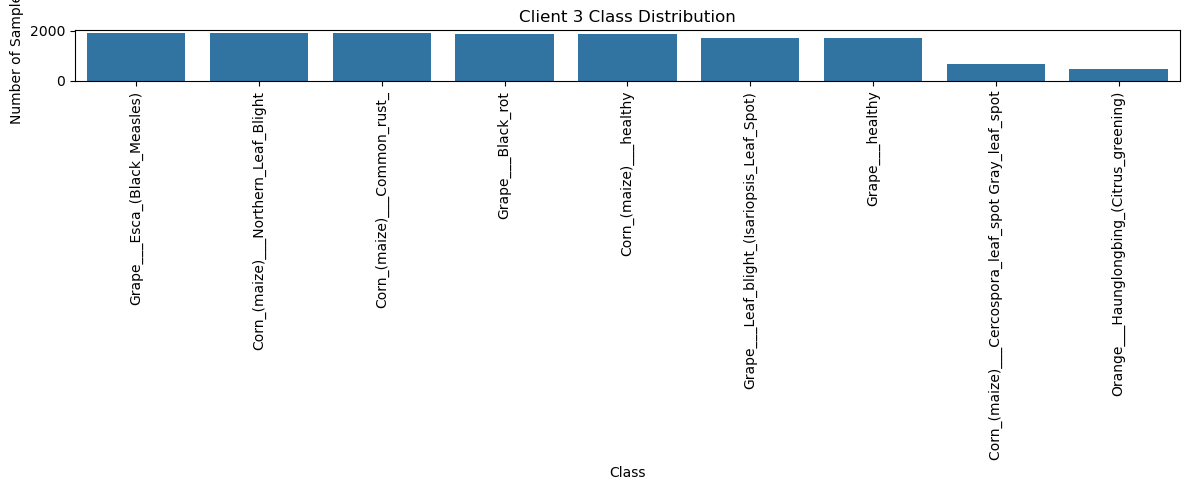

Client 3 has 9 unique classes out of 38


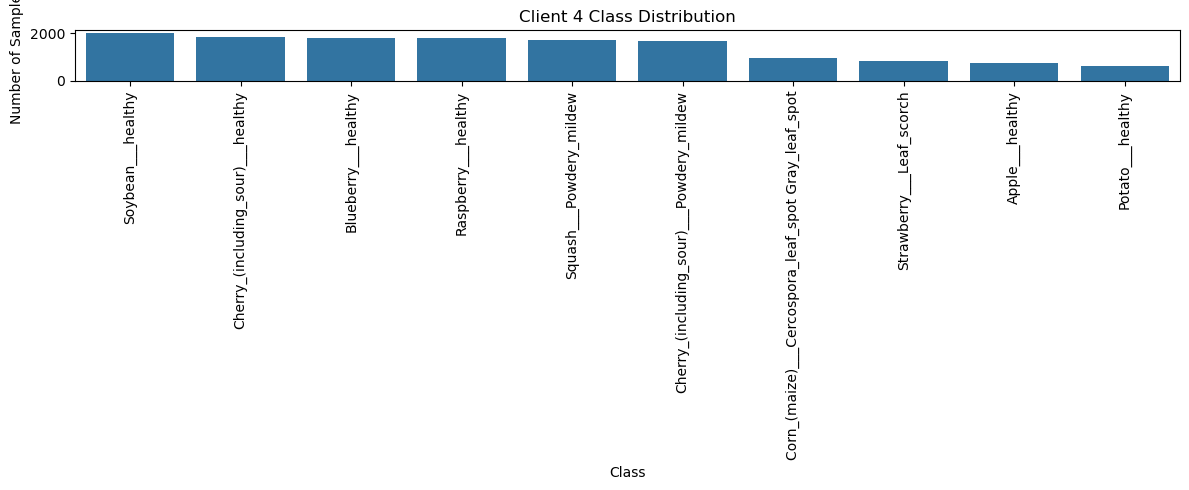

Client 4 has 10 unique classes out of 38


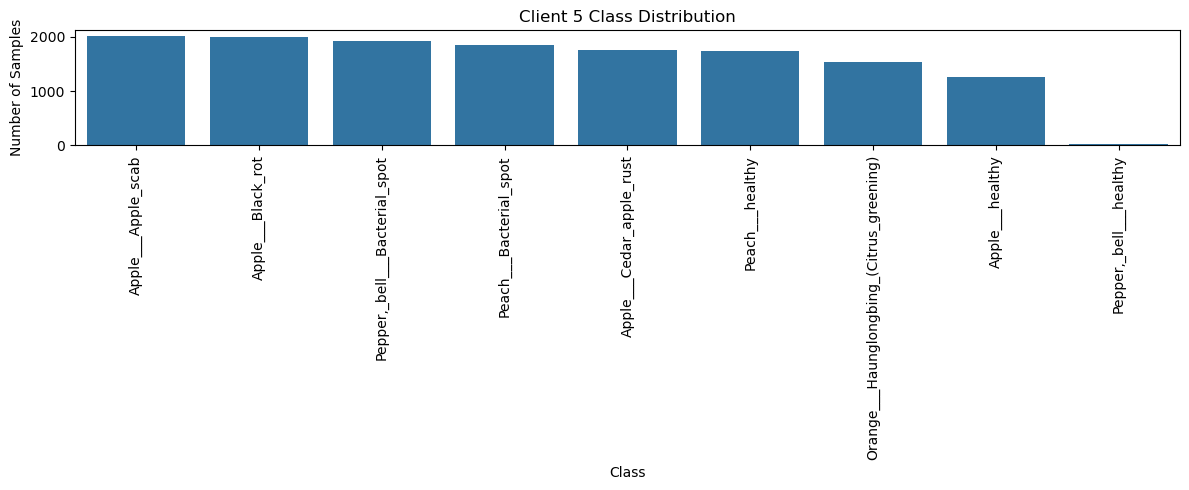

Client 5 has 9 unique classes out of 38


In [10]:
visualize_client_distributions(train_dataset, client_indices)


In [11]:
# Create DataLoaders for each client
client_dataloaders = [
    DataLoader(
        Subset(train_dataset, indices),
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    for indices in client_indices
]

In [12]:
# Client training function
def train_client_model(model, dataloader, epochs, client_id, lr=LR):
    """Train a client model for specified number of epochs"""
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    criterion = nn.CrossEntropyLoss()

    # For storing metrics
    history = {
        'train_loss': [],
        'train_acc': []
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader),
                           desc=f"Client {client_id+1}, Epoch {epoch+1}/{epochs}")

        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Track metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            progress_bar.set_postfix({
                'loss': running_loss / (i + 1),
                'acc': 100. * correct / total
            })

        # Calculate epoch metrics
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = 100. * correct / total

        # Log metrics
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        # Update learning rate
        scheduler.step(epoch_loss)

        print(f"Client {client_id+1}, Epoch {epoch+1}/{epochs}: Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%")

    return model.state_dict(), history

In [13]:
# Evaluation function
def evaluate_model(model, dataloader):
    """Evaluate model on the given dataloader"""
    model.eval()
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = 100. * correct / total
    avg_loss = running_loss / len(dataloader)

    return {
        'accuracy': acc,
        'loss': avg_loss,
        'predictions': all_preds,
        'labels': all_labels
    }

In [14]:
# Memory management
def clear_memory():
    """Clear GPU memory"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    import gc
    gc.collect()


## MobileNetV3 Model

In [15]:
# MobileNetV3 Configuration
MOBILENET_BATCH_SIZE = 32
MOBILENET_EPOCHS = 5
MOBILENET_PRUNING_AMOUNT = 0.5  # 50% pruning
MOBILENET_IMG_SIZE = (224, 224)
MOBILENET_LR = 1e-4

# Function to create and prepare MobileNetV3 model
def create_mobilenetv3_model(num_classes=NUM_CLASSES):
    print("Creating MobileNetV3-Large-100 model...")
    model = timm.create_model('mobilenetv3_large_100', pretrained=True, num_classes=num_classes)
    for name, param in model.named_parameters():
        # Lower learning rate for base layers
        if 'classifier' not in name:
            param.requires_grad = True  # Keep everything trainable

    # Make sure classifier is correctly initialized
    if hasattr(model, 'classifier'):
        # Reset the classifier with proper initialization
        in_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    return model

# Function to print model parameters and complexity
def print_model_stats(model, name="Model", input_size=(3, 224, 224)):
    """Print model parameters and complexity"""
    print(f"\{name} Statistics")

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Calculate sparsity
    total_weights = 0
    zero_weights = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            total_weights += param.numel()
            zero_weights += (param == 0).sum().item()

    if total_weights > 0:
        sparsity = 100.0 * zero_weights / total_weights
        print(f"Global sparsity: {sparsity:.2f}%")
        print(f"Zero parameters: {zero_weights:,} / {total_weights:,}")

    # Calculate GFLOPs
    try:
        macs, params = get_model_complexity_info(
            model, input_size, as_strings=True, print_per_layer_stat=False, verbose=False
        )
        print(f"Computational complexity: {macs}")
        print(f"Number of parameters: {params}")
    except Exception as e:
        print(f"Could not calculate GFLOPs: {e}")

    return {
        'total_params': total_params,
        'trainable_params': trainable_params,
        'zero_params': zero_weights,
        'total_weights': total_weights,
        'sparsity': sparsity if total_weights > 0 else 0
    }

## Federated Learning

In [16]:
# Federated averaging function
def federated_averaging(state_dicts, client_weights=None):
    """Average model weights from multiple clients"""
    if client_weights is None:
        # Equal weighting
        client_weights = [1/len(state_dicts)] * len(state_dicts)
    else:
        # Normalize weights
        total_weight = sum(client_weights)
        client_weights = [w/total_weight for w in client_weights]

    print(f"Client weights for averaging: {client_weights}")

    avg_state = {}
    for key in state_dicts[0].keys():
        # Skip running mean and var in batch norm layers
        if 'running_mean' in key or 'running_var' in key:
            # For batch norm stats, use the first client's values
            avg_state[key] = state_dicts[0][key]
        else:
            # Weighted average for other parameters
            avg_state[key] = sum(w * state[key] for state, w in zip(state_dicts, client_weights))

    return avg_state

In [17]:
# Federated Learning with MobileNetV3
def run_federated_learning_mobilenetv3():
    """Run federated learning with MobileNetV3"""
    print(" Starting Federated Learning with MobileNetV3")

    # Initialize global model
    global_model = create_mobilenetv3_model(NUM_CLASSES)
    global_model = global_model.to(device)

    # Print initial model statistics
    initial_stats = print_model_stats(global_model, "Initial MobileNetV3")

    # For tracking metrics
    global_metrics = {
        'round_val_accuracy': [],
        'round_val_loss': [],
        'client_train_losses': [[] for _ in range(NUM_CLIENTS)],
        'client_train_accuracies': [[] for _ in range(NUM_CLIENTS)],
        'model_sparsity': [initial_stats['sparsity']]
    }

    # Run multiple federated rounds
    for round_idx in range(NUM_ROUNDS):
        print(f" Communication Round {round_idx + 1}/{NUM_ROUNDS}")

        # Initialize list for client weights and metrics
        client_weights = []
        client_sample_counts = []
        client_histories = []

        # Train each client model
        for client_id in range(NUM_CLIENTS):
            print(f" Training Client {client_id + 1}/{NUM_CLIENTS}")

            # Create client model and load global model weights
            client_model = create_mobilenetv3_model(NUM_CLASSES)
            client_model.load_state_dict(global_model.state_dict())

            # Get number of samples for this client
            client_samples = len(client_indices[client_id])
            client_sample_counts.append(client_samples)

            # Train client model
            client_state_dict, client_history = train_client_model(
                client_model,
                client_dataloaders[client_id],
                epochs=MOBILENET_EPOCHS,
                client_id=client_id,
                lr=MOBILENET_LR
            )

            # Save client weights and history
            client_weights.append(client_state_dict)
            client_histories.append(client_history)

            # Update global metrics
            global_metrics['client_train_losses'][client_id].extend(client_history['train_loss'])
            global_metrics['client_train_accuracies'][client_id].extend(client_history['train_acc'])

            # Clear memory
            del client_model
            clear_memory()

        # Federated Averaging
        global_model.load_state_dict(federated_averaging(client_weights, client_sample_counts))

        # Get model statistics after this round
        round_stats = print_model_stats(global_model, f"MobileNetV3 Round {round_idx + 1}")
        global_metrics['model_sparsity'].append(round_stats['sparsity'])

        # Evaluate global model on validation set
        print("Evaluating Global Model on Validation Set")
        val_results = evaluate_model(global_model, val_loader)
        global_metrics['round_val_accuracy'].append(val_results['accuracy'])
        global_metrics['round_val_loss'].append(val_results['loss'])
        print(f"Round {round_idx + 1} - Validation Accuracy: {val_results['accuracy']:.2f}%")
        print(f"Round {round_idx + 1} - Validation Loss: {val_results['loss']:.4f}")

    # Save the federated model
    torch.save(global_model.state_dict(), 'federated_mobilenetv3_plant_disease_model.pth')
    print("Federated model saved as 'federated_mobilenetv3_plant_disease_model.pth'")

    # Plot accuracy over rounds
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, NUM_ROUNDS + 1), global_metrics['round_val_accuracy'], marker='o')
    plt.title('MobileNetV3 Global Model Validation Accuracy per Round')
    plt.xlabel('Communication Round')
    plt.ylabel('Validation Accuracy (%)')
    plt.grid(True)
    plt.show()

    return global_model, global_metrics


EXPERIMENT 1: FEDERATED LEARNING WITH MOBILENETV3
 Starting Federated Learning with MobileNetV3
Creating MobileNetV3-Large-100 model...
\Initial MobileNetV3 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 0.00%
Zero parameters: 0 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
 Communication Round 1/10
 Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5:  26%|██▌       | 115/440 [00:04<00:11, 27.87it/s, loss=1.39, acc=69.3]

Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:17<00:00, 24.67it/s, loss=0.456, acc=89.1]

Client 1, Epoch 1/5: Loss: 0.4560, Acc: 89.05%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:16<00:00, 26.10it/s, loss=0.0276, acc=99.1]

Client 1, Epoch 2/5: Loss: 0.0276, Acc: 99.13%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:16<00:00, 26.58it/s, loss=0.0149, acc=99.5]

Client 1, Epoch 3/5: Loss: 0.0149, Acc: 99.51%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:16<00:00, 27.22it/s, loss=0.0116, acc=99.6]

Client 1, Epoch 4/5: Loss: 0.0116, Acc: 99.62%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:16<00:00, 25.91it/s, loss=0.00936, acc=99.6]


Client 1, Epoch 5/5: Loss: 0.0094, Acc: 99.64%
 Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:16<00:00, 26.56it/s, loss=0.313, acc=94.2]

Client 2, Epoch 1/5: Loss: 0.3134, Acc: 94.24%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 24.31it/s, loss=0.00946, acc=99.7]

Client 2, Epoch 2/5: Loss: 0.0095, Acc: 99.70%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:16<00:00, 27.35it/s, loss=0.00823, acc=99.8]

Client 2, Epoch 3/5: Loss: 0.0082, Acc: 99.75%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:16<00:00, 26.91it/s, loss=0.00484, acc=99.9]


Client 2, Epoch 4/5: Loss: 0.0048, Acc: 99.86%


Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:16<00:00, 26.40it/s, loss=0.00372, acc=99.9]


Client 2, Epoch 5/5: Loss: 0.0037, Acc: 99.89%
 Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:16<00:00, 27.35it/s, loss=0.306, acc=95.2]

Client 3, Epoch 1/5: Loss: 0.3061, Acc: 95.16%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:17<00:00, 25.25it/s, loss=0.0157, acc=99.5]

Client 3, Epoch 2/5: Loss: 0.0157, Acc: 99.48%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:16<00:00, 27.23it/s, loss=0.00864, acc=99.7]

Client 3, Epoch 3/5: Loss: 0.0086, Acc: 99.70%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:16<00:00, 25.99it/s, loss=0.00681, acc=99.8]

Client 3, Epoch 4/5: Loss: 0.0068, Acc: 99.77%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:17<00:00, 25.24it/s, loss=0.00434, acc=99.9]


Client 3, Epoch 5/5: Loss: 0.0043, Acc: 99.89%
 Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:16<00:00, 26.14it/s, loss=0.317, acc=94.9]

Client 4, Epoch 1/5: Loss: 0.3170, Acc: 94.91%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:16<00:00, 26.93it/s, loss=0.00554, acc=99.8]

Client 4, Epoch 2/5: Loss: 0.0055, Acc: 99.84%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:16<00:00, 26.60it/s, loss=0.00455, acc=99.9]

Client 4, Epoch 3/5: Loss: 0.0046, Acc: 99.88%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:16<00:00, 26.14it/s, loss=0.00585, acc=99.8]

Client 4, Epoch 4/5: Loss: 0.0059, Acc: 99.82%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:16<00:00, 26.77it/s, loss=0.00334, acc=99.9]


Client 4, Epoch 5/5: Loss: 0.0033, Acc: 99.86%
 Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:16<00:00, 26.48it/s, loss=0.323, acc=94.4]

Client 5, Epoch 1/5: Loss: 0.3235, Acc: 94.37%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:16<00:00, 25.91it/s, loss=0.00973, acc=99.8]

Client 5, Epoch 2/5: Loss: 0.0097, Acc: 99.76%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:16<00:00, 26.64it/s, loss=0.00663, acc=99.8]

Client 5, Epoch 3/5: Loss: 0.0066, Acc: 99.83%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:16<00:00, 26.68it/s, loss=0.00479, acc=99.8]

Client 5, Epoch 4/5: Loss: 0.0048, Acc: 99.82%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:17<00:00, 25.46it/s, loss=0.0024, acc=99.9] 


Client 5, Epoch 5/5: Loss: 0.0024, Acc: 99.93%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 1 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 0.00%
Zero parameters: 0 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Evaluating Global Model on Validation Set


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 49.77it/s]


Round 1 - Validation Accuracy: 36.90%
Round 1 - Validation Loss: 2.8177
 Communication Round 2/10
 Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:16<00:00, 26.07it/s, loss=0.147, acc=97.1]

Client 1, Epoch 1/5: Loss: 0.1471, Acc: 97.12%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:16<00:00, 26.68it/s, loss=0.0173, acc=99.5]

Client 1, Epoch 2/5: Loss: 0.0173, Acc: 99.47%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:16<00:00, 26.52it/s, loss=0.0093, acc=99.7] 

Client 1, Epoch 3/5: Loss: 0.0093, Acc: 99.73%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:16<00:00, 26.57it/s, loss=0.00911, acc=99.7]

Client 1, Epoch 4/5: Loss: 0.0091, Acc: 99.70%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:16<00:00, 26.50it/s, loss=0.00781, acc=99.7]


Client 1, Epoch 5/5: Loss: 0.0078, Acc: 99.74%
 Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:16<00:00, 26.30it/s, loss=0.0743, acc=99]  

Client 2, Epoch 1/5: Loss: 0.0743, Acc: 99.05%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:16<00:00, 26.80it/s, loss=0.00785, acc=99.8]

Client 2, Epoch 2/5: Loss: 0.0078, Acc: 99.79%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:16<00:00, 26.18it/s, loss=0.00455, acc=99.9]

Client 2, Epoch 3/5: Loss: 0.0045, Acc: 99.86%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:16<00:00, 27.14it/s, loss=0.00436, acc=99.9]


Client 2, Epoch 4/5: Loss: 0.0044, Acc: 99.87%


Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:16<00:00, 27.05it/s, loss=0.0025, acc=99.9] 


Client 2, Epoch 5/5: Loss: 0.0025, Acc: 99.91%
 Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:16<00:00, 26.87it/s, loss=0.0862, acc=98.8]

Client 3, Epoch 1/5: Loss: 0.0862, Acc: 98.77%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:16<00:00, 26.56it/s, loss=0.00957, acc=99.7]

Client 3, Epoch 2/5: Loss: 0.0096, Acc: 99.67%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:17<00:00, 25.74it/s, loss=0.00673, acc=99.8]

Client 3, Epoch 3/5: Loss: 0.0067, Acc: 99.81%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:16<00:00, 27.07it/s, loss=0.00582, acc=99.9]

Client 3, Epoch 4/5: Loss: 0.0058, Acc: 99.87%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:16<00:00, 26.41it/s, loss=0.00461, acc=99.9]


Client 3, Epoch 5/5: Loss: 0.0046, Acc: 99.86%
 Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:17<00:00, 25.14it/s, loss=0.0716, acc=99.4]

Client 4, Epoch 1/5: Loss: 0.0716, Acc: 99.37%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:16<00:00, 26.95it/s, loss=0.00499, acc=99.8]

Client 4, Epoch 2/5: Loss: 0.0050, Acc: 99.84%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:16<00:00, 26.39it/s, loss=0.00224, acc=100] 

Client 4, Epoch 3/5: Loss: 0.0022, Acc: 99.95%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:16<00:00, 26.36it/s, loss=0.00184, acc=100] 

Client 4, Epoch 4/5: Loss: 0.0018, Acc: 99.95%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:16<00:00, 26.56it/s, loss=0.00401, acc=99.9]


Client 4, Epoch 5/5: Loss: 0.0040, Acc: 99.87%
 Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:17<00:00, 25.85it/s, loss=0.0801, acc=99]  

Client 5, Epoch 1/5: Loss: 0.0801, Acc: 99.05%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:17<00:00, 25.79it/s, loss=0.0078, acc=99.7] 

Client 5, Epoch 2/5: Loss: 0.0078, Acc: 99.74%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:16<00:00, 26.74it/s, loss=0.00464, acc=99.8]

Client 5, Epoch 3/5: Loss: 0.0046, Acc: 99.84%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:17<00:00, 25.30it/s, loss=0.00551, acc=99.8]

Client 5, Epoch 4/5: Loss: 0.0055, Acc: 99.83%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:16<00:00, 25.91it/s, loss=0.00247, acc=99.9]


Client 5, Epoch 5/5: Loss: 0.0025, Acc: 99.91%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 2 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 0.00%
Zero parameters: 0 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Evaluating Global Model on Validation Set


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 52.87it/s]


Round 2 - Validation Accuracy: 50.14%
Round 2 - Validation Loss: 1.7413
 Communication Round 3/10
 Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:16<00:00, 26.35it/s, loss=0.0623, acc=98.5]

Client 1, Epoch 1/5: Loss: 0.0623, Acc: 98.55%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:17<00:00, 25.80it/s, loss=0.012, acc=99.6] 

Client 1, Epoch 2/5: Loss: 0.0120, Acc: 99.63%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:16<00:00, 26.85it/s, loss=0.0117, acc=99.7] 

Client 1, Epoch 3/5: Loss: 0.0117, Acc: 99.70%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:16<00:00, 26.61it/s, loss=0.00802, acc=99.8]

Client 1, Epoch 4/5: Loss: 0.0080, Acc: 99.77%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:16<00:00, 26.07it/s, loss=0.00735, acc=99.8]


Client 1, Epoch 5/5: Loss: 0.0074, Acc: 99.78%
 Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:16<00:00, 26.57it/s, loss=0.0244, acc=99.6]

Client 2, Epoch 1/5: Loss: 0.0244, Acc: 99.57%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:16<00:00, 26.51it/s, loss=0.00318, acc=99.9]

Client 2, Epoch 2/5: Loss: 0.0032, Acc: 99.92%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:16<00:00, 27.24it/s, loss=0.0038, acc=99.9] 

Client 2, Epoch 3/5: Loss: 0.0038, Acc: 99.89%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:16<00:00, 26.99it/s, loss=0.00348, acc=99.9]

Client 2, Epoch 4/5: Loss: 0.0035, Acc: 99.91%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:16<00:00, 26.16it/s, loss=0.00454, acc=99.8]


Client 2, Epoch 5/5: Loss: 0.0045, Acc: 99.84%
 Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:16<00:00, 26.45it/s, loss=0.0348, acc=99.3]

Client 3, Epoch 1/5: Loss: 0.0348, Acc: 99.30%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:16<00:00, 26.05it/s, loss=0.00769, acc=99.8]

Client 3, Epoch 2/5: Loss: 0.0077, Acc: 99.75%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:17<00:00, 24.78it/s, loss=0.00517, acc=99.8]

Client 3, Epoch 3/5: Loss: 0.0052, Acc: 99.81%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:17<00:00, 25.49it/s, loss=0.00432, acc=99.9]

Client 3, Epoch 4/5: Loss: 0.0043, Acc: 99.86%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:16<00:00, 26.59it/s, loss=0.00524, acc=99.8]


Client 3, Epoch 5/5: Loss: 0.0052, Acc: 99.84%
 Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:16<00:00, 27.15it/s, loss=0.0226, acc=99.7]

Client 4, Epoch 1/5: Loss: 0.0226, Acc: 99.72%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 24.24it/s, loss=0.00317, acc=99.9]

Client 4, Epoch 2/5: Loss: 0.0032, Acc: 99.91%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.38it/s, loss=0.00442, acc=99.9]

Client 4, Epoch 3/5: Loss: 0.0044, Acc: 99.89%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.74it/s, loss=0.000667, acc=100]

Client 4, Epoch 4/5: Loss: 0.0007, Acc: 99.99%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:20<00:00, 21.74it/s, loss=0.00068, acc=100] 


Client 4, Epoch 5/5: Loss: 0.0007, Acc: 99.99%
 Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 23.05it/s, loss=0.0241, acc=99.7]

Client 5, Epoch 1/5: Loss: 0.0241, Acc: 99.69%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.30it/s, loss=0.00656, acc=99.8]

Client 5, Epoch 2/5: Loss: 0.0066, Acc: 99.80%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.74it/s, loss=0.00702, acc=99.8]

Client 5, Epoch 3/5: Loss: 0.0070, Acc: 99.83%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.16it/s, loss=0.00299, acc=99.9]

Client 5, Epoch 4/5: Loss: 0.0030, Acc: 99.91%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 23.04it/s, loss=0.003, acc=99.9]  


Client 5, Epoch 5/5: Loss: 0.0030, Acc: 99.89%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 3 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 0.00%
Zero parameters: 0 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Evaluating Global Model on Validation Set


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 48.00it/s]


Round 3 - Validation Accuracy: 63.49%
Round 3 - Validation Loss: 1.1724
 Communication Round 4/10
 Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.74it/s, loss=0.0327, acc=99.2]

Client 1, Epoch 1/5: Loss: 0.0327, Acc: 99.20%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 24.07it/s, loss=0.0105, acc=99.6] 

Client 1, Epoch 2/5: Loss: 0.0105, Acc: 99.64%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.77it/s, loss=0.00888, acc=99.7]

Client 1, Epoch 3/5: Loss: 0.0089, Acc: 99.72%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:22<00:00, 19.82it/s, loss=0.0103, acc=99.7] 

Client 1, Epoch 4/5: Loss: 0.0103, Acc: 99.69%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.48it/s, loss=0.00601, acc=99.8]


Client 1, Epoch 5/5: Loss: 0.0060, Acc: 99.81%
 Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.47it/s, loss=0.0109, acc=99.8]

Client 2, Epoch 1/5: Loss: 0.0109, Acc: 99.77%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.48it/s, loss=0.00627, acc=99.8]

Client 2, Epoch 2/5: Loss: 0.0063, Acc: 99.82%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.57it/s, loss=0.00426, acc=99.9]

Client 2, Epoch 3/5: Loss: 0.0043, Acc: 99.88%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.44it/s, loss=0.00296, acc=99.9]

Client 2, Epoch 4/5: Loss: 0.0030, Acc: 99.89%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.24it/s, loss=0.00238, acc=99.9]


Client 2, Epoch 5/5: Loss: 0.0024, Acc: 99.94%
 Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.16it/s, loss=0.0182, acc=99.6]

Client 3, Epoch 1/5: Loss: 0.0182, Acc: 99.55%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.37it/s, loss=0.00528, acc=99.8]

Client 3, Epoch 2/5: Loss: 0.0053, Acc: 99.82%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.63it/s, loss=0.0064, acc=99.8] 

Client 3, Epoch 3/5: Loss: 0.0064, Acc: 99.81%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 24.09it/s, loss=0.00281, acc=99.9]

Client 3, Epoch 4/5: Loss: 0.0028, Acc: 99.87%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.61it/s, loss=0.00713, acc=99.8]


Client 3, Epoch 5/5: Loss: 0.0071, Acc: 99.83%
 Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.30it/s, loss=0.0117, acc=99.8]

Client 4, Epoch 1/5: Loss: 0.0117, Acc: 99.78%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.36it/s, loss=0.00248, acc=99.9]

Client 4, Epoch 2/5: Loss: 0.0025, Acc: 99.91%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.55it/s, loss=0.00158, acc=100] 

Client 4, Epoch 3/5: Loss: 0.0016, Acc: 99.95%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:22<00:00, 19.45it/s, loss=0.00267, acc=99.9]

Client 4, Epoch 4/5: Loss: 0.0027, Acc: 99.94%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.59it/s, loss=0.00545, acc=99.9]


Client 4, Epoch 5/5: Loss: 0.0054, Acc: 99.86%
 Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.98it/s, loss=0.0111, acc=99.8]

Client 5, Epoch 1/5: Loss: 0.0111, Acc: 99.79%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.44it/s, loss=0.00445, acc=99.9]

Client 5, Epoch 2/5: Loss: 0.0045, Acc: 99.86%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.26it/s, loss=0.00163, acc=100] 

Client 5, Epoch 3/5: Loss: 0.0016, Acc: 99.96%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.40it/s, loss=0.00549, acc=99.9]

Client 5, Epoch 4/5: Loss: 0.0055, Acc: 99.85%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.45it/s, loss=0.00302, acc=99.9]


Client 5, Epoch 5/5: Loss: 0.0030, Acc: 99.88%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 4 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 0.00%
Zero parameters: 0 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Evaluating Global Model on Validation Set


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 50.28it/s]


Round 4 - Validation Accuracy: 70.22%
Round 4 - Validation Loss: 0.9049
 Communication Round 5/10
 Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.69it/s, loss=0.0243, acc=99.4]

Client 1, Epoch 1/5: Loss: 0.0243, Acc: 99.45%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 24.15it/s, loss=0.00902, acc=99.7]

Client 1, Epoch 2/5: Loss: 0.0090, Acc: 99.74%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.91it/s, loss=0.00808, acc=99.7]

Client 1, Epoch 3/5: Loss: 0.0081, Acc: 99.74%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.87it/s, loss=0.00964, acc=99.7]

Client 1, Epoch 4/5: Loss: 0.0096, Acc: 99.72%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.37it/s, loss=0.00829, acc=99.7]


Client 1, Epoch 5/5: Loss: 0.0083, Acc: 99.73%
 Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:22<00:00, 19.73it/s, loss=0.00703, acc=99.8]

Client 2, Epoch 1/5: Loss: 0.0070, Acc: 99.84%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:20<00:00, 21.52it/s, loss=0.00303, acc=99.9]

Client 2, Epoch 2/5: Loss: 0.0030, Acc: 99.94%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.62it/s, loss=0.000691, acc=100]

Client 2, Epoch 3/5: Loss: 0.0007, Acc: 99.99%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 23.14it/s, loss=0.00341, acc=99.9]

Client 2, Epoch 4/5: Loss: 0.0034, Acc: 99.90%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.35it/s, loss=0.00302, acc=99.9]


Client 2, Epoch 5/5: Loss: 0.0030, Acc: 99.92%
 Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.63it/s, loss=0.0104, acc=99.7]

Client 3, Epoch 1/5: Loss: 0.0104, Acc: 99.74%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.52it/s, loss=0.00938, acc=99.7]

Client 3, Epoch 2/5: Loss: 0.0094, Acc: 99.69%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.40it/s, loss=0.0029, acc=99.9] 

Client 3, Epoch 3/5: Loss: 0.0029, Acc: 99.92%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.80it/s, loss=0.00525, acc=99.9]

Client 3, Epoch 4/5: Loss: 0.0053, Acc: 99.86%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.65it/s, loss=0.006, acc=99.8]  


Client 3, Epoch 5/5: Loss: 0.0060, Acc: 99.84%
 Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.13it/s, loss=0.00642, acc=99.9]

Client 4, Epoch 1/5: Loss: 0.0064, Acc: 99.86%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 23.05it/s, loss=0.00324, acc=99.9]

Client 4, Epoch 2/5: Loss: 0.0032, Acc: 99.92%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.96it/s, loss=0.00253, acc=99.9]

Client 4, Epoch 3/5: Loss: 0.0025, Acc: 99.92%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.24it/s, loss=0.000615, acc=100]

Client 4, Epoch 4/5: Loss: 0.0006, Acc: 99.99%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.76it/s, loss=0.004, acc=99.9]  


Client 4, Epoch 5/5: Loss: 0.0040, Acc: 99.93%
 Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.02it/s, loss=0.00861, acc=99.9]

Client 5, Epoch 1/5: Loss: 0.0086, Acc: 99.85%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.98it/s, loss=0.00546, acc=99.9]

Client 5, Epoch 2/5: Loss: 0.0055, Acc: 99.88%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.57it/s, loss=0.00404, acc=99.9]

Client 5, Epoch 3/5: Loss: 0.0040, Acc: 99.91%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.36it/s, loss=0.00208, acc=99.9]

Client 5, Epoch 4/5: Loss: 0.0021, Acc: 99.94%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:24<00:00, 17.95it/s, loss=0.00216, acc=99.9]


Client 5, Epoch 5/5: Loss: 0.0022, Acc: 99.92%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 5 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 0.00%
Zero parameters: 0 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Evaluating Global Model on Validation Set


Evaluating: 100%|██████████| 550/550 [00:09<00:00, 60.75it/s]


Round 5 - Validation Accuracy: 73.40%
Round 5 - Validation Loss: 0.8113
 Communication Round 6/10
 Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.34it/s, loss=0.0182, acc=99.6]

Client 1, Epoch 1/5: Loss: 0.0182, Acc: 99.62%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.91it/s, loss=0.0102, acc=99.7]

Client 1, Epoch 2/5: Loss: 0.0102, Acc: 99.66%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.42it/s, loss=0.00486, acc=99.8]

Client 1, Epoch 3/5: Loss: 0.0049, Acc: 99.84%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.97it/s, loss=0.00595, acc=99.8]

Client 1, Epoch 4/5: Loss: 0.0059, Acc: 99.78%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.97it/s, loss=0.0106, acc=99.7]


Client 1, Epoch 5/5: Loss: 0.0106, Acc: 99.68%
 Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.76it/s, loss=0.00751, acc=99.8]

Client 2, Epoch 1/5: Loss: 0.0075, Acc: 99.79%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.95it/s, loss=0.00503, acc=99.9]

Client 2, Epoch 2/5: Loss: 0.0050, Acc: 99.85%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:20<00:00, 21.69it/s, loss=0.000512, acc=100]

Client 2, Epoch 3/5: Loss: 0.0005, Acc: 100.00%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.98it/s, loss=0.00283, acc=99.9]

Client 2, Epoch 4/5: Loss: 0.0028, Acc: 99.92%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.32it/s, loss=0.00217, acc=99.9]


Client 2, Epoch 5/5: Loss: 0.0022, Acc: 99.93%
 Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.00it/s, loss=0.00848, acc=99.8]

Client 3, Epoch 1/5: Loss: 0.0085, Acc: 99.82%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.01it/s, loss=0.00759, acc=99.8]

Client 3, Epoch 2/5: Loss: 0.0076, Acc: 99.83%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:21<00:00, 20.01it/s, loss=0.0043, acc=99.9] 

Client 3, Epoch 3/5: Loss: 0.0043, Acc: 99.87%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.86it/s, loss=0.00509, acc=99.9]

Client 3, Epoch 4/5: Loss: 0.0051, Acc: 99.86%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:20<00:00, 21.87it/s, loss=0.0035, acc=99.9] 


Client 3, Epoch 5/5: Loss: 0.0035, Acc: 99.91%
 Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.98it/s, loss=0.00475, acc=99.9]

Client 4, Epoch 1/5: Loss: 0.0048, Acc: 99.91%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.83it/s, loss=0.00247, acc=99.9]

Client 4, Epoch 2/5: Loss: 0.0025, Acc: 99.92%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.57it/s, loss=0.000867, acc=100]

Client 4, Epoch 3/5: Loss: 0.0009, Acc: 99.97%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.62it/s, loss=0.0051, acc=99.9] 

Client 4, Epoch 4/5: Loss: 0.0051, Acc: 99.85%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.95it/s, loss=0.00301, acc=99.9]


Client 4, Epoch 5/5: Loss: 0.0030, Acc: 99.89%
 Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.42it/s, loss=0.00672, acc=99.9]

Client 5, Epoch 1/5: Loss: 0.0067, Acc: 99.86%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.51it/s, loss=0.00403, acc=99.9]

Client 5, Epoch 2/5: Loss: 0.0040, Acc: 99.90%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 24.27it/s, loss=0.00182, acc=100] 

Client 5, Epoch 3/5: Loss: 0.0018, Acc: 99.96%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.45it/s, loss=0.00547, acc=99.8]


Client 5, Epoch 4/5: Loss: 0.0055, Acc: 99.84%


Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 24.38it/s, loss=0.00168, acc=100] 


Client 5, Epoch 5/5: Loss: 0.0017, Acc: 99.96%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 6 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 0.00%
Zero parameters: 0 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Evaluating Global Model on Validation Set


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 49.91it/s]


Round 6 - Validation Accuracy: 77.63%
Round 6 - Validation Loss: 0.6764
 Communication Round 7/10
 Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:21<00:00, 20.70it/s, loss=0.0129, acc=99.7]


Client 1, Epoch 1/5: Loss: 0.0129, Acc: 99.66%


Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.56it/s, loss=0.00758, acc=99.7]

Client 1, Epoch 2/5: Loss: 0.0076, Acc: 99.74%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.55it/s, loss=0.00703, acc=99.8]

Client 1, Epoch 3/5: Loss: 0.0070, Acc: 99.76%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.33it/s, loss=0.005, acc=99.8]  

Client 1, Epoch 4/5: Loss: 0.0050, Acc: 99.81%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.39it/s, loss=0.00571, acc=99.8]


Client 1, Epoch 5/5: Loss: 0.0057, Acc: 99.82%
 Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.70it/s, loss=0.00374, acc=99.9]

Client 2, Epoch 1/5: Loss: 0.0037, Acc: 99.91%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.81it/s, loss=0.00412, acc=99.9]

Client 2, Epoch 2/5: Loss: 0.0041, Acc: 99.88%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 24.26it/s, loss=0.00246, acc=99.9]

Client 2, Epoch 3/5: Loss: 0.0025, Acc: 99.94%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 23.06it/s, loss=0.00291, acc=99.9]

Client 2, Epoch 4/5: Loss: 0.0029, Acc: 99.94%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.53it/s, loss=0.00253, acc=99.9]


Client 2, Epoch 5/5: Loss: 0.0025, Acc: 99.94%
 Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.22it/s, loss=0.00653, acc=99.8]

Client 3, Epoch 1/5: Loss: 0.0065, Acc: 99.84%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:20<00:00, 21.42it/s, loss=0.00369, acc=99.9]

Client 3, Epoch 2/5: Loss: 0.0037, Acc: 99.88%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.69it/s, loss=0.00358, acc=99.9]

Client 3, Epoch 3/5: Loss: 0.0036, Acc: 99.89%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.96it/s, loss=0.00614, acc=99.8]

Client 3, Epoch 4/5: Loss: 0.0061, Acc: 99.83%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:23<00:00, 18.80it/s, loss=0.000894, acc=100]


Client 3, Epoch 5/5: Loss: 0.0009, Acc: 99.98%
 Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.65it/s, loss=0.00343, acc=99.9]

Client 4, Epoch 1/5: Loss: 0.0034, Acc: 99.94%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.10it/s, loss=0.00351, acc=99.9]

Client 4, Epoch 2/5: Loss: 0.0035, Acc: 99.89%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.16it/s, loss=0.000388, acc=100]

Client 4, Epoch 3/5: Loss: 0.0004, Acc: 100.00%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.51it/s, loss=0.00164, acc=100] 

Client 4, Epoch 4/5: Loss: 0.0016, Acc: 99.97%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.44it/s, loss=0.000507, acc=100]


Client 4, Epoch 5/5: Loss: 0.0005, Acc: 99.99%
 Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.47it/s, loss=0.00378, acc=99.9]

Client 5, Epoch 1/5: Loss: 0.0038, Acc: 99.94%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.24it/s, loss=0.00321, acc=99.9]

Client 5, Epoch 2/5: Loss: 0.0032, Acc: 99.86%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.20it/s, loss=0.00314, acc=99.9]

Client 5, Epoch 3/5: Loss: 0.0031, Acc: 99.93%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.41it/s, loss=0.00114, acc=100] 

Client 5, Epoch 4/5: Loss: 0.0011, Acc: 99.96%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.13it/s, loss=0.00314, acc=99.9]


Client 5, Epoch 5/5: Loss: 0.0031, Acc: 99.91%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 7 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 0.00%
Zero parameters: 0 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Evaluating Global Model on Validation Set


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 50.69it/s]


Round 7 - Validation Accuracy: 79.27%
Round 7 - Validation Loss: 0.6797
 Communication Round 8/10
 Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:22<00:00, 19.61it/s, loss=0.00965, acc=99.8]

Client 1, Epoch 1/5: Loss: 0.0096, Acc: 99.79%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.23it/s, loss=0.0119, acc=99.7]

Client 1, Epoch 2/5: Loss: 0.0119, Acc: 99.68%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.18it/s, loss=0.0049, acc=99.8] 

Client 1, Epoch 3/5: Loss: 0.0049, Acc: 99.84%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.77it/s, loss=0.00476, acc=99.8]

Client 1, Epoch 4/5: Loss: 0.0048, Acc: 99.82%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.97it/s, loss=0.00737, acc=99.8]


Client 1, Epoch 5/5: Loss: 0.0074, Acc: 99.84%
 Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.87it/s, loss=0.00471, acc=99.9]

Client 2, Epoch 1/5: Loss: 0.0047, Acc: 99.90%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.56it/s, loss=0.00167, acc=99.9]

Client 2, Epoch 2/5: Loss: 0.0017, Acc: 99.94%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.43it/s, loss=0.00396, acc=99.9]

Client 2, Epoch 3/5: Loss: 0.0040, Acc: 99.88%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.72it/s, loss=0.00188, acc=99.9]

Client 2, Epoch 4/5: Loss: 0.0019, Acc: 99.93%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.98it/s, loss=0.00516, acc=99.9]


Client 2, Epoch 5/5: Loss: 0.0052, Acc: 99.85%
 Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.65it/s, loss=0.00621, acc=99.9]

Client 3, Epoch 1/5: Loss: 0.0062, Acc: 99.86%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 24.36it/s, loss=0.00165, acc=100] 

Client 3, Epoch 2/5: Loss: 0.0016, Acc: 99.96%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.57it/s, loss=0.000243, acc=100]

Client 3, Epoch 3/5: Loss: 0.0002, Acc: 100.00%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.50it/s, loss=0.00578, acc=99.8]

Client 3, Epoch 4/5: Loss: 0.0058, Acc: 99.84%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:22<00:00, 19.45it/s, loss=0.00513, acc=99.9]


Client 3, Epoch 5/5: Loss: 0.0051, Acc: 99.86%
 Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:20<00:00, 21.35it/s, loss=0.0045, acc=99.9] 

Client 4, Epoch 1/5: Loss: 0.0045, Acc: 99.93%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.80it/s, loss=0.00257, acc=99.9]

Client 4, Epoch 2/5: Loss: 0.0026, Acc: 99.94%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.75it/s, loss=0.000229, acc=100]

Client 4, Epoch 3/5: Loss: 0.0002, Acc: 99.99%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.49it/s, loss=0.000877, acc=100]

Client 4, Epoch 4/5: Loss: 0.0009, Acc: 99.96%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.91it/s, loss=0.00319, acc=99.9]


Client 4, Epoch 5/5: Loss: 0.0032, Acc: 99.90%
 Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.55it/s, loss=0.00237, acc=100] 

Client 5, Epoch 1/5: Loss: 0.0024, Acc: 99.99%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.52it/s, loss=0.00505, acc=99.9]

Client 5, Epoch 2/5: Loss: 0.0050, Acc: 99.87%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.69it/s, loss=0.00263, acc=99.9]

Client 5, Epoch 3/5: Loss: 0.0026, Acc: 99.94%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.89it/s, loss=0.00244, acc=99.9]

Client 5, Epoch 4/5: Loss: 0.0024, Acc: 99.93%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.86it/s, loss=0.00138, acc=100] 


Client 5, Epoch 5/5: Loss: 0.0014, Acc: 99.96%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 8 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 0.00%
Zero parameters: 0 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Evaluating Global Model on Validation Set


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 47.70it/s]


Round 8 - Validation Accuracy: 75.43%
Round 8 - Validation Loss: 0.8815
 Communication Round 9/10
 Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:17<00:00, 24.54it/s, loss=0.0116, acc=99.7]

Client 1, Epoch 1/5: Loss: 0.0116, Acc: 99.69%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:22<00:00, 19.98it/s, loss=0.00521, acc=99.9]

Client 1, Epoch 2/5: Loss: 0.0052, Acc: 99.85%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:20<00:00, 21.78it/s, loss=0.00979, acc=99.7]

Client 1, Epoch 3/5: Loss: 0.0098, Acc: 99.67%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.69it/s, loss=0.00403, acc=99.9]

Client 1, Epoch 4/5: Loss: 0.0040, Acc: 99.87%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.40it/s, loss=0.00849, acc=99.8]


Client 1, Epoch 5/5: Loss: 0.0085, Acc: 99.76%
 Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.76it/s, loss=0.00219, acc=99.9]

Client 2, Epoch 1/5: Loss: 0.0022, Acc: 99.94%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.45it/s, loss=0.00594, acc=99.8]

Client 2, Epoch 2/5: Loss: 0.0059, Acc: 99.83%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.92it/s, loss=0.00115, acc=100] 

Client 2, Epoch 3/5: Loss: 0.0012, Acc: 99.96%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.96it/s, loss=0.00127, acc=100] 

Client 2, Epoch 4/5: Loss: 0.0013, Acc: 99.96%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.88it/s, loss=0.00219, acc=100] 


Client 2, Epoch 5/5: Loss: 0.0022, Acc: 99.95%
 Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.30it/s, loss=0.00561, acc=99.9]

Client 3, Epoch 1/5: Loss: 0.0056, Acc: 99.86%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 24.20it/s, loss=0.00311, acc=99.9]

Client 3, Epoch 2/5: Loss: 0.0031, Acc: 99.91%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 24.01it/s, loss=0.00402, acc=99.9]

Client 3, Epoch 3/5: Loss: 0.0040, Acc: 99.91%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 24.07it/s, loss=0.00185, acc=99.9]

Client 3, Epoch 4/5: Loss: 0.0018, Acc: 99.91%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:46<00:00,  9.56it/s, loss=0.00338, acc=99.9]


Client 3, Epoch 5/5: Loss: 0.0034, Acc: 99.90%
 Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:32<00:00, 13.43it/s, loss=0.00286, acc=99.9]

Client 4, Epoch 1/5: Loss: 0.0029, Acc: 99.94%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.40it/s, loss=0.00119, acc=100] 

Client 4, Epoch 2/5: Loss: 0.0012, Acc: 99.99%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:20<00:00, 21.79it/s, loss=0.00123, acc=100]  

Client 4, Epoch 3/5: Loss: 0.0012, Acc: 99.97%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 24.40it/s, loss=0.00277, acc=99.9]

Client 4, Epoch 4/5: Loss: 0.0028, Acc: 99.90%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.86it/s, loss=0.0023, acc=99.9] 


Client 4, Epoch 5/5: Loss: 0.0023, Acc: 99.92%
 Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.66it/s, loss=0.00298, acc=99.9]

Client 5, Epoch 1/5: Loss: 0.0030, Acc: 99.94%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.52it/s, loss=0.00189, acc=100] 

Client 5, Epoch 2/5: Loss: 0.0019, Acc: 99.95%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 24.32it/s, loss=0.00588, acc=99.8]

Client 5, Epoch 3/5: Loss: 0.0059, Acc: 99.83%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.46it/s, loss=0.00257, acc=99.9]

Client 5, Epoch 4/5: Loss: 0.0026, Acc: 99.93%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:21<00:00, 20.46it/s, loss=0.00338, acc=99.9]


Client 5, Epoch 5/5: Loss: 0.0034, Acc: 99.91%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 9 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 0.00%
Zero parameters: 0 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Evaluating Global Model on Validation Set


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 52.24it/s]


Round 9 - Validation Accuracy: 76.77%
Round 9 - Validation Loss: 0.7583
 Communication Round 10/10
 Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.95it/s, loss=0.00822, acc=99.8]

Client 1, Epoch 1/5: Loss: 0.0082, Acc: 99.82%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.89it/s, loss=0.00721, acc=99.8]

Client 1, Epoch 2/5: Loss: 0.0072, Acc: 99.77%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.80it/s, loss=0.00445, acc=99.9]

Client 1, Epoch 3/5: Loss: 0.0045, Acc: 99.86%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.80it/s, loss=0.00865, acc=99.8]

Client 1, Epoch 4/5: Loss: 0.0086, Acc: 99.79%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.88it/s, loss=0.00358, acc=99.9]


Client 1, Epoch 5/5: Loss: 0.0036, Acc: 99.91%
 Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.16it/s, loss=0.00355, acc=99.9]


Client 2, Epoch 1/5: Loss: 0.0036, Acc: 99.93%


Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 24.33it/s, loss=0.00253, acc=99.9]

Client 2, Epoch 2/5: Loss: 0.0025, Acc: 99.93%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 24.04it/s, loss=0.000488, acc=100]

Client 2, Epoch 3/5: Loss: 0.0005, Acc: 99.99%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.36it/s, loss=0.000138, acc=100]

Client 2, Epoch 4/5: Loss: 0.0001, Acc: 100.00%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.97it/s, loss=0.00171, acc=100] 


Client 2, Epoch 5/5: Loss: 0.0017, Acc: 99.95%
 Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.18it/s, loss=0.00349, acc=99.9]

Client 3, Epoch 1/5: Loss: 0.0035, Acc: 99.94%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 24.38it/s, loss=0.00431, acc=99.9]

Client 3, Epoch 2/5: Loss: 0.0043, Acc: 99.85%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:17<00:00, 24.60it/s, loss=0.00513, acc=99.9]

Client 3, Epoch 3/5: Loss: 0.0051, Acc: 99.85%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:23<00:00, 19.01it/s, loss=0.00271, acc=99.9]

Client 3, Epoch 4/5: Loss: 0.0027, Acc: 99.90%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.20it/s, loss=0.00157, acc=100] 


Client 3, Epoch 5/5: Loss: 0.0016, Acc: 99.95%
 Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 23.06it/s, loss=0.00282, acc=99.9]

Client 4, Epoch 1/5: Loss: 0.0028, Acc: 99.94%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.59it/s, loss=0.000354, acc=100]

Client 4, Epoch 2/5: Loss: 0.0004, Acc: 99.99%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.80it/s, loss=0.00115, acc=100] 


Client 4, Epoch 3/5: Loss: 0.0011, Acc: 99.98%


Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.66it/s, loss=0.00123, acc=100] 

Client 4, Epoch 4/5: Loss: 0.0012, Acc: 99.96%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.64it/s, loss=0.00453, acc=99.9]


Client 4, Epoch 5/5: Loss: 0.0045, Acc: 99.86%
 Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.09it/s, loss=0.00398, acc=99.9]

Client 5, Epoch 1/5: Loss: 0.0040, Acc: 99.93%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 24.23it/s, loss=0.00205, acc=100] 

Client 5, Epoch 2/5: Loss: 0.0021, Acc: 99.95%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 24.26it/s, loss=0.00438, acc=99.9]

Client 5, Epoch 3/5: Loss: 0.0044, Acc: 99.87%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 24.32it/s, loss=0.00321, acc=99.9]

Client 5, Epoch 4/5: Loss: 0.0032, Acc: 99.93%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.58it/s, loss=0.00402, acc=100] 


Client 5, Epoch 5/5: Loss: 0.0040, Acc: 99.95%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 10 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 0.00%
Zero parameters: 0 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Evaluating Global Model on Validation Set


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 51.82it/s]


Round 10 - Validation Accuracy: 80.65%
Round 10 - Validation Loss: 0.6412
Federated model saved as 'federated_mobilenetv3_plant_disease_model.pth'


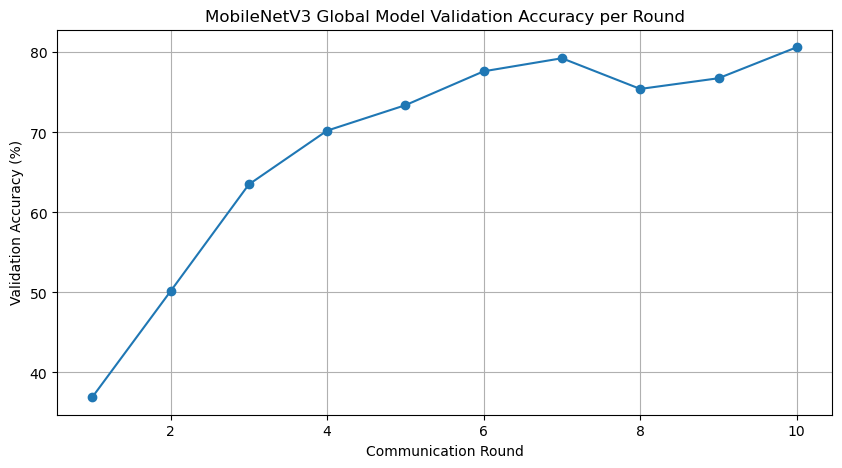

In [18]:
# Run regular federated learning with MobileNetV3

print("EXPERIMENT 1: FEDERATED LEARNING WITH MOBILENETV3")

mobilenet_federated_model, mobilenet_federated_metrics = run_federated_learning_mobilenetv3()

In [19]:
# visualization function
def visualize_predictions(model, dataloader, class_names, num_images=12, images_per_row=3):
    """
    Visualize sample predictions in a grid with specified images per row

    Args:
        model: The trained model
        dataloader: DataLoader containing images to visualize
        class_names: List of class names
        num_images: Total number of images to display
        images_per_row: Number of images to display in each row
    """
    model.eval()
    images_so_far = 0
    num_rows = (num_images + images_per_row - 1) // images_per_row  # Ceiling division for number of rows

    fig = plt.figure(figsize=(5 * images_per_row, 4 * num_rows))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Get predictions
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1

                # Calculate row and column position
                row = (images_so_far - 1) // images_per_row
                col = (images_so_far - 1) % images_per_row

                # Add subplot at the right position
                ax = plt.subplot(num_rows, images_per_row, images_so_far)
                ax.axis('off')

                # Set title with prediction and ground truth
                is_correct = preds[j] == labels[j]
                title_color = 'green' if is_correct else 'red'
                ax.set_title(f'Pred: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}',
                           color=title_color, fontsize=10)

                # Convert tensor to numpy for visualization
                image = inputs.cpu().data[j].numpy().transpose((1, 2, 0))

                # Un-normalize the image
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                image = std * image + mean
                image = np.clip(image, 0, 1)

                plt.imshow(image)

                if images_so_far == num_images:
                    plt.tight_layout()
                    plt.show()
                    return

    if images_so_far > 0:
        plt.tight_layout()
        plt.show()

Creating MobileNetV3-Large-100 model...
Visualizing Sample Predictions


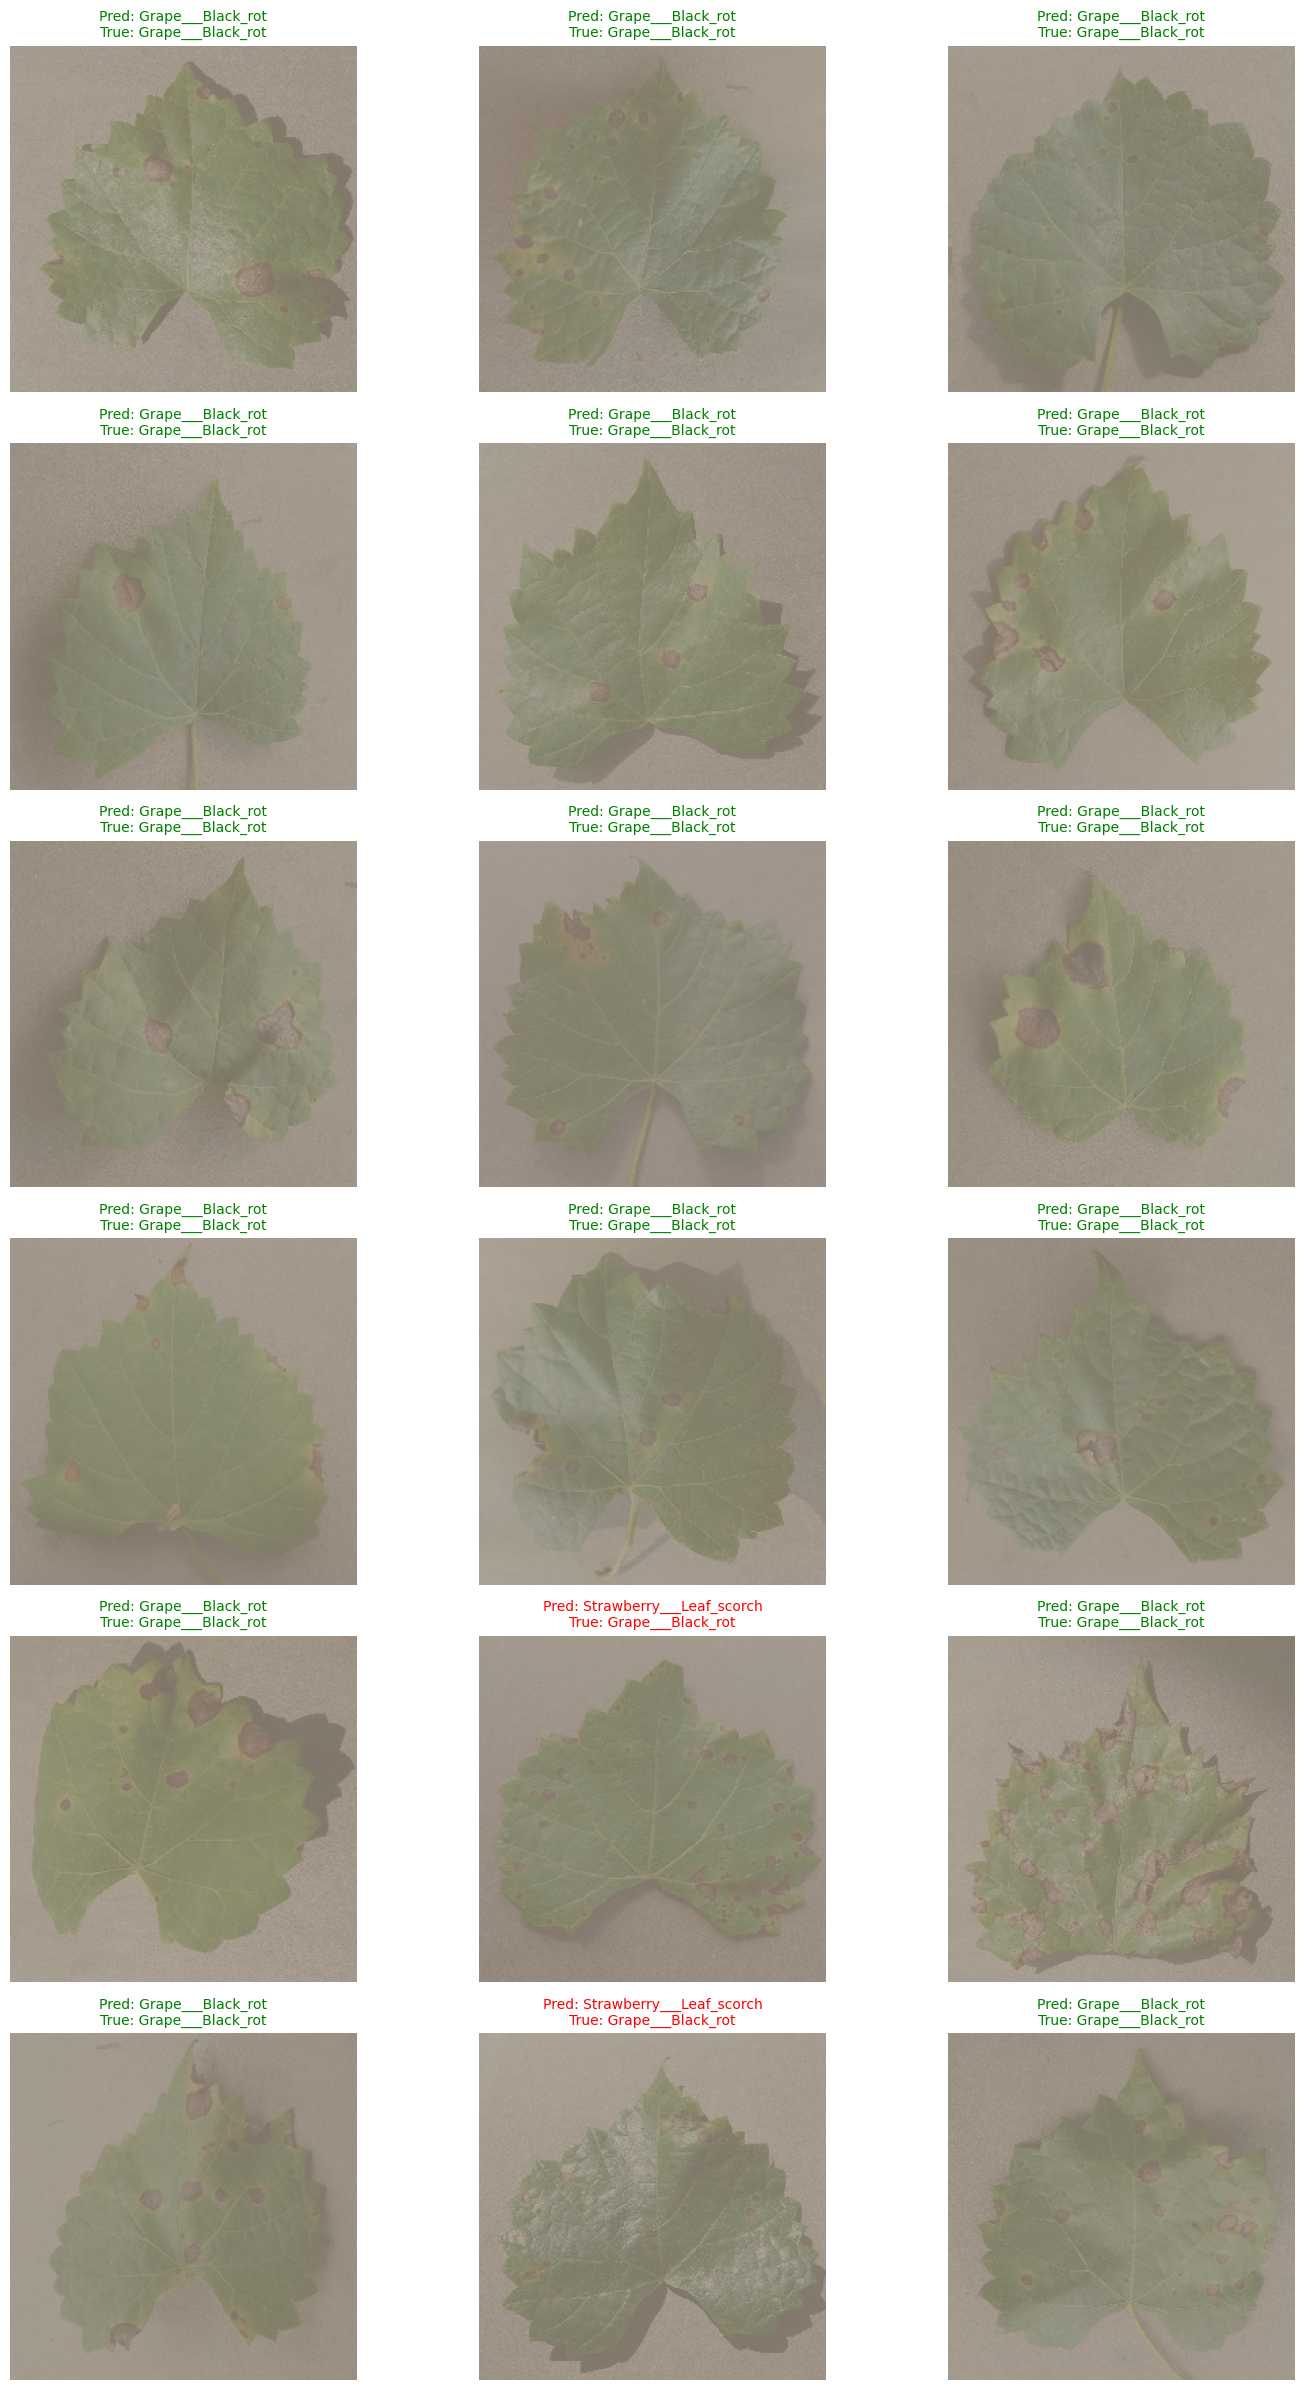

In [20]:
# load the saved model
global_model = create_mobilenetv3_model(NUM_CLASSES)
global_model = global_model.to(device)
global_model.load_state_dict(torch.load('federated_mobilenetv3_plant_disease_model.pth', map_location=device))
global_model.eval()

# Then visualize predictions
print("Visualizing Sample Predictions")
visualize_predictions(global_model, val_loader, class_names, num_images=18, images_per_row=3)


## Pruning

In [21]:
# Define pruning parameters
PRUNING_AMOUNT = 0.5  # 50% of weights will be pruned
PRUNING_ROUNDS = 10    # Number of pruning rounds
RETRAINING_EPOCHS = 3  # Epochs for retraining after pruning

# Function to print model parameter statistics (sparsity)
def print_sparsity(model):
    """Calculate and print the sparsity in the model parameters"""
    total_params = 0
    zero_params = 0

    for name, param in model.named_parameters():
        if 'weight' in name:
            total_params += param.numel()
            zero_params += (param == 0).sum().item()

    sparsity = 100.0 * zero_params / total_params
    print(f"Global sparsity: {sparsity:.2f}%")
    print(f"Zero parameters: {zero_params} / {total_params}")

    return sparsity


# Function to retrain pruned model
def retrain_pruned_model(model, train_loader, val_loader, epochs=2, lr=1e-4):
    """Retrain the pruned model to recover accuracy"""
    print(f" Retraining pruned model for {epochs} epochs")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)
    criterion = nn.CrossEntropyLoss()

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader),
                          desc=f"Retraining Epoch {epoch+1}/{epochs}")

        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Track metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            progress_bar.set_postfix({
                'loss': running_loss / (i + 1),
                'acc': 100. * correct / total
            })

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total

        # Log metrics
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        print(f"Retraining Epoch {epoch+1}/{epochs}: Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%")

        # Validation phase
        val_results = evaluate_model(model, val_loader)
        history['val_loss'].append(val_results['loss'])
        history['val_acc'].append(val_results['accuracy'])

        print(f"Validation: Loss: {val_results['loss']:.4f}, Acc: {val_results['accuracy']:.2f}%")

        # Update learning rate
        scheduler.step(val_results['loss'])

    return model, history

# Function to visualize pruning results
def plot_pruning_history(pruning_history):
    """Plot the accuracy and loss changes during pruning iterations"""
    plt.figure(figsize=(15, 10))

    # Plot accuracy
    plt.subplot(2, 1, 1)
    plt.plot(range(len(pruning_history['pre_prune_acc'])), pruning_history['pre_prune_acc'], 'bo-', label='Pre-pruning')
    plt.plot(range(len(pruning_history['post_prune_acc'])), pruning_history['post_prune_acc'], 'ro-', label='Post-pruning')
    plt.plot(range(len(pruning_history['retrained_acc'])), pruning_history['retrained_acc'], 'go-', label='After retraining')
    plt.title('Validation Accuracy During Pruning Process')
    plt.xlabel('Pruning Round')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # Plot sparsity
    plt.subplot(2, 1, 2)
    plt.plot(range(len(pruning_history['sparsity'])), pruning_history['sparsity'], 'mo-', label='Model Sparsity')
    plt.title('Model Sparsity During Pruning Process')
    plt.xlabel('Pruning Round')
    plt.ylabel('Sparsity (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [22]:
def run_oneshot_pruning_mobilenetv3(prune_amount=0.5):
    """Run one-shot pruning on MobileNetV3"""
    print("Running One-shot Pruning on MobileNetV3")

    # Initialize model
    model = create_mobilenetv3_model(NUM_CLASSES).to(device)

    # Print initial model stats
    print(" Initial Model Statistics")
    initial_stats = print_model_stats(model, "Initial MobileNetV3")

    # Train loader
    full_train_loader = DataLoader(
        train_dataset,
        batch_size=MOBILENET_BATCH_SIZE,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    # Train before pruning
    print(" Training Model Before Pruning")
    optimizer = optim.Adam(model.parameters(), lr=MOBILENET_LR)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(MOBILENET_EPOCHS):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(enumerate(full_train_loader), total=len(full_train_loader),
                            desc=f"Epoch {epoch+1}/{MOBILENET_EPOCHS}")

        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix({
                'loss': running_loss / (i + 1),
                'acc': 100. * correct / total
            })

        print(f"Epoch {epoch+1}: Loss: {running_loss/len(full_train_loader):.4f}, Acc: {100.*correct/total:.2f}%")

    # Evaluate before pruning
    pre_prune_results = evaluate_model(model, val_loader)
    print(f"Pre-pruning validation accuracy: {pre_prune_results['accuracy']:.2f}%")

    # Apply pruning
    print(f" Applying {int(prune_amount*100)}% One-shot Pruning")
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))

    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=prune_amount
    )

    # Make pruning permanent (before measuring sparsity)
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            prune.remove(module, 'weight')

    # Print actual post-pruning stats
    print("Post-Pruning Model Statistics")
    post_prune_stats = print_model_stats(model, "Pruned MobileNetV3")

    # Evaluate after pruning
    post_prune_results = evaluate_model(model, val_loader)
    print(f"Post-pruning validation accuracy: {post_prune_results['accuracy']:.2f}%")
    print(f"Accuracy change: {post_prune_results['accuracy'] - pre_prune_results['accuracy']:.2f}%")

    # Fine-tune pruned model
    print(" Fine-tuning Pruned Model")
    optimizer = optim.Adam(model.parameters(), lr=MOBILENET_LR/10)

    for epoch in range(MOBILENET_EPOCHS):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(enumerate(full_train_loader), total=len(full_train_loader),
                            desc=f"Fine-tuning Epoch {epoch+1}/{MOBILENET_EPOCHS}")

        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix({
                'loss': running_loss / (i + 1),
                'acc': 100. * correct / total
            })

        print(f"Fine-tuning Epoch {epoch+1}: Loss: {running_loss/len(full_train_loader):.4f}, Acc: {100.*correct/total:.2f}%")

    # Final stats
    print(" Final Model Statistics After Fine-tuning")
    final_stats = print_model_stats(model, "Fine-tuned Pruned MobileNetV3")

    # Final evaluation
    final_results = evaluate_model(model, val_loader)
    print(f"Fine-tuned pruned validation accuracy: {final_results['accuracy']:.2f}%")
    print(f"Total accuracy change: {final_results['accuracy'] - pre_prune_results['accuracy']:.2f}%")

    # Save model
    torch.save(model.state_dict(), 'oneshot_pruned_mobilenetv3_plant_disease_model.pth')
    print("One-shot pruned model saved as 'oneshot_pruned_mobilenetv3_plant_disease_model.pth'")

    # Create and print comparison table
    pruning_comparison = {
        'Initial': {
            'params': initial_stats['total_params'],
            'trainable_params': initial_stats['trainable_params'],
            'zero_params': initial_stats['zero_params'],
            'sparsity': initial_stats['sparsity'],
            'accuracy': pre_prune_results['accuracy']
        },
        'Pruned': {
            'params': post_prune_stats['total_params'],
            'trainable_params': post_prune_stats['trainable_params'],
            'zero_params': post_prune_stats['zero_params'],
            'sparsity': post_prune_stats['sparsity'],
            'accuracy': post_prune_results['accuracy']
        },
        'Fine-tuned': {
            'params': final_stats['total_params'],
            'trainable_params': final_stats['trainable_params'],
            'zero_params': final_stats['zero_params'],
            'sparsity': final_stats['sparsity'],
            'accuracy': final_results['accuracy']
        }
    }

    print(" One-shot Pruning Comparison")
    print("{:<15} {:<15} {:<15} {:<15} {:<15} {:<15}".format(
        'Stage', 'Total Params', 'Trainable Params', 'Zero Params', 'Sparsity (%)', 'Accuracy (%)'))
    print("-" * 90)
    for stage, metrics in pruning_comparison.items():
        print("{:<15} {:<15,} {:<15,} {:<15,} {:<15.2f} {:<15.2f}".format(
            stage,
            metrics['params'],
            metrics['trainable_params'],
            metrics['zero_params'],
            metrics['sparsity'],
            metrics['accuracy']
        ))

    return model, pruning_comparison


In [23]:
# Run one-shot pruning with MobileNetV3
print("EXPERIMENT 2: ONE-SHOT PRUNING WITH MOBILENETV3")

mobilenet_oneshot_pruned_model, mobilenet_oneshot_pruning_comparison = run_oneshot_pruning_mobilenetv3()

EXPERIMENT 2: ONE-SHOT PRUNING WITH MOBILENETV3
Running One-shot Pruning on MobileNetV3
Creating MobileNetV3-Large-100 model...
 Initial Model Statistics
\Initial MobileNetV3 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 0.00%
Zero parameters: 0 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
 Training Model Before Pruning


Epoch 1/5:  15%|█▌        | 331/2197 [00:18<01:21, 22.88it/s, loss=1.12, acc=76.4]

Epoch 1/5: 100%|██████████| 2197/2197 [01:36<00:00, 22.76it/s, loss=0.227, acc=94.6]

Epoch 1: Loss: 0.2269, Acc: 94.62%



Epoch 2/5: 100%|██████████| 2197/2197 [01:30<00:00, 24.17it/s, loss=0.0237, acc=99.3]

Epoch 2: Loss: 0.0237, Acc: 99.26%



Epoch 3/5: 100%|██████████| 2197/2197 [01:30<00:00, 24.40it/s, loss=0.0153, acc=99.5]

Epoch 3: Loss: 0.0153, Acc: 99.51%



Epoch 4/5: 100%|██████████| 2197/2197 [01:40<00:00, 21.96it/s, loss=0.0118, acc=99.6]

Epoch 4: Loss: 0.0118, Acc: 99.65%



Epoch 5/5: 100%|██████████| 2197/2197 [01:30<00:00, 24.25it/s, loss=0.00942, acc=99.7]


Epoch 5: Loss: 0.0094, Acc: 99.70%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 52.22it/s]


Pre-pruning validation accuracy: 99.62%
 Applying 50% One-shot Pruning
Post-Pruning Model Statistics
\Pruned MobileNetV3 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 49.87%
Zero parameters: 2,423,044 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 53.03it/s]

Post-pruning validation accuracy: 97.31%
Accuracy change: -2.31%
 Fine-tuning Pruned Model



Fine-tuning Epoch 1/5: 100%|██████████| 2197/2197 [01:38<00:00, 22.21it/s, loss=0.0452, acc=99.8]

Fine-tuning Epoch 1: Loss: 0.0452, Acc: 99.83%



Fine-tuning Epoch 2/5: 100%|██████████| 2197/2197 [01:32<00:00, 23.84it/s, loss=0.0043, acc=99.9] 

Fine-tuning Epoch 2: Loss: 0.0043, Acc: 99.92%



Fine-tuning Epoch 3/5: 100%|██████████| 2197/2197 [01:29<00:00, 24.48it/s, loss=0.00292, acc=99.9]

Fine-tuning Epoch 3: Loss: 0.0029, Acc: 99.93%



Fine-tuning Epoch 4/5: 100%|██████████| 2197/2197 [01:29<00:00, 24.60it/s, loss=0.00232, acc=99.9]

Fine-tuning Epoch 4: Loss: 0.0023, Acc: 99.94%



Fine-tuning Epoch 5/5: 100%|██████████| 2197/2197 [01:37<00:00, 22.61it/s, loss=0.00145, acc=100]


Fine-tuning Epoch 5: Loss: 0.0015, Acc: 99.97%
 Final Model Statistics After Fine-tuning
\Fine-tuned Pruned MobileNetV3 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 0.09%
Zero parameters: 4,307 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 49.91it/s]

Fine-tuned pruned validation accuracy: 99.90%
Total accuracy change: 0.28%
One-shot pruned model saved as 'oneshot_pruned_mobilenetv3_plant_disease_model.pth'
 One-shot Pruning Comparison
Stage           Total Params    Trainable Params Zero Params     Sparsity (%)    Accuracy (%)   
------------------------------------------------------------------------------------------
Initial         4,877,398       4,877,398       0               0.00            99.62          
Pruned          4,877,398       4,877,398       2,423,044       49.87           97.31          
Fine-tuned      4,877,398       4,877,398       4,307           0.09            99.90          


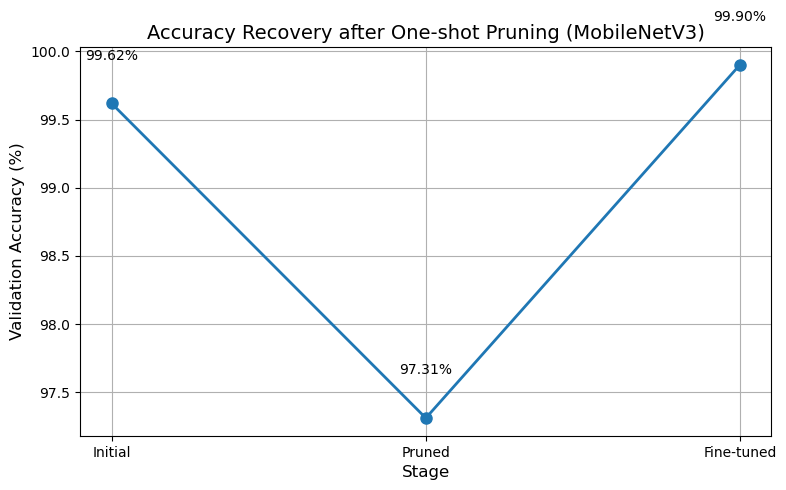

In [24]:
#  'pruning_comparison' from run_oneshot_pruning_mobilenetv3()
stages = list(mobilenet_oneshot_pruning_comparison.keys())
accuracies = [metrics['accuracy'] for metrics in mobilenet_oneshot_pruning_comparison.values()]

# Create the plot
plt.figure(figsize=(8,5))
plt.plot(stages, accuracies, marker='o', linestyle='-', linewidth=2, markersize=8)

# Add labels and title
plt.title('Accuracy Recovery after One-shot Pruning (MobileNetV3)', fontsize=14)
plt.xlabel('Stage', fontsize=12)
plt.ylabel('Validation Accuracy (%)', fontsize=12)
plt.grid(True)

# Annotate points automatically
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.3, f'{acc:.2f}%', ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


## Federated Learning with Pruning

In [25]:
# Federated Learning with Pruning Configuration
FED_PRUNING_ROUNDS = 18          # Number of federated rounds
CLIENT_PRUNE_THRESHOLD = 0.1      # Pruning amount in each client
SERVER_PRUNE_THRESHOLD = 0.2      # Additional pruning at server level
PRUNE_EVERY_N_ROUNDS = 1          # Apply pruning every N federated rounds
FINE_TUNE_EPOCHS = 3            # Epochs for fine-tuning after pruning

In [26]:
def run_federated_pruning_mobilenetv3():
    """Run federated learning with pruning for MobileNetV3"""
    print(" Starting Federated Learning with Pruning for MobileNetV3")

    # Initialize global model
    global_model = create_mobilenetv3_model(NUM_CLASSES).to(device)

    # Print initial model statistics
    initial_stats = print_model_stats(global_model, "Initial MobileNetV3")

    # For tracking metrics
    global_metrics = {
        'round_val_accuracy': [],
        'round_val_loss': [],
        'client_train_losses': [[] for _ in range(NUM_CLIENTS)],
        'client_train_accuracies': [[] for _ in range(NUM_CLIENTS)],
        'model_sparsity': [initial_stats['sparsity']]
    }

    # Define pruning schedule - progressive pruning
    total_pruning = MOBILENET_PRUNING_AMOUNT
    client_prune_per_round = [0] * FED_PRUNING_ROUNDS

    for i in range(1, FED_PRUNING_ROUNDS):
        progress = (i / (FED_PRUNING_ROUNDS - 1)) ** 2
        client_prune_per_round[i] = 0.02 + (total_pruning - 0.1) * progress

    print(f"Client pruning schedule: {[round(p*100, 2) for p in client_prune_per_round]}%")

    early_weights = None

    for round_idx in range(FED_PRUNING_ROUNDS):
        print(f"Communication Round {round_idx + 1}/{FED_PRUNING_ROUNDS}")

        if round_idx == 1:
            early_weights = copy.deepcopy(global_model.state_dict())

        client_prune_amount = client_prune_per_round[round_idx]
        if client_prune_amount > 0:
            print(f"Applying {client_prune_amount*100:.2f}% client pruning in this round")

        client_weights = []
        client_sample_counts = []
        client_histories = []

        for client_id in range(NUM_CLIENTS):
            print(f"Training Client {client_id + 1}/{NUM_CLIENTS}")

            client_model = create_mobilenetv3_model(NUM_CLASSES)
            client_model.load_state_dict(global_model.state_dict())
            client_samples = len(client_indices[client_id])
            client_sample_counts.append(client_samples)

            client_state_dict, client_history = train_client_model(
                client_model,
                client_dataloaders[client_id],
                epochs=MOBILENET_EPOCHS,
                client_id=client_id,
                lr=MOBILENET_LR
            )

            if client_prune_amount > 0:
                pruned_client = create_mobilenetv3_model(NUM_CLASSES).to(device)
                pruned_client.load_state_dict(client_state_dict)

                for name, module in pruned_client.named_modules():
                    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
                        weight = module.weight.data.clone()
                        weight_vec = weight.view(-1)
                        k = int(client_prune_amount * weight_vec.shape[0])
                        if k > 0:
                            threshold = weight_vec.abs().sort()[0][k]
                            mask = weight.abs() > threshold
                            module.weight.data = weight * mask.float()

                client_stats = print_model_stats(pruned_client, f"Client {client_id+1} after pruning")
                print(f"Client {client_id+1} model sparsity: {client_stats['sparsity']:.2f}%")

                client_state_dict = pruned_client.state_dict()
                del pruned_client

            client_weights.append(client_state_dict)
            client_histories.append(client_history)
            global_metrics['client_train_losses'][client_id].extend(client_history['train_loss'])
            global_metrics['client_train_accuracies'][client_id].extend(client_history['train_acc'])

            del client_model
            clear_memory()

        global_model.load_state_dict(federated_averaging(client_weights, client_sample_counts))

        round_stats = print_model_stats(global_model, f"MobileNetV3 Round {round_idx + 1}")
        global_metrics['model_sparsity'].append(round_stats['sparsity'])

        print(" Evaluating Global Model on Validation Set ")
        val_results = evaluate_model(global_model, val_loader)
        global_metrics['round_val_accuracy'].append(val_results['accuracy'])
        global_metrics['round_val_loss'].append(val_results['loss'])
        print(f"Round {round_idx + 1} - Validation Accuracy: {val_results['accuracy']:.2f}%")
        print(f"Round {round_idx + 1} - Validation Loss: {val_results['loss']:.4f}")
        print(f"Round {round_idx + 1} - Model Sparsity: {round_stats['sparsity']:.2f}%")

        if client_prune_amount > 0:
            print(" Fine-tuning Global Model after Pruning")

            if round_idx > 1 and val_results['accuracy'] < 0.6 * global_metrics['round_val_accuracy'][round_idx-2]:
                print("Significant accuracy drop detected. Rewinding to earlier weights...")
                if early_weights is not None:
                    current_zeros = {}
                    for name, param in global_model.named_parameters():
                        if 'weight' in name:
                            current_zeros[name] = (param == 0)

                    global_model.load_state_dict(early_weights)

                    with torch.no_grad():
                        for name, param in global_model.named_parameters():
                            if name in current_zeros:
                                param.data[current_zeros[name]] = 0.0

            fine_tune_indices = []
            for client_idx in range(NUM_CLIENTS):
                client_data = client_indices[client_idx]
                sample_size = len(client_data) // 3
                fine_tune_indices.extend(client_data[:sample_size])

            fine_tune_loader = DataLoader(
                Subset(train_dataset, fine_tune_indices),
                batch_size=MOBILENET_BATCH_SIZE,
                shuffle=True,
                num_workers=4,
                pin_memory=True
            )

            global_model, _ = retrain_pruned_model(
                global_model,
                fine_tune_loader,
                val_loader,
                epochs=FINE_TUNE_EPOCHS
            )

            val_after_finetune = evaluate_model(global_model, val_loader)
            print(f"After fine-tuning - Validation Accuracy: {val_after_finetune['accuracy']:.2f}%")

    # Reapply pruning to the final global model to match the sparsity curve
    for name, module in global_model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            weight = module.weight.data.clone()
            weight_vec = weight.view(-1)
            final_sparsity_target = global_metrics['model_sparsity'][-1] / 100
            k = int(final_sparsity_target * weight_vec.shape[0])

            if k > 0:
                threshold = weight_vec.abs().sort()[0][k]
                mask = weight.abs() > threshold
                module.weight.data = weight * mask.float()


    final_stats = print_model_stats(global_model, "Final Pruned Federated MobileNetV3")
    print(f"Final Model Sparsity: {final_stats['sparsity']:.2f}%")

    torch.save(global_model.state_dict(), 'pruned_federated_mobilenetv3_plant_disease_model.pth')
    print("Pruned federated model saved as 'pruned_federated_mobilenetv3_plant_disease_model.pth'")

    plt.figure(figsize=(10, 5))
    plt.plot(range(len(global_metrics['model_sparsity'])), global_metrics['model_sparsity'], 'mo-', marker='o')
    plt.title('MobileNetV3 Model Sparsity During Federated Learning')
    plt.xlabel('Communication Round')
    plt.ylabel('Sparsity (%)')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, FED_PRUNING_ROUNDS + 1), global_metrics['round_val_accuracy'], 'bo-', marker='o')
    plt.title('MobileNetV3 Global Model Validation Accuracy per Round')
    plt.xlabel('Communication Round')
    plt.ylabel('Validation Accuracy (%)')
    plt.grid(True)
    plt.show()

    return global_model, global_metrics


# retrain_pruned_model function
def retrain_pruned_model(model, train_loader, val_loader, epochs=3, lr=1e-4):
    """Retrain the pruned model with modified approach to recover accuracy"""
    print(f" Retraining pruned model for {epochs} epochs")
    model = model.to(device)

    # Use a cosine annealing scheduler for better convergence
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss()

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0
    best_model_state = None

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        progress_bar = tqdm(enumerate(train_loader),
                           total=len(train_loader),
                           desc=f"Retraining Epoch {epoch+1}/{epochs}")

        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Apply gradual gradient clipping to stabilize training
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Track metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            progress_bar.set_postfix({
                'loss': running_loss / (i + 1),
                'acc': 100. * correct / total
            })

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total

        # Log metrics
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        print(f"Retraining Epoch {epoch+1}/{epochs}: Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%")

        # Validation phase
        val_results = evaluate_model(model, val_loader)
        history['val_loss'].append(val_results['loss'])
        history['val_acc'].append(val_results['accuracy'])
        print(f"Validation: Loss: {val_results['loss']:.4f}, Acc: {val_results['accuracy']:.2f}%")

        # Save best model
        if val_results['accuracy'] > best_val_acc:
            best_val_acc = val_results['accuracy']
            best_model_state = copy.deepcopy(model.state_dict())

        # Update learning rate
        scheduler.step()

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Restored best model with validation accuracy: {best_val_acc:.2f}%")

    return model, history

EXPERIMENT 3: FEDERATED LEARNING WITH PRUNING FOR MOBILENETV3
 Starting Federated Learning with Pruning for MobileNetV3
Creating MobileNetV3-Large-100 model...


\Initial MobileNetV3 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 0.00%
Zero parameters: 1 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client pruning schedule: [0, 2.14, 2.55, 3.25, 4.21, 5.46, 6.98, 8.78, 10.86, 13.21, 15.84, 18.75, 21.93, 25.39, 29.13, 33.14, 37.43, 42.0]%
Communication Round 1/18
Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.24it/s, loss=0.469, acc=89]  

Client 1, Epoch 1/5: Loss: 0.4687, Acc: 89.04%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.41it/s, loss=0.028, acc=99.1] 

Client 1, Epoch 2/5: Loss: 0.0280, Acc: 99.13%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.24it/s, loss=0.0138, acc=99.6]

Client 1, Epoch 3/5: Loss: 0.0138, Acc: 99.55%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.50it/s, loss=0.0118, acc=99.7] 

Client 1, Epoch 4/5: Loss: 0.0118, Acc: 99.67%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 24.16it/s, loss=0.0104, acc=99.7] 


Client 1, Epoch 5/5: Loss: 0.0104, Acc: 99.67%
Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.26it/s, loss=0.317, acc=93.4]

Client 2, Epoch 1/5: Loss: 0.3174, Acc: 93.45%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.46it/s, loss=0.00857, acc=99.8]

Client 2, Epoch 2/5: Loss: 0.0086, Acc: 99.77%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 23.15it/s, loss=0.00825, acc=99.7]

Client 2, Epoch 3/5: Loss: 0.0082, Acc: 99.74%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:22<00:00, 19.86it/s, loss=0.00379, acc=99.9]

Client 2, Epoch 4/5: Loss: 0.0038, Acc: 99.86%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:20<00:00, 21.78it/s, loss=0.00231, acc=100] 


Client 2, Epoch 5/5: Loss: 0.0023, Acc: 99.95%
Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.39it/s, loss=0.297, acc=95.5]

Client 3, Epoch 1/5: Loss: 0.2972, Acc: 95.50%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.78it/s, loss=0.0174, acc=99.4]

Client 3, Epoch 2/5: Loss: 0.0174, Acc: 99.44%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.60it/s, loss=0.00903, acc=99.7]

Client 3, Epoch 3/5: Loss: 0.0090, Acc: 99.67%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.47it/s, loss=0.0068, acc=99.8] 

Client 3, Epoch 4/5: Loss: 0.0068, Acc: 99.78%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.55it/s, loss=0.00585, acc=99.8]


Client 3, Epoch 5/5: Loss: 0.0059, Acc: 99.79%
Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.64it/s, loss=0.309, acc=94.9]

Client 4, Epoch 1/5: Loss: 0.3086, Acc: 94.94%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.97it/s, loss=0.00708, acc=99.8]

Client 4, Epoch 2/5: Loss: 0.0071, Acc: 99.79%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.87it/s, loss=0.00557, acc=99.9]

Client 4, Epoch 3/5: Loss: 0.0056, Acc: 99.86%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.92it/s, loss=0.00321, acc=99.9]

Client 4, Epoch 4/5: Loss: 0.0032, Acc: 99.90%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.19it/s, loss=0.00267, acc=99.9]


Client 4, Epoch 5/5: Loss: 0.0027, Acc: 99.91%
Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:22<00:00, 19.65it/s, loss=0.313, acc=94.1]

Client 5, Epoch 1/5: Loss: 0.3134, Acc: 94.06%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:30<00:00, 14.44it/s, loss=0.00949, acc=99.7]

Client 5, Epoch 2/5: Loss: 0.0095, Acc: 99.71%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:23<00:00, 19.03it/s, loss=0.00729, acc=99.8]

Client 5, Epoch 3/5: Loss: 0.0073, Acc: 99.79%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:20<00:00, 21.80it/s, loss=0.00257, acc=99.9]

Client 5, Epoch 4/5: Loss: 0.0026, Acc: 99.93%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.41it/s, loss=0.00186, acc=99.9]


Client 5, Epoch 5/5: Loss: 0.0019, Acc: 99.94%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 1 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 0.00%
Zero parameters: 0 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
 Evaluating Global Model on Validation Set 


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 50.91it/s]


Round 1 - Validation Accuracy: 37.14%
Round 1 - Validation Loss: 2.7677
Round 1 - Model Sparsity: 0.00%
Communication Round 2/18
Applying 2.14% client pruning in this round
Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.43it/s, loss=0.152, acc=96.9]

Client 1, Epoch 1/5: Loss: 0.1515, Acc: 96.92%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 24.16it/s, loss=0.0184, acc=99.4]

Client 1, Epoch 2/5: Loss: 0.0184, Acc: 99.37%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.63it/s, loss=0.00927, acc=99.7]

Client 1, Epoch 3/5: Loss: 0.0093, Acc: 99.68%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.19it/s, loss=0.0081, acc=99.8] 

Client 1, Epoch 4/5: Loss: 0.0081, Acc: 99.75%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 24.30it/s, loss=0.00954, acc=99.7]


Client 1, Epoch 5/5: Loss: 0.0095, Acc: 99.69%
Creating MobileNetV3-Large-100 model...
\Client 1 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 2.13%
Zero parameters: 103,662 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 1 model sparsity: 2.13%
Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.61it/s, loss=0.0787, acc=99]  

Client 2, Epoch 1/5: Loss: 0.0787, Acc: 99.03%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.63it/s, loss=0.00811, acc=99.8]

Client 2, Epoch 2/5: Loss: 0.0081, Acc: 99.75%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 24.41it/s, loss=0.00616, acc=99.8]

Client 2, Epoch 3/5: Loss: 0.0062, Acc: 99.82%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:22<00:00, 19.26it/s, loss=0.00283, acc=99.9]

Client 2, Epoch 4/5: Loss: 0.0028, Acc: 99.92%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.76it/s, loss=0.00389, acc=99.9]


Client 2, Epoch 5/5: Loss: 0.0039, Acc: 99.86%
Creating MobileNetV3-Large-100 model...
\Client 2 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 2.13%
Zero parameters: 103,662 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 2 model sparsity: 2.13%
Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.39it/s, loss=0.082, acc=98.8] 

Client 3, Epoch 1/5: Loss: 0.0820, Acc: 98.78%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.83it/s, loss=0.0111, acc=99.7] 

Client 3, Epoch 2/5: Loss: 0.0111, Acc: 99.69%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 24.08it/s, loss=0.00824, acc=99.8]

Client 3, Epoch 3/5: Loss: 0.0082, Acc: 99.78%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 24.19it/s, loss=0.00384, acc=99.9]

Client 3, Epoch 4/5: Loss: 0.0038, Acc: 99.89%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.95it/s, loss=0.00324, acc=99.9]


Client 3, Epoch 5/5: Loss: 0.0032, Acc: 99.89%
Creating MobileNetV3-Large-100 model...
\Client 3 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 2.13%
Zero parameters: 103,662 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 3 model sparsity: 2.13%
Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.21it/s, loss=0.0727, acc=99.4]

Client 4, Epoch 1/5: Loss: 0.0727, Acc: 99.37%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.34it/s, loss=0.00555, acc=99.8]

Client 4, Epoch 2/5: Loss: 0.0056, Acc: 99.84%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 24.21it/s, loss=0.00386, acc=99.9]

Client 4, Epoch 3/5: Loss: 0.0039, Acc: 99.89%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.51it/s, loss=0.00242, acc=99.9]

Client 4, Epoch 4/5: Loss: 0.0024, Acc: 99.91%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 24.21it/s, loss=0.00124, acc=100] 


Client 4, Epoch 5/5: Loss: 0.0012, Acc: 99.97%
Creating MobileNetV3-Large-100 model...
\Client 4 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 2.13%
Zero parameters: 103,662 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 4 model sparsity: 2.13%
Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.38it/s, loss=0.0734, acc=99.2]

Client 5, Epoch 1/5: Loss: 0.0734, Acc: 99.23%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:22<00:00, 19.92it/s, loss=0.00653, acc=99.8]

Client 5, Epoch 2/5: Loss: 0.0065, Acc: 99.84%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.63it/s, loss=0.00413, acc=99.9]

Client 5, Epoch 3/5: Loss: 0.0041, Acc: 99.89%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.43it/s, loss=0.00541, acc=99.9]

Client 5, Epoch 4/5: Loss: 0.0054, Acc: 99.87%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.78it/s, loss=0.0025, acc=99.9] 


Client 5, Epoch 5/5: Loss: 0.0025, Acc: 99.93%
Creating MobileNetV3-Large-100 model...
\Client 5 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 2.13%
Zero parameters: 103,662 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 5 model sparsity: 2.13%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 2 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 0.03%
Zero parameters: 1,454 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
 Evaluating Global Model on Validation Set 


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 51.16it/s]

Round 2 - Validation Accuracy: 38.31%
Round 2 - Validation Loss: 1.8915
Round 2 - Model Sparsity: 0.03%
 Fine-tuning Global Model after Pruning
 Retraining pruned model for 3 epochs



Retraining Epoch 1/3: 100%|██████████| 733/733 [00:31<00:00, 23.57it/s, loss=0.0477, acc=98.8]


Retraining Epoch 1/3: Loss: 0.0477, Acc: 98.80%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 53.79it/s]

Validation: Loss: 4.8742, Acc: 44.75%



Retraining Epoch 2/3: 100%|██████████| 733/733 [00:29<00:00, 24.81it/s, loss=0.00703, acc=99.8]


Retraining Epoch 2/3: Loss: 0.0070, Acc: 99.78%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 52.79it/s]

Validation: Loss: 5.3233, Acc: 44.99%



Retraining Epoch 3/3: 100%|██████████| 733/733 [00:29<00:00, 24.89it/s, loss=0.00279, acc=99.9]


Retraining Epoch 3/3: Loss: 0.0028, Acc: 99.92%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 54.23it/s]


Validation: Loss: 5.3699, Acc: 44.90%
Restored best model with validation accuracy: 44.99%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 51.69it/s]


After fine-tuning - Validation Accuracy: 44.99%
Communication Round 3/18
Applying 2.55% client pruning in this round
Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.90it/s, loss=0.127, acc=97]  

Client 1, Epoch 1/5: Loss: 0.1270, Acc: 97.03%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.46it/s, loss=0.0131, acc=99.6]

Client 1, Epoch 2/5: Loss: 0.0131, Acc: 99.57%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.33it/s, loss=0.00992, acc=99.7]

Client 1, Epoch 3/5: Loss: 0.0099, Acc: 99.69%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.42it/s, loss=0.01, acc=99.7]   

Client 1, Epoch 4/5: Loss: 0.0100, Acc: 99.70%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 24.05it/s, loss=0.00686, acc=99.8]


Client 1, Epoch 5/5: Loss: 0.0069, Acc: 99.77%
Creating MobileNetV3-Large-100 model...
\Client 1 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 2.55%
Zero parameters: 123,782 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 1 model sparsity: 2.55%
Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.01it/s, loss=0.0747, acc=98.4]

Client 2, Epoch 1/5: Loss: 0.0747, Acc: 98.39%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 24.23it/s, loss=0.00472, acc=99.9]

Client 2, Epoch 2/5: Loss: 0.0047, Acc: 99.87%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.70it/s, loss=0.00492, acc=99.8]

Client 2, Epoch 3/5: Loss: 0.0049, Acc: 99.78%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.82it/s, loss=0.0034, acc=99.9] 


Client 2, Epoch 4/5: Loss: 0.0034, Acc: 99.90%


Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.37it/s, loss=0.00318, acc=99.9]


Client 2, Epoch 5/5: Loss: 0.0032, Acc: 99.90%
Creating MobileNetV3-Large-100 model...
\Client 2 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 2.55%
Zero parameters: 123,782 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 2 model sparsity: 2.55%
Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:17<00:00, 24.51it/s, loss=0.0726, acc=98.4]

Client 3, Epoch 1/5: Loss: 0.0726, Acc: 98.36%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 24.04it/s, loss=0.00576, acc=99.8]

Client 3, Epoch 2/5: Loss: 0.0058, Acc: 99.79%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.77it/s, loss=0.00538, acc=99.8]

Client 3, Epoch 3/5: Loss: 0.0054, Acc: 99.84%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:20<00:00, 20.98it/s, loss=0.00426, acc=99.9]

Client 3, Epoch 4/5: Loss: 0.0043, Acc: 99.85%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:20<00:00, 21.65it/s, loss=0.00385, acc=99.9]


Client 3, Epoch 5/5: Loss: 0.0039, Acc: 99.88%
Creating MobileNetV3-Large-100 model...
\Client 3 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 2.55%
Zero parameters: 123,782 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 3 model sparsity: 2.55%
Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.95it/s, loss=0.0688, acc=98.5]

Client 4, Epoch 1/5: Loss: 0.0688, Acc: 98.49%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 23.13it/s, loss=0.00204, acc=100] 

Client 4, Epoch 2/5: Loss: 0.0020, Acc: 99.95%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.29it/s, loss=0.00201, acc=99.9]

Client 4, Epoch 3/5: Loss: 0.0020, Acc: 99.94%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.37it/s, loss=0.00393, acc=99.9]

Client 4, Epoch 4/5: Loss: 0.0039, Acc: 99.89%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.55it/s, loss=0.00201, acc=99.9]


Client 4, Epoch 5/5: Loss: 0.0020, Acc: 99.94%
Creating MobileNetV3-Large-100 model...
\Client 4 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 2.55%
Zero parameters: 123,782 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 4 model sparsity: 2.55%
Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 23.02it/s, loss=0.0909, acc=98.3]

Client 5, Epoch 1/5: Loss: 0.0909, Acc: 98.28%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.64it/s, loss=0.00427, acc=99.9]

Client 5, Epoch 2/5: Loss: 0.0043, Acc: 99.87%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.57it/s, loss=0.0039, acc=99.8] 

Client 5, Epoch 3/5: Loss: 0.0039, Acc: 99.84%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.46it/s, loss=0.00317, acc=99.9]

Client 5, Epoch 4/5: Loss: 0.0032, Acc: 99.94%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.36it/s, loss=0.00265, acc=99.9]


Client 5, Epoch 5/5: Loss: 0.0026, Acc: 99.92%
Creating MobileNetV3-Large-100 model...
\Client 5 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 2.55%
Zero parameters: 123,782 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 5 model sparsity: 2.55%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 3 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 0.13%
Zero parameters: 6,487 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
 Evaluating Global Model on Validation Set 


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 50.13it/s]

Round 3 - Validation Accuracy: 51.49%
Round 3 - Validation Loss: 2.2481
Round 3 - Model Sparsity: 0.13%
 Fine-tuning Global Model after Pruning
 Retraining pruned model for 3 epochs



Retraining Epoch 1/3: 100%|██████████| 733/733 [00:32<00:00, 22.40it/s, loss=0.00745, acc=99.8]


Retraining Epoch 1/3: Loss: 0.0075, Acc: 99.77%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 54.33it/s]

Validation: Loss: 6.1898, Acc: 45.19%



Retraining Epoch 2/3: 100%|██████████| 733/733 [00:29<00:00, 24.45it/s, loss=0.00408, acc=99.9]


Retraining Epoch 2/3: Loss: 0.0041, Acc: 99.86%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 54.81it/s]

Validation: Loss: 7.1324, Acc: 45.03%



Retraining Epoch 3/3: 100%|██████████| 733/733 [00:30<00:00, 24.00it/s, loss=0.00127, acc=99.9] 


Retraining Epoch 3/3: Loss: 0.0013, Acc: 99.95%


Evaluating: 100%|██████████| 550/550 [00:09<00:00, 56.33it/s]


Validation: Loss: 7.4122, Acc: 45.04%
Restored best model with validation accuracy: 45.19%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 52.46it/s]


After fine-tuning - Validation Accuracy: 45.19%
Communication Round 4/18
Applying 3.25% client pruning in this round
Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.76it/s, loss=0.152, acc=97]  

Client 1, Epoch 1/5: Loss: 0.1515, Acc: 96.96%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.74it/s, loss=0.00915, acc=99.7]

Client 1, Epoch 2/5: Loss: 0.0092, Acc: 99.71%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 24.00it/s, loss=0.00679, acc=99.8]

Client 1, Epoch 3/5: Loss: 0.0068, Acc: 99.81%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:22<00:00, 19.93it/s, loss=0.0102, acc=99.7] 

Client 1, Epoch 4/5: Loss: 0.0102, Acc: 99.71%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:21<00:00, 20.68it/s, loss=0.0088, acc=99.7] 


Client 1, Epoch 5/5: Loss: 0.0088, Acc: 99.74%
Creating MobileNetV3-Large-100 model...
\Client 1 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 3.24%
Zero parameters: 157,323 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 1 model sparsity: 3.24%
Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.59it/s, loss=0.105, acc=98.1]

Client 2, Epoch 1/5: Loss: 0.1054, Acc: 98.14%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.64it/s, loss=0.0037, acc=99.9] 

Client 2, Epoch 2/5: Loss: 0.0037, Acc: 99.88%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.54it/s, loss=0.00256, acc=99.9]

Client 2, Epoch 3/5: Loss: 0.0026, Acc: 99.93%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.40it/s, loss=0.00413, acc=99.9]

Client 2, Epoch 4/5: Loss: 0.0041, Acc: 99.89%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.72it/s, loss=0.00325, acc=99.9]


Client 2, Epoch 5/5: Loss: 0.0033, Acc: 99.90%
Creating MobileNetV3-Large-100 model...
\Client 2 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 3.24%
Zero parameters: 157,323 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 2 model sparsity: 3.24%
Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.37it/s, loss=0.0971, acc=98.1]

Client 3, Epoch 1/5: Loss: 0.0971, Acc: 98.14%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 24.24it/s, loss=0.00406, acc=99.9]

Client 3, Epoch 2/5: Loss: 0.0041, Acc: 99.87%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 24.42it/s, loss=0.00358, acc=99.9]

Client 3, Epoch 3/5: Loss: 0.0036, Acc: 99.89%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.91it/s, loss=0.00492, acc=99.9]

Client 3, Epoch 4/5: Loss: 0.0049, Acc: 99.89%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.66it/s, loss=0.00296, acc=99.9]


Client 3, Epoch 5/5: Loss: 0.0030, Acc: 99.91%
Creating MobileNetV3-Large-100 model...
\Client 3 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 3.24%
Zero parameters: 157,323 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 3 model sparsity: 3.24%
Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.42it/s, loss=0.0883, acc=98.4]

Client 4, Epoch 1/5: Loss: 0.0883, Acc: 98.36%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.20it/s, loss=0.00186, acc=100] 

Client 4, Epoch 2/5: Loss: 0.0019, Acc: 99.97%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:23<00:00, 18.52it/s, loss=0.00143, acc=100]

Client 4, Epoch 3/5: Loss: 0.0014, Acc: 99.96%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.72it/s, loss=0.00182, acc=100] 

Client 4, Epoch 4/5: Loss: 0.0018, Acc: 99.96%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.51it/s, loss=0.00207, acc=100] 


Client 4, Epoch 5/5: Loss: 0.0021, Acc: 99.96%
Creating MobileNetV3-Large-100 model...
\Client 4 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 3.24%
Zero parameters: 157,323 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 4 model sparsity: 3.24%
Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.61it/s, loss=0.121, acc=97.8]

Client 5, Epoch 1/5: Loss: 0.1211, Acc: 97.78%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 23.11it/s, loss=0.00178, acc=100]

Client 5, Epoch 2/5: Loss: 0.0018, Acc: 99.98%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 24.01it/s, loss=0.000816, acc=100]

Client 5, Epoch 3/5: Loss: 0.0008, Acc: 99.99%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 24.09it/s, loss=0.00421, acc=99.9]

Client 5, Epoch 4/5: Loss: 0.0042, Acc: 99.89%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.43it/s, loss=0.00358, acc=99.9]


Client 5, Epoch 5/5: Loss: 0.0036, Acc: 99.89%
Creating MobileNetV3-Large-100 model...
\Client 5 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 3.24%
Zero parameters: 157,323 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 5 model sparsity: 3.24%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 4 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 0.43%
Zero parameters: 20,895 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
 Evaluating Global Model on Validation Set 


Evaluating: 100%|██████████| 550/550 [00:09<00:00, 56.86it/s]

Round 4 - Validation Accuracy: 52.16%
Round 4 - Validation Loss: 2.1936
Round 4 - Model Sparsity: 0.43%
 Fine-tuning Global Model after Pruning
 Retraining pruned model for 3 epochs



Retraining Epoch 1/3: 100%|██████████| 733/733 [00:29<00:00, 24.44it/s, loss=0.00579, acc=99.9]


Retraining Epoch 1/3: Loss: 0.0058, Acc: 99.85%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 54.70it/s]


Validation: Loss: 6.9341, Acc: 46.04%


Retraining Epoch 2/3: 100%|██████████| 733/733 [00:32<00:00, 22.44it/s, loss=0.00297, acc=99.9]


Retraining Epoch 2/3: Loss: 0.0030, Acc: 99.92%


Evaluating: 100%|██████████| 550/550 [00:12<00:00, 44.19it/s]

Validation: Loss: 8.1573, Acc: 45.67%



Retraining Epoch 3/3: 100%|██████████| 733/733 [00:38<00:00, 19.03it/s, loss=0.000817, acc=100]


Retraining Epoch 3/3: Loss: 0.0008, Acc: 99.97%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 53.87it/s]


Validation: Loss: 7.7385, Acc: 45.60%
Restored best model with validation accuracy: 46.04%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 53.77it/s]


After fine-tuning - Validation Accuracy: 46.04%
Communication Round 5/18
Applying 4.21% client pruning in this round
Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.70it/s, loss=0.165, acc=97.1]

Client 1, Epoch 1/5: Loss: 0.1650, Acc: 97.07%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.94it/s, loss=0.00615, acc=99.8]

Client 1, Epoch 2/5: Loss: 0.0061, Acc: 99.83%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 24.01it/s, loss=0.00735, acc=99.8]

Client 1, Epoch 3/5: Loss: 0.0073, Acc: 99.75%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.97it/s, loss=0.00818, acc=99.8]

Client 1, Epoch 4/5: Loss: 0.0082, Acc: 99.76%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.61it/s, loss=0.00574, acc=99.8]


Client 1, Epoch 5/5: Loss: 0.0057, Acc: 99.82%
Creating MobileNetV3-Large-100 model...
\Client 1 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 4.20%
Zero parameters: 204,276 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 1 model sparsity: 4.20%
Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.27it/s, loss=0.131, acc=97.9]

Client 2, Epoch 1/5: Loss: 0.1310, Acc: 97.85%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 24.36it/s, loss=0.00219, acc=99.9]

Client 2, Epoch 2/5: Loss: 0.0022, Acc: 99.91%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:17<00:00, 24.45it/s, loss=0.0033, acc=99.9] 

Client 2, Epoch 3/5: Loss: 0.0033, Acc: 99.92%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:17<00:00, 24.71it/s, loss=0.000981, acc=100]

Client 2, Epoch 4/5: Loss: 0.0010, Acc: 99.97%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:24<00:00, 17.91it/s, loss=0.00694, acc=99.8]


Client 2, Epoch 5/5: Loss: 0.0069, Acc: 99.80%
Creating MobileNetV3-Large-100 model...
\Client 2 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 4.20%
Zero parameters: 204,276 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 2 model sparsity: 4.20%
Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 23.03it/s, loss=0.105, acc=98]  

Client 3, Epoch 1/5: Loss: 0.1049, Acc: 97.99%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.84it/s, loss=0.00359, acc=99.9]


Client 3, Epoch 2/5: Loss: 0.0036, Acc: 99.94%


Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.48it/s, loss=0.00667, acc=99.8]

Client 3, Epoch 3/5: Loss: 0.0067, Acc: 99.80%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.35it/s, loss=0.00484, acc=99.9]

Client 3, Epoch 4/5: Loss: 0.0048, Acc: 99.85%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.18it/s, loss=0.0016, acc=99.9] 


Client 3, Epoch 5/5: Loss: 0.0016, Acc: 99.94%
Creating MobileNetV3-Large-100 model...
\Client 3 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 4.20%
Zero parameters: 204,276 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 3 model sparsity: 4.20%
Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.01it/s, loss=0.103, acc=98.2]

Client 4, Epoch 1/5: Loss: 0.1026, Acc: 98.22%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 24.12it/s, loss=0.00135, acc=100] 

Client 4, Epoch 2/5: Loss: 0.0013, Acc: 99.98%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 24.33it/s, loss=0.00286, acc=100] 

Client 4, Epoch 3/5: Loss: 0.0029, Acc: 99.95%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.44it/s, loss=0.000445, acc=100]

Client 4, Epoch 4/5: Loss: 0.0004, Acc: 100.00%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.57it/s, loss=0.00186, acc=100] 


Client 4, Epoch 5/5: Loss: 0.0019, Acc: 99.97%
Creating MobileNetV3-Large-100 model...
\Client 4 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 4.20%
Zero parameters: 204,276 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 4 model sparsity: 4.20%
Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:17<00:00, 24.53it/s, loss=0.149, acc=97.4]

Client 5, Epoch 1/5: Loss: 0.1491, Acc: 97.40%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:21<00:00, 20.76it/s, loss=0.00216, acc=100]

Client 5, Epoch 2/5: Loss: 0.0022, Acc: 99.96%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:21<00:00, 20.17it/s, loss=0.00158, acc=100] 

Client 5, Epoch 3/5: Loss: 0.0016, Acc: 99.96%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 23.13it/s, loss=0.00077, acc=100] 

Client 5, Epoch 4/5: Loss: 0.0008, Acc: 99.99%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.33it/s, loss=0.00223, acc=99.9]


Client 5, Epoch 5/5: Loss: 0.0022, Acc: 99.91%
Creating MobileNetV3-Large-100 model...
\Client 5 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 4.20%
Zero parameters: 204,276 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 5 model sparsity: 4.20%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 5 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 1.06%
Zero parameters: 51,414 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
 Evaluating Global Model on Validation Set 


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 50.09it/s]

Round 5 - Validation Accuracy: 52.38%
Round 5 - Validation Loss: 2.2346
Round 5 - Model Sparsity: 1.06%
 Fine-tuning Global Model after Pruning
 Retraining pruned model for 3 epochs



Retraining Epoch 1/3: 100%|██████████| 733/733 [00:32<00:00, 22.90it/s, loss=0.00442, acc=99.9]


Retraining Epoch 1/3: Loss: 0.0044, Acc: 99.85%


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 49.30it/s]


Validation: Loss: 6.9124, Acc: 46.59%


Retraining Epoch 2/3: 100%|██████████| 733/733 [00:30<00:00, 24.34it/s, loss=0.00258, acc=99.9]


Retraining Epoch 2/3: Loss: 0.0026, Acc: 99.93%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 50.93it/s]

Validation: Loss: 6.8384, Acc: 46.34%



Retraining Epoch 3/3: 100%|██████████| 733/733 [00:34<00:00, 21.39it/s, loss=0.00111, acc=100] 


Retraining Epoch 3/3: Loss: 0.0011, Acc: 99.97%


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 49.61it/s]


Validation: Loss: 7.1828, Acc: 46.05%
Restored best model with validation accuracy: 46.59%


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 48.35it/s]


After fine-tuning - Validation Accuracy: 46.59%
Communication Round 6/18
Applying 5.46% client pruning in this round
Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.12it/s, loss=0.156, acc=97.1]

Client 1, Epoch 1/5: Loss: 0.1565, Acc: 97.10%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.46it/s, loss=0.00422, acc=99.9]

Client 1, Epoch 2/5: Loss: 0.0042, Acc: 99.89%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:17<00:00, 24.57it/s, loss=0.0095, acc=99.7] 

Client 1, Epoch 3/5: Loss: 0.0095, Acc: 99.71%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:17<00:00, 24.50it/s, loss=0.00656, acc=99.8]

Client 1, Epoch 4/5: Loss: 0.0066, Acc: 99.81%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 24.35it/s, loss=0.00516, acc=99.8]


Client 1, Epoch 5/5: Loss: 0.0052, Acc: 99.84%
Creating MobileNetV3-Large-100 model...
\Client 1 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 5.45%
Zero parameters: 264,639 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 1 model sparsity: 5.45%
Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.40it/s, loss=0.117, acc=98]  

Client 2, Epoch 1/5: Loss: 0.1168, Acc: 98.01%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 24.33it/s, loss=0.0025, acc=99.9] 

Client 2, Epoch 2/5: Loss: 0.0025, Acc: 99.92%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 24.28it/s, loss=0.00155, acc=100] 

Client 2, Epoch 3/5: Loss: 0.0016, Acc: 99.96%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:22<00:00, 19.32it/s, loss=0.000983, acc=100]

Client 2, Epoch 4/5: Loss: 0.0010, Acc: 99.99%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.91it/s, loss=0.00352, acc=99.9]


Client 2, Epoch 5/5: Loss: 0.0035, Acc: 99.94%
Creating MobileNetV3-Large-100 model...
\Client 2 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 5.45%
Zero parameters: 264,639 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 2 model sparsity: 5.45%
Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.46it/s, loss=0.101, acc=98]  

Client 3, Epoch 1/5: Loss: 0.1015, Acc: 98.03%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.33it/s, loss=0.00325, acc=99.9]

Client 3, Epoch 2/5: Loss: 0.0033, Acc: 99.91%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.32it/s, loss=0.00124, acc=100] 

Client 3, Epoch 3/5: Loss: 0.0012, Acc: 99.97%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:32<00:00, 13.43it/s, loss=0.00619, acc=99.8]

Client 3, Epoch 4/5: Loss: 0.0062, Acc: 99.81%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:43<00:00, 10.20it/s, loss=0.00316, acc=100] 


Client 3, Epoch 5/5: Loss: 0.0032, Acc: 99.95%
Creating MobileNetV3-Large-100 model...
\Client 3 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 5.45%
Zero parameters: 264,639 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 3 model sparsity: 5.45%
Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:23<00:00, 18.75it/s, loss=0.0968, acc=98.2]

Client 4, Epoch 1/5: Loss: 0.0968, Acc: 98.16%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:21<00:00, 20.62it/s, loss=0.00281, acc=99.9]

Client 4, Epoch 2/5: Loss: 0.0028, Acc: 99.93%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:20<00:00, 21.63it/s, loss=0.000775, acc=100]

Client 4, Epoch 3/5: Loss: 0.0008, Acc: 99.99%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.17it/s, loss=0.000819, acc=100]

Client 4, Epoch 4/5: Loss: 0.0008, Acc: 99.98%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.52it/s, loss=0.000268, acc=100]


Client 4, Epoch 5/5: Loss: 0.0003, Acc: 99.99%
Creating MobileNetV3-Large-100 model...
\Client 4 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 5.45%
Zero parameters: 264,639 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 4 model sparsity: 5.45%
Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.04it/s, loss=0.137, acc=97.6]


Client 5, Epoch 1/5: Loss: 0.1374, Acc: 97.57%


Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.82it/s, loss=0.00159, acc=100]

Client 5, Epoch 2/5: Loss: 0.0016, Acc: 99.97%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.83it/s, loss=0.00218, acc=100] 

Client 5, Epoch 3/5: Loss: 0.0022, Acc: 99.95%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.97it/s, loss=0.000799, acc=100]

Client 5, Epoch 4/5: Loss: 0.0008, Acc: 99.99%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 24.22it/s, loss=0.0003, acc=100]  


Client 5, Epoch 5/5: Loss: 0.0003, Acc: 99.99%
Creating MobileNetV3-Large-100 model...
\Client 5 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 5.45%
Zero parameters: 264,639 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 5 model sparsity: 5.45%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 6 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 2.01%
Zero parameters: 97,664 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
 Evaluating Global Model on Validation Set 


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 52.84it/s]

Round 6 - Validation Accuracy: 53.89%
Round 6 - Validation Loss: 1.9044
Round 6 - Model Sparsity: 2.01%
 Fine-tuning Global Model after Pruning
 Retraining pruned model for 3 epochs



Retraining Epoch 1/3: 100%|██████████| 733/733 [00:30<00:00, 23.80it/s, loss=0.00474, acc=99.9]


Retraining Epoch 1/3: Loss: 0.0047, Acc: 99.86%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 50.49it/s]

Validation: Loss: 6.2006, Acc: 46.48%



Retraining Epoch 2/3: 100%|██████████| 733/733 [00:36<00:00, 19.88it/s, loss=0.00231, acc=99.9]


Retraining Epoch 2/3: Loss: 0.0023, Acc: 99.94%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 53.34it/s]

Validation: Loss: 6.9653, Acc: 46.11%



Retraining Epoch 3/3: 100%|██████████| 733/733 [00:31<00:00, 23.53it/s, loss=0.000344, acc=100]


Retraining Epoch 3/3: Loss: 0.0003, Acc: 99.98%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 50.81it/s]


Validation: Loss: 7.3006, Acc: 46.16%
Restored best model with validation accuracy: 46.48%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 53.98it/s]


After fine-tuning - Validation Accuracy: 46.48%
Communication Round 7/18
Applying 6.98% client pruning in this round
Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.39it/s, loss=0.189, acc=96.7]

Client 1, Epoch 1/5: Loss: 0.1889, Acc: 96.67%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:17<00:00, 24.48it/s, loss=0.00391, acc=99.9]

Client 1, Epoch 2/5: Loss: 0.0039, Acc: 99.89%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 23.08it/s, loss=0.00604, acc=99.8]

Client 1, Epoch 3/5: Loss: 0.0060, Acc: 99.82%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.21it/s, loss=0.00632, acc=99.8]

Client 1, Epoch 4/5: Loss: 0.0063, Acc: 99.78%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.44it/s, loss=0.00762, acc=99.8]


Client 1, Epoch 5/5: Loss: 0.0076, Acc: 99.78%
Creating MobileNetV3-Large-100 model...
\Client 1 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 6.97%
Zero parameters: 338,425 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 1 model sparsity: 6.97%
Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:22<00:00, 19.54it/s, loss=0.116, acc=98]  

Client 2, Epoch 1/5: Loss: 0.1164, Acc: 97.97%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.90it/s, loss=0.00128, acc=100] 

Client 2, Epoch 2/5: Loss: 0.0013, Acc: 99.97%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.27it/s, loss=0.0025, acc=99.9] 

Client 2, Epoch 3/5: Loss: 0.0025, Acc: 99.92%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.46it/s, loss=0.00356, acc=99.9]

Client 2, Epoch 4/5: Loss: 0.0036, Acc: 99.89%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.64it/s, loss=0.00158, acc=99.9]


Client 2, Epoch 5/5: Loss: 0.0016, Acc: 99.94%
Creating MobileNetV3-Large-100 model...
\Client 2 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 6.97%
Zero parameters: 338,425 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 2 model sparsity: 6.97%
Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.05it/s, loss=0.108, acc=98]  

Client 3, Epoch 1/5: Loss: 0.1082, Acc: 98.02%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.60it/s, loss=0.0027, acc=99.9] 

Client 3, Epoch 2/5: Loss: 0.0027, Acc: 99.91%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 24.19it/s, loss=0.00256, acc=99.9]

Client 3, Epoch 3/5: Loss: 0.0026, Acc: 99.92%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 24.19it/s, loss=0.00403, acc=99.9]

Client 3, Epoch 4/5: Loss: 0.0040, Acc: 99.89%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 24.11it/s, loss=0.00146, acc=100] 


Client 3, Epoch 5/5: Loss: 0.0015, Acc: 99.95%
Creating MobileNetV3-Large-100 model...
\Client 3 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 6.97%
Zero parameters: 338,425 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 3 model sparsity: 6.97%
Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.17it/s, loss=0.107, acc=98]  

Client 4, Epoch 1/5: Loss: 0.1070, Acc: 98.00%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.31it/s, loss=0.00107, acc=100] 

Client 4, Epoch 2/5: Loss: 0.0011, Acc: 99.99%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:20<00:00, 21.84it/s, loss=0.00099, acc=100] 

Client 4, Epoch 3/5: Loss: 0.0010, Acc: 99.99%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:17<00:00, 24.51it/s, loss=0.000784, acc=100]

Client 4, Epoch 4/5: Loss: 0.0008, Acc: 99.99%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 24.41it/s, loss=0.000752, acc=100] 


Client 4, Epoch 5/5: Loss: 0.0008, Acc: 99.97%
Creating MobileNetV3-Large-100 model...
\Client 4 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 6.97%
Zero parameters: 338,425 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 4 model sparsity: 6.97%
Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:24<00:00, 18.06it/s, loss=0.139, acc=97.3]

Client 5, Epoch 1/5: Loss: 0.1391, Acc: 97.35%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.05it/s, loss=0.00193, acc=100] 

Client 5, Epoch 2/5: Loss: 0.0019, Acc: 99.96%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:20<00:00, 21.77it/s, loss=0.00193, acc=100] 

Client 5, Epoch 3/5: Loss: 0.0019, Acc: 99.95%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.14it/s, loss=0.00116, acc=100] 

Client 5, Epoch 4/5: Loss: 0.0012, Acc: 99.96%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:20<00:00, 21.02it/s, loss=0.00037, acc=100] 


Client 5, Epoch 5/5: Loss: 0.0004, Acc: 99.99%
Creating MobileNetV3-Large-100 model...
\Client 5 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 6.97%
Zero parameters: 338,425 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 5 model sparsity: 6.97%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 7 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 3.14%
Zero parameters: 152,728 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
 Evaluating Global Model on Validation Set 


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 52.26it/s]

Round 7 - Validation Accuracy: 53.99%
Round 7 - Validation Loss: 2.0505
Round 7 - Model Sparsity: 3.14%
 Fine-tuning Global Model after Pruning
 Retraining pruned model for 3 epochs



Retraining Epoch 1/3: 100%|██████████| 733/733 [00:30<00:00, 23.81it/s, loss=0.00307, acc=99.9]


Retraining Epoch 1/3: Loss: 0.0031, Acc: 99.92%


Evaluating: 100%|██████████| 550/550 [00:09<00:00, 57.20it/s]

Validation: Loss: 7.1120, Acc: 46.04%



Retraining Epoch 2/3: 100%|██████████| 733/733 [00:30<00:00, 24.33it/s, loss=0.00232, acc=99.9]


Retraining Epoch 2/3: Loss: 0.0023, Acc: 99.93%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 52.69it/s]

Validation: Loss: 8.5649, Acc: 45.42%



Retraining Epoch 3/3: 100%|██████████| 733/733 [00:34<00:00, 21.10it/s, loss=0.000692, acc=100]


Retraining Epoch 3/3: Loss: 0.0007, Acc: 99.98%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 54.14it/s]


Validation: Loss: 7.5560, Acc: 45.70%
Restored best model with validation accuracy: 46.04%


Evaluating: 100%|██████████| 550/550 [00:09<00:00, 56.49it/s]


After fine-tuning - Validation Accuracy: 46.04%
Communication Round 8/18
Applying 8.78% client pruning in this round
Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.76it/s, loss=0.184, acc=96.8]

Client 1, Epoch 1/5: Loss: 0.1837, Acc: 96.76%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.99it/s, loss=0.0034, acc=99.9] 

Client 1, Epoch 2/5: Loss: 0.0034, Acc: 99.92%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 24.19it/s, loss=0.00503, acc=99.9]

Client 1, Epoch 3/5: Loss: 0.0050, Acc: 99.85%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 24.03it/s, loss=0.00882, acc=99.7]

Client 1, Epoch 4/5: Loss: 0.0088, Acc: 99.72%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [01:05<00:00,  6.75it/s, loss=0.00576, acc=99.8]


Client 1, Epoch 5/5: Loss: 0.0058, Acc: 99.80%
Creating MobileNetV3-Large-100 model...
\Client 1 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 8.76%
Zero parameters: 425,616 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 1 model sparsity: 8.76%
Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [01:02<00:00,  7.00it/s, loss=0.138, acc=97.7]

Client 2, Epoch 1/5: Loss: 0.1385, Acc: 97.71%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:39<00:00, 11.25it/s, loss=0.00178, acc=100] 

Client 2, Epoch 2/5: Loss: 0.0018, Acc: 99.96%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:55<00:00,  7.95it/s, loss=0.00122, acc=100] 

Client 2, Epoch 3/5: Loss: 0.0012, Acc: 99.96%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.98it/s, loss=0.00182, acc=100] 

Client 2, Epoch 4/5: Loss: 0.0018, Acc: 99.96%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.35it/s, loss=0.00483, acc=99.8]


Client 2, Epoch 5/5: Loss: 0.0048, Acc: 99.83%
Creating MobileNetV3-Large-100 model...
\Client 2 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 8.76%
Zero parameters: 425,616 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 2 model sparsity: 8.76%
Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.97it/s, loss=0.102, acc=98]  

Client 3, Epoch 1/5: Loss: 0.1021, Acc: 98.04%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.32it/s, loss=0.0028, acc=99.9] 

Client 3, Epoch 2/5: Loss: 0.0028, Acc: 99.93%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.80it/s, loss=0.003, acc=99.9]  


Client 3, Epoch 3/5: Loss: 0.0030, Acc: 99.94%


Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:22<00:00, 19.56it/s, loss=0.00457, acc=99.8]

Client 3, Epoch 4/5: Loss: 0.0046, Acc: 99.83%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.98it/s, loss=0.00151, acc=100] 


Client 3, Epoch 5/5: Loss: 0.0015, Acc: 99.95%
Creating MobileNetV3-Large-100 model...
\Client 3 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 8.76%
Zero parameters: 425,616 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 3 model sparsity: 8.76%
Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 23.06it/s, loss=0.12, acc=97.8] 

Client 4, Epoch 1/5: Loss: 0.1200, Acc: 97.77%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.94it/s, loss=0.000963, acc=100]

Client 4, Epoch 2/5: Loss: 0.0010, Acc: 99.99%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.35it/s, loss=0.00106, acc=100] 

Client 4, Epoch 3/5: Loss: 0.0011, Acc: 99.97%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.37it/s, loss=0.00042, acc=100] 

Client 4, Epoch 4/5: Loss: 0.0004, Acc: 99.99%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:22<00:00, 19.77it/s, loss=0.00162, acc=100] 


Client 4, Epoch 5/5: Loss: 0.0016, Acc: 99.96%
Creating MobileNetV3-Large-100 model...
\Client 4 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 8.76%
Zero parameters: 425,616 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 4 model sparsity: 8.76%
Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.15it/s, loss=0.164, acc=97.2]

Client 5, Epoch 1/5: Loss: 0.1640, Acc: 97.16%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.74it/s, loss=0.00277, acc=99.9]

Client 5, Epoch 2/5: Loss: 0.0028, Acc: 99.94%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:20<00:00, 21.35it/s, loss=0.00105, acc=100] 

Client 5, Epoch 3/5: Loss: 0.0010, Acc: 99.99%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.28it/s, loss=0.00189, acc=99.9] 

Client 5, Epoch 4/5: Loss: 0.0019, Acc: 99.94%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.87it/s, loss=0.00343, acc=99.9]


Client 5, Epoch 5/5: Loss: 0.0034, Acc: 99.91%
Creating MobileNetV3-Large-100 model...
\Client 5 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 8.76%
Zero parameters: 425,616 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 5 model sparsity: 8.76%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 8 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 4.52%
Zero parameters: 219,686 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
 Evaluating Global Model on Validation Set 


Evaluating: 100%|██████████| 550/550 [00:08<00:00, 62.99it/s]

Round 8 - Validation Accuracy: 55.91%
Round 8 - Validation Loss: 1.8655
Round 8 - Model Sparsity: 4.52%
 Fine-tuning Global Model after Pruning
 Retraining pruned model for 3 epochs



Retraining Epoch 1/3: 100%|██████████| 733/733 [00:31<00:00, 23.02it/s, loss=0.00311, acc=99.9]


Retraining Epoch 1/3: Loss: 0.0031, Acc: 99.92%


Evaluating: 100%|██████████| 550/550 [00:12<00:00, 45.79it/s]

Validation: Loss: 6.3511, Acc: 47.24%



Retraining Epoch 2/3: 100%|██████████| 733/733 [00:31<00:00, 23.36it/s, loss=0.00277, acc=99.9]


Retraining Epoch 2/3: Loss: 0.0028, Acc: 99.93%


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 47.04it/s]

Validation: Loss: 7.6376, Acc: 46.06%



Retraining Epoch 3/3: 100%|██████████| 733/733 [00:36<00:00, 20.12it/s, loss=0.000742, acc=100]


Retraining Epoch 3/3: Loss: 0.0007, Acc: 99.99%


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 49.89it/s]


Validation: Loss: 7.6767, Acc: 46.34%
Restored best model with validation accuracy: 47.24%


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 47.86it/s]


After fine-tuning - Validation Accuracy: 47.24%
Communication Round 9/18
Applying 10.86% client pruning in this round
Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.88it/s, loss=0.15, acc=97.2] 

Client 1, Epoch 1/5: Loss: 0.1496, Acc: 97.21%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.40it/s, loss=0.00372, acc=99.9]

Client 1, Epoch 2/5: Loss: 0.0037, Acc: 99.90%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 23.04it/s, loss=0.00424, acc=99.9]

Client 1, Epoch 3/5: Loss: 0.0042, Acc: 99.91%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.91it/s, loss=0.00676, acc=99.8]

Client 1, Epoch 4/5: Loss: 0.0068, Acc: 99.82%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.39it/s, loss=0.00581, acc=99.8]


Client 1, Epoch 5/5: Loss: 0.0058, Acc: 99.81%
Creating MobileNetV3-Large-100 model...
\Client 1 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 10.83%
Zero parameters: 526,229 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 1 model sparsity: 10.83%
Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:22<00:00, 19.79it/s, loss=0.1, acc=98.2]  

Client 2, Epoch 1/5: Loss: 0.1001, Acc: 98.20%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.03it/s, loss=0.000695, acc=100]

Client 2, Epoch 2/5: Loss: 0.0007, Acc: 100.00%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.19it/s, loss=0.00112, acc=100] 

Client 2, Epoch 3/5: Loss: 0.0011, Acc: 99.97%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.03it/s, loss=0.00312, acc=99.9]

Client 2, Epoch 4/5: Loss: 0.0031, Acc: 99.92%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:20<00:00, 21.80it/s, loss=0.0019, acc=99.9] 


Client 2, Epoch 5/5: Loss: 0.0019, Acc: 99.94%
Creating MobileNetV3-Large-100 model...
\Client 2 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 10.83%
Zero parameters: 526,229 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 2 model sparsity: 10.83%
Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.28it/s, loss=0.0976, acc=98.2]

Client 3, Epoch 1/5: Loss: 0.0976, Acc: 98.21%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.94it/s, loss=0.00113, acc=100]

Client 3, Epoch 2/5: Loss: 0.0011, Acc: 99.98%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.71it/s, loss=0.00226, acc=99.9]

Client 3, Epoch 3/5: Loss: 0.0023, Acc: 99.91%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.76it/s, loss=0.00605, acc=99.9]

Client 3, Epoch 4/5: Loss: 0.0061, Acc: 99.87%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.41it/s, loss=0.000809, acc=100]


Client 3, Epoch 5/5: Loss: 0.0008, Acc: 99.99%
Creating MobileNetV3-Large-100 model...
\Client 3 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 10.83%
Zero parameters: 526,229 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 3 model sparsity: 10.83%
Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 23.09it/s, loss=0.0906, acc=98.2]

Client 4, Epoch 1/5: Loss: 0.0906, Acc: 98.23%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.22it/s, loss=0.000992, acc=100]

Client 4, Epoch 2/5: Loss: 0.0010, Acc: 99.99%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.24it/s, loss=0.00112, acc=100] 

Client 4, Epoch 3/5: Loss: 0.0011, Acc: 99.96%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:22<00:00, 19.54it/s, loss=0.000344, acc=100]

Client 4, Epoch 4/5: Loss: 0.0003, Acc: 99.99%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:21<00:00, 20.76it/s, loss=0.000143, acc=100]


Client 4, Epoch 5/5: Loss: 0.0001, Acc: 100.00%
Creating MobileNetV3-Large-100 model...
\Client 4 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 10.83%
Zero parameters: 526,229 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 4 model sparsity: 10.83%
Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.20it/s, loss=0.138, acc=97.3]

Client 5, Epoch 1/5: Loss: 0.1377, Acc: 97.35%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.03it/s, loss=0.00114, acc=100]

Client 5, Epoch 2/5: Loss: 0.0011, Acc: 99.99%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.20it/s, loss=0.000746, acc=100]

Client 5, Epoch 3/5: Loss: 0.0007, Acc: 99.99%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.30it/s, loss=0.00415, acc=99.9]

Client 5, Epoch 4/5: Loss: 0.0041, Acc: 99.86%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.62it/s, loss=0.00192, acc=100] 


Client 5, Epoch 5/5: Loss: 0.0019, Acc: 99.96%
Creating MobileNetV3-Large-100 model...
\Client 5 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 10.83%
Zero parameters: 526,229 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 5 model sparsity: 10.83%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 9 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 6.43%
Zero parameters: 312,181 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
 Evaluating Global Model on Validation Set 


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 49.58it/s]

Round 9 - Validation Accuracy: 56.51%
Round 9 - Validation Loss: 1.9940
Round 9 - Model Sparsity: 6.43%
 Fine-tuning Global Model after Pruning
 Retraining pruned model for 3 epochs



Retraining Epoch 1/3: 100%|██████████| 733/733 [00:32<00:00, 22.57it/s, loss=0.00282, acc=99.9]


Retraining Epoch 1/3: Loss: 0.0028, Acc: 99.94%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 50.51it/s]


Validation: Loss: 6.4486, Acc: 47.66%


Retraining Epoch 2/3: 100%|██████████| 733/733 [00:35<00:00, 20.87it/s, loss=0.00315, acc=99.9]


Retraining Epoch 2/3: Loss: 0.0031, Acc: 99.93%


Evaluating: 100%|██████████| 550/550 [00:08<00:00, 62.50it/s]

Validation: Loss: 7.0589, Acc: 46.76%



Retraining Epoch 3/3: 100%|██████████| 733/733 [00:33<00:00, 21.72it/s, loss=0.000437, acc=100]


Retraining Epoch 3/3: Loss: 0.0004, Acc: 99.99%


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 48.34it/s]


Validation: Loss: 7.1605, Acc: 46.24%
Restored best model with validation accuracy: 47.66%


Evaluating: 100%|██████████| 550/550 [00:12<00:00, 45.49it/s]


After fine-tuning - Validation Accuracy: 47.66%
Communication Round 10/18
Applying 13.21% client pruning in this round
Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.70it/s, loss=0.178, acc=96.8]

Client 1, Epoch 1/5: Loss: 0.1781, Acc: 96.80%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:20<00:00, 21.49it/s, loss=0.00279, acc=100]

Client 1, Epoch 2/5: Loss: 0.0028, Acc: 99.96%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.49it/s, loss=0.00232, acc=100] 

Client 1, Epoch 3/5: Loss: 0.0023, Acc: 99.95%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.38it/s, loss=0.00354, acc=99.9]

Client 1, Epoch 4/5: Loss: 0.0035, Acc: 99.89%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.80it/s, loss=0.0124, acc=99.7] 


Client 1, Epoch 5/5: Loss: 0.0124, Acc: 99.70%
Creating MobileNetV3-Large-100 model...
\Client 1 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 13.18%
Zero parameters: 640,258 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 1 model sparsity: 13.18%
Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.49it/s, loss=0.117, acc=97.9]

Client 2, Epoch 1/5: Loss: 0.1168, Acc: 97.87%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:22<00:00, 19.42it/s, loss=0.00171, acc=100] 

Client 2, Epoch 2/5: Loss: 0.0017, Acc: 99.96%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.05it/s, loss=0.000867, acc=100]

Client 2, Epoch 3/5: Loss: 0.0009, Acc: 99.97%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.18it/s, loss=0.00103, acc=100] 

Client 2, Epoch 4/5: Loss: 0.0010, Acc: 99.97%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.64it/s, loss=0.00249, acc=99.9]


Client 2, Epoch 5/5: Loss: 0.0025, Acc: 99.94%
Creating MobileNetV3-Large-100 model...
\Client 2 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 13.18%
Zero parameters: 640,258 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 2 model sparsity: 13.18%
Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.69it/s, loss=0.0975, acc=98.1]

Client 3, Epoch 1/5: Loss: 0.0975, Acc: 98.07%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.66it/s, loss=0.00144, acc=100] 

Client 3, Epoch 2/5: Loss: 0.0014, Acc: 99.97%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:20<00:00, 21.99it/s, loss=0.00198, acc=100]

Client 3, Epoch 3/5: Loss: 0.0020, Acc: 99.97%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.22it/s, loss=0.00347, acc=99.9]

Client 3, Epoch 4/5: Loss: 0.0035, Acc: 99.91%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.90it/s, loss=0.00156, acc=100] 


Client 3, Epoch 5/5: Loss: 0.0016, Acc: 99.96%
Creating MobileNetV3-Large-100 model...
\Client 3 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 13.18%
Zero parameters: 640,258 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 3 model sparsity: 13.18%
Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.08it/s, loss=0.0829, acc=98.3]


Client 4, Epoch 1/5: Loss: 0.0829, Acc: 98.32%


Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 23.06it/s, loss=0.00117, acc=100] 

Client 4, Epoch 2/5: Loss: 0.0012, Acc: 99.99%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.87it/s, loss=0.000838, acc=100] 

Client 4, Epoch 3/5: Loss: 0.0008, Acc: 99.96%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.94it/s, loss=0.000563, acc=100]

Client 4, Epoch 4/5: Loss: 0.0006, Acc: 99.99%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.09it/s, loss=0.0017, acc=100]  


Client 4, Epoch 5/5: Loss: 0.0017, Acc: 99.95%
Creating MobileNetV3-Large-100 model...
\Client 4 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 13.18%
Zero parameters: 640,258 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 4 model sparsity: 13.18%
Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:23<00:00, 18.97it/s, loss=0.138, acc=97.4]

Client 5, Epoch 1/5: Loss: 0.1378, Acc: 97.36%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:20<00:00, 21.17it/s, loss=0.00111, acc=100] 

Client 5, Epoch 2/5: Loss: 0.0011, Acc: 99.99%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.09it/s, loss=0.000948, acc=100]

Client 5, Epoch 3/5: Loss: 0.0009, Acc: 99.98%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.34it/s, loss=0.000566, acc=100]

Client 5, Epoch 4/5: Loss: 0.0006, Acc: 99.99%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.59it/s, loss=0.00596, acc=99.8]


Client 5, Epoch 5/5: Loss: 0.0060, Acc: 99.82%
Creating MobileNetV3-Large-100 model...
\Client 5 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 13.18%
Zero parameters: 640,258 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 5 model sparsity: 13.18%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 10 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 8.47%
Zero parameters: 411,633 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
 Evaluating Global Model on Validation Set 


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 52.85it/s]

Round 10 - Validation Accuracy: 55.74%
Round 10 - Validation Loss: 1.9222
Round 10 - Model Sparsity: 8.47%
 Fine-tuning Global Model after Pruning
 Retraining pruned model for 3 epochs



Retraining Epoch 1/3: 100%|██████████| 733/733 [00:31<00:00, 23.39it/s, loss=0.00434, acc=99.9]


Retraining Epoch 1/3: Loss: 0.0043, Acc: 99.91%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 52.78it/s]

Validation: Loss: 6.4547, Acc: 48.54%



Retraining Epoch 2/3: 100%|██████████| 733/733 [00:31<00:00, 23.52it/s, loss=0.00216, acc=99.9]


Retraining Epoch 2/3: Loss: 0.0022, Acc: 99.94%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 53.80it/s]

Validation: Loss: 7.2492, Acc: 48.57%



Retraining Epoch 3/3: 100%|██████████| 733/733 [00:30<00:00, 23.77it/s, loss=0.000226, acc=100]


Retraining Epoch 3/3: Loss: 0.0002, Acc: 99.98%


Evaluating: 100%|██████████| 550/550 [00:12<00:00, 45.21it/s]


Validation: Loss: 7.6620, Acc: 48.73%
Restored best model with validation accuracy: 48.73%


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 46.13it/s]


After fine-tuning - Validation Accuracy: 48.73%
Communication Round 11/18
Applying 15.84% client pruning in this round
Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:26<00:00, 16.42it/s, loss=0.209, acc=96.3]

Client 1, Epoch 1/5: Loss: 0.2085, Acc: 96.28%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:20<00:00, 21.21it/s, loss=0.00312, acc=99.9]

Client 1, Epoch 2/5: Loss: 0.0031, Acc: 99.91%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.07it/s, loss=0.00215, acc=100]

Client 1, Epoch 3/5: Loss: 0.0022, Acc: 99.98%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.89it/s, loss=0.00445, acc=99.8]

Client 1, Epoch 4/5: Loss: 0.0045, Acc: 99.84%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.59it/s, loss=0.00329, acc=99.9]


Client 1, Epoch 5/5: Loss: 0.0033, Acc: 99.92%
Creating MobileNetV3-Large-100 model...
\Client 1 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 15.80%
Zero parameters: 767,696 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 1 model sparsity: 15.80%
Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.69it/s, loss=0.139, acc=97.7]

Client 2, Epoch 1/5: Loss: 0.1391, Acc: 97.67%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 23.04it/s, loss=0.00147, acc=100] 

Client 2, Epoch 2/5: Loss: 0.0015, Acc: 99.96%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.33it/s, loss=0.00189, acc=100] 

Client 2, Epoch 3/5: Loss: 0.0019, Acc: 99.95%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.25it/s, loss=0.00143, acc=100] 

Client 2, Epoch 4/5: Loss: 0.0014, Acc: 99.97%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.92it/s, loss=0.00205, acc=100] 


Client 2, Epoch 5/5: Loss: 0.0020, Acc: 99.97%
Creating MobileNetV3-Large-100 model...
\Client 2 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 15.80%
Zero parameters: 767,696 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 2 model sparsity: 15.80%
Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.97it/s, loss=0.131, acc=97.6]

Client 3, Epoch 1/5: Loss: 0.1310, Acc: 97.60%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.20it/s, loss=0.00144, acc=100] 

Client 3, Epoch 2/5: Loss: 0.0014, Acc: 99.95%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.88it/s, loss=0.000979, acc=100]

Client 3, Epoch 3/5: Loss: 0.0010, Acc: 99.96%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:23<00:00, 18.84it/s, loss=0.0011, acc=100]  

Client 3, Epoch 4/5: Loss: 0.0011, Acc: 99.99%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:21<00:00, 20.40it/s, loss=0.00408, acc=99.9]


Client 3, Epoch 5/5: Loss: 0.0041, Acc: 99.89%
Creating MobileNetV3-Large-100 model...
\Client 3 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 15.80%
Zero parameters: 767,696 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 3 model sparsity: 15.80%
Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.81it/s, loss=0.113, acc=97.9]


Client 4, Epoch 1/5: Loss: 0.1134, Acc: 97.87%


Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.41it/s, loss=0.000924, acc=100]

Client 4, Epoch 2/5: Loss: 0.0009, Acc: 99.99%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.27it/s, loss=0.00109, acc=100] 


Client 4, Epoch 3/5: Loss: 0.0011, Acc: 99.96%


Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.43it/s, loss=0.000952, acc=100]

Client 4, Epoch 4/5: Loss: 0.0010, Acc: 99.97%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.47it/s, loss=0.00208, acc=99.9]


Client 4, Epoch 5/5: Loss: 0.0021, Acc: 99.94%
Creating MobileNetV3-Large-100 model...
\Client 4 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 15.80%
Zero parameters: 767,696 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 4 model sparsity: 15.80%
Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.61it/s, loss=0.184, acc=96.6]

Client 5, Epoch 1/5: Loss: 0.1843, Acc: 96.62%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 24.06it/s, loss=0.00109, acc=100]

Client 5, Epoch 2/5: Loss: 0.0011, Acc: 99.99%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 23.07it/s, loss=0.00148, acc=100] 


Client 5, Epoch 3/5: Loss: 0.0015, Acc: 99.95%


Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.29it/s, loss=0.000819, acc=100] 

Client 5, Epoch 4/5: Loss: 0.0008, Acc: 99.98%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.65it/s, loss=0.00271, acc=99.9]


Client 5, Epoch 5/5: Loss: 0.0027, Acc: 99.94%
Creating MobileNetV3-Large-100 model...
\Client 5 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 15.80%
Zero parameters: 767,696 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 5 model sparsity: 15.80%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 11 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 11.04%
Zero parameters: 536,350 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
 Evaluating Global Model on Validation Set 


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 51.78it/s]

Round 11 - Validation Accuracy: 56.11%
Round 11 - Validation Loss: 2.1958
Round 11 - Model Sparsity: 11.04%
 Fine-tuning Global Model after Pruning
 Retraining pruned model for 3 epochs



Retraining Epoch 1/3: 100%|██████████| 733/733 [00:36<00:00, 19.86it/s, loss=0.00395, acc=99.9]


Retraining Epoch 1/3: Loss: 0.0039, Acc: 99.89%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 50.48it/s]

Validation: Loss: 7.1614, Acc: 49.15%



Retraining Epoch 2/3: 100%|██████████| 733/733 [00:31<00:00, 23.00it/s, loss=0.00156, acc=100] 


Retraining Epoch 2/3: Loss: 0.0016, Acc: 99.95%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 53.66it/s]

Validation: Loss: 8.2258, Acc: 47.91%



Retraining Epoch 3/3: 100%|██████████| 733/733 [00:32<00:00, 22.65it/s, loss=0.000569, acc=100] 


Retraining Epoch 3/3: Loss: 0.0006, Acc: 99.97%


Evaluating: 100%|██████████| 550/550 [00:09<00:00, 56.32it/s]


Validation: Loss: 7.8213, Acc: 48.18%
Restored best model with validation accuracy: 49.15%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 50.81it/s]


After fine-tuning - Validation Accuracy: 49.15%
Communication Round 12/18
Applying 18.75% client pruning in this round
Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.39it/s, loss=0.25, acc=95.6] 

Client 1, Epoch 1/5: Loss: 0.2499, Acc: 95.63%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:24<00:00, 18.22it/s, loss=0.00269, acc=99.9]

Client 1, Epoch 2/5: Loss: 0.0027, Acc: 99.94%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:20<00:00, 21.40it/s, loss=0.00324, acc=99.9]

Client 1, Epoch 3/5: Loss: 0.0032, Acc: 99.91%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.23it/s, loss=0.00523, acc=99.8]

Client 1, Epoch 4/5: Loss: 0.0052, Acc: 99.83%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 23.06it/s, loss=0.00589, acc=99.9]


Client 1, Epoch 5/5: Loss: 0.0059, Acc: 99.85%
Creating MobileNetV3-Large-100 model...
\Client 1 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 18.70%
Zero parameters: 908,546 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 1 model sparsity: 18.70%
Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:20<00:00, 21.96it/s, loss=0.143, acc=97.3]

Client 2, Epoch 1/5: Loss: 0.1431, Acc: 97.32%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.82it/s, loss=0.000814, acc=100]

Client 2, Epoch 2/5: Loss: 0.0008, Acc: 99.99%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.07it/s, loss=0.000679, acc=100]

Client 2, Epoch 3/5: Loss: 0.0007, Acc: 99.99%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.35it/s, loss=0.000492, acc=100]

Client 2, Epoch 4/5: Loss: 0.0005, Acc: 99.99%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.60it/s, loss=0.00116, acc=100] 


Client 2, Epoch 5/5: Loss: 0.0012, Acc: 99.96%
Creating MobileNetV3-Large-100 model...
\Client 2 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 18.70%
Zero parameters: 908,546 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 2 model sparsity: 18.70%
Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.76it/s, loss=0.132, acc=97.6]

Client 3, Epoch 1/5: Loss: 0.1319, Acc: 97.58%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.43it/s, loss=0.00169, acc=100] 

Client 3, Epoch 2/5: Loss: 0.0017, Acc: 99.95%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.58it/s, loss=0.000588, acc=100]

Client 3, Epoch 3/5: Loss: 0.0006, Acc: 99.98%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:25<00:00, 17.16it/s, loss=0.00129, acc=100] 

Client 3, Epoch 4/5: Loss: 0.0013, Acc: 99.96%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:20<00:00, 21.02it/s, loss=0.0051, acc=99.9] 


Client 3, Epoch 5/5: Loss: 0.0051, Acc: 99.87%
Creating MobileNetV3-Large-100 model...
\Client 3 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 18.70%
Zero parameters: 908,546 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 3 model sparsity: 18.70%
Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:20<00:00, 21.60it/s, loss=0.14, acc=97.6] 

Client 4, Epoch 1/5: Loss: 0.1397, Acc: 97.64%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.43it/s, loss=0.00115, acc=100] 

Client 4, Epoch 2/5: Loss: 0.0012, Acc: 99.97%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 23.04it/s, loss=0.00106, acc=100]  

Client 4, Epoch 3/5: Loss: 0.0011, Acc: 99.95%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.78it/s, loss=0.000302, acc=100]

Client 4, Epoch 4/5: Loss: 0.0003, Acc: 100.00%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.38it/s, loss=0.00111, acc=100] 


Client 4, Epoch 5/5: Loss: 0.0011, Acc: 99.98%
Creating MobileNetV3-Large-100 model...
\Client 4 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 18.70%
Zero parameters: 908,546 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 4 model sparsity: 18.70%
Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:20<00:00, 21.35it/s, loss=0.21, acc=96.2] 

Client 5, Epoch 1/5: Loss: 0.2095, Acc: 96.22%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.98it/s, loss=0.00129, acc=100] 

Client 5, Epoch 2/5: Loss: 0.0013, Acc: 99.99%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 23.08it/s, loss=0.00175, acc=100] 

Client 5, Epoch 3/5: Loss: 0.0017, Acc: 99.96%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.72it/s, loss=0.00162, acc=99.9]


Client 5, Epoch 4/5: Loss: 0.0016, Acc: 99.94%


Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.47it/s, loss=0.00121, acc=100] 


Client 5, Epoch 5/5: Loss: 0.0012, Acc: 99.96%
Creating MobileNetV3-Large-100 model...
\Client 5 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 18.70%
Zero parameters: 908,546 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 5 model sparsity: 18.70%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 12 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 13.80%
Zero parameters: 670,646 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
 Evaluating Global Model on Validation Set 


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 53.31it/s]

Round 12 - Validation Accuracy: 54.98%
Round 12 - Validation Loss: 2.5407
Round 12 - Model Sparsity: 13.80%
 Fine-tuning Global Model after Pruning
 Retraining pruned model for 3 epochs



Retraining Epoch 1/3: 100%|██████████| 733/733 [00:35<00:00, 20.60it/s, loss=0.00239, acc=99.9]


Retraining Epoch 1/3: Loss: 0.0024, Acc: 99.94%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 52.14it/s]

Validation: Loss: 5.0950, Acc: 50.40%



Retraining Epoch 2/3: 100%|██████████| 733/733 [00:33<00:00, 21.96it/s, loss=0.00159, acc=100] 


Retraining Epoch 2/3: Loss: 0.0016, Acc: 99.96%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 54.49it/s]

Validation: Loss: 6.3826, Acc: 49.93%



Retraining Epoch 3/3: 100%|██████████| 733/733 [00:31<00:00, 23.21it/s, loss=0.000492, acc=100]


Retraining Epoch 3/3: Loss: 0.0005, Acc: 99.99%


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 48.87it/s]


Validation: Loss: 6.2518, Acc: 49.62%
Restored best model with validation accuracy: 50.40%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 51.01it/s]


After fine-tuning - Validation Accuracy: 50.40%
Communication Round 13/18
Applying 21.93% client pruning in this round
Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.71it/s, loss=0.153, acc=97.1]

Client 1, Epoch 1/5: Loss: 0.1534, Acc: 97.13%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:23<00:00, 18.66it/s, loss=0.00297, acc=99.9]

Client 1, Epoch 2/5: Loss: 0.0030, Acc: 99.94%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.12it/s, loss=0.00368, acc=99.9]

Client 1, Epoch 3/5: Loss: 0.0037, Acc: 99.91%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:20<00:00, 21.67it/s, loss=0.00403, acc=99.9]

Client 1, Epoch 4/5: Loss: 0.0040, Acc: 99.86%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.02it/s, loss=0.0078, acc=99.8] 


Client 1, Epoch 5/5: Loss: 0.0078, Acc: 99.78%
Creating MobileNetV3-Large-100 model...
\Client 1 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 21.88%
Zero parameters: 1,062,811 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 1 model sparsity: 21.88%
Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.72it/s, loss=0.0954, acc=98.1]

Client 2, Epoch 1/5: Loss: 0.0954, Acc: 98.09%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.87it/s, loss=0.00076, acc=100] 

Client 2, Epoch 2/5: Loss: 0.0008, Acc: 99.99%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.83it/s, loss=0.000328, acc=100]

Client 2, Epoch 3/5: Loss: 0.0003, Acc: 99.99%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.41it/s, loss=0.00381, acc=99.9]

Client 2, Epoch 4/5: Loss: 0.0038, Acc: 99.91%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 23.08it/s, loss=0.00288, acc=99.9]


Client 2, Epoch 5/5: Loss: 0.0029, Acc: 99.94%
Creating MobileNetV3-Large-100 model...
\Client 2 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 21.88%
Zero parameters: 1,062,811 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 2 model sparsity: 21.88%
Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:20<00:00, 21.81it/s, loss=0.0834, acc=98.3]

Client 3, Epoch 1/5: Loss: 0.0834, Acc: 98.26%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.20it/s, loss=0.00163, acc=100] 

Client 3, Epoch 2/5: Loss: 0.0016, Acc: 99.95%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.94it/s, loss=0.00275, acc=99.9]

Client 3, Epoch 3/5: Loss: 0.0027, Acc: 99.89%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.28it/s, loss=0.00167, acc=100] 

Client 3, Epoch 4/5: Loss: 0.0017, Acc: 99.97%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:21<00:00, 20.80it/s, loss=0.000395, acc=100]


Client 3, Epoch 5/5: Loss: 0.0004, Acc: 99.99%
Creating MobileNetV3-Large-100 model...
\Client 3 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 21.88%
Zero parameters: 1,062,811 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 3 model sparsity: 21.88%
Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:22<00:00, 19.86it/s, loss=0.0536, acc=98.8]

Client 4, Epoch 1/5: Loss: 0.0536, Acc: 98.80%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.29it/s, loss=0.0029, acc=100]  

Client 4, Epoch 2/5: Loss: 0.0029, Acc: 99.95%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 23.02it/s, loss=0.000765, acc=100]

Client 4, Epoch 3/5: Loss: 0.0008, Acc: 99.98%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.34it/s, loss=0.000331, acc=100]

Client 4, Epoch 4/5: Loss: 0.0003, Acc: 99.99%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.07it/s, loss=0.00388, acc=99.9]


Client 4, Epoch 5/5: Loss: 0.0039, Acc: 99.88%
Creating MobileNetV3-Large-100 model...
\Client 4 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 21.88%
Zero parameters: 1,062,811 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 4 model sparsity: 21.88%
Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.68it/s, loss=0.12, acc=97.7] 

Client 5, Epoch 1/5: Loss: 0.1203, Acc: 97.65%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.77it/s, loss=0.00159, acc=100] 


Client 5, Epoch 2/5: Loss: 0.0016, Acc: 99.96%


Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 23.07it/s, loss=0.00112, acc=100] 

Client 5, Epoch 3/5: Loss: 0.0011, Acc: 99.96%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.85it/s, loss=0.00189, acc=100] 

Client 5, Epoch 4/5: Loss: 0.0019, Acc: 99.96%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 23.00it/s, loss=0.00221, acc=99.9]


Client 5, Epoch 5/5: Loss: 0.0022, Acc: 99.94%
Creating MobileNetV3-Large-100 model...
\Client 5 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 21.88%
Zero parameters: 1,062,811 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 5 model sparsity: 21.88%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 13 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 16.84%
Zero parameters: 818,099 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
 Evaluating Global Model on Validation Set 


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 50.21it/s]

Round 13 - Validation Accuracy: 64.76%
Round 13 - Validation Loss: 1.5689
Round 13 - Model Sparsity: 16.84%
 Fine-tuning Global Model after Pruning
 Retraining pruned model for 3 epochs



Retraining Epoch 1/3: 100%|██████████| 733/733 [00:34<00:00, 21.26it/s, loss=0.00494, acc=99.9]


Retraining Epoch 1/3: Loss: 0.0049, Acc: 99.88%


Evaluating: 100%|██████████| 550/550 [00:09<00:00, 56.21it/s]

Validation: Loss: 6.1211, Acc: 49.10%



Retraining Epoch 2/3: 100%|██████████| 733/733 [00:32<00:00, 22.36it/s, loss=0.00159, acc=100]  


Retraining Epoch 2/3: Loss: 0.0016, Acc: 99.95%


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 48.80it/s]

Validation: Loss: 6.6141, Acc: 49.27%



Retraining Epoch 3/3: 100%|██████████| 733/733 [00:33<00:00, 21.88it/s, loss=0.000101, acc=100]


Retraining Epoch 3/3: Loss: 0.0001, Acc: 100.00%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 52.46it/s]


Validation: Loss: 6.4239, Acc: 49.53%
Restored best model with validation accuracy: 49.53%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 52.62it/s]


After fine-tuning - Validation Accuracy: 49.53%
Communication Round 14/18
Applying 25.39% client pruning in this round
Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.59it/s, loss=0.166, acc=97]  

Client 1, Epoch 1/5: Loss: 0.1657, Acc: 97.05%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.24it/s, loss=0.00622, acc=99.8]

Client 1, Epoch 2/5: Loss: 0.0062, Acc: 99.79%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.68it/s, loss=0.00236, acc=99.9]

Client 1, Epoch 3/5: Loss: 0.0024, Acc: 99.92%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.17it/s, loss=0.00179, acc=99.9]

Client 1, Epoch 4/5: Loss: 0.0018, Acc: 99.94%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:24<00:00, 18.19it/s, loss=0.00496, acc=99.9]


Client 1, Epoch 5/5: Loss: 0.0050, Acc: 99.86%
Creating MobileNetV3-Large-100 model...
\Client 1 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 25.33%
Zero parameters: 1,230,504 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 1 model sparsity: 25.33%
Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.23it/s, loss=0.155, acc=97.5]

Client 2, Epoch 1/5: Loss: 0.1546, Acc: 97.46%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:20<00:00, 21.94it/s, loss=0.00129, acc=100] 

Client 2, Epoch 2/5: Loss: 0.0013, Acc: 99.96%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.75it/s, loss=0.00271, acc=99.9] 

Client 2, Epoch 3/5: Loss: 0.0027, Acc: 99.92%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.43it/s, loss=0.00176, acc=100] 

Client 2, Epoch 4/5: Loss: 0.0018, Acc: 99.96%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.96it/s, loss=0.00241, acc=99.9]


Client 2, Epoch 5/5: Loss: 0.0024, Acc: 99.94%
Creating MobileNetV3-Large-100 model...
\Client 2 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 25.33%
Zero parameters: 1,230,504 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 2 model sparsity: 25.33%
Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.25it/s, loss=0.117, acc=97.8]

Client 3, Epoch 1/5: Loss: 0.1171, Acc: 97.80%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.30it/s, loss=0.0025, acc=99.9] 

Client 3, Epoch 2/5: Loss: 0.0025, Acc: 99.93%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.61it/s, loss=0.000946, acc=100]


Client 3, Epoch 3/5: Loss: 0.0009, Acc: 99.98%


Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 23.07it/s, loss=0.000846, acc=100]

Client 3, Epoch 4/5: Loss: 0.0008, Acc: 99.98%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 23.14it/s, loss=0.00257, acc=99.9]


Client 3, Epoch 5/5: Loss: 0.0026, Acc: 99.91%
Creating MobileNetV3-Large-100 model...
\Client 3 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 25.33%
Zero parameters: 1,230,504 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 3 model sparsity: 25.33%
Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.21it/s, loss=0.0654, acc=98.5]

Client 4, Epoch 1/5: Loss: 0.0654, Acc: 98.53%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:23<00:00, 18.96it/s, loss=0.00139, acc=100] 

Client 4, Epoch 2/5: Loss: 0.0014, Acc: 99.96%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:20<00:00, 21.13it/s, loss=0.000475, acc=100]

Client 4, Epoch 3/5: Loss: 0.0005, Acc: 99.99%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.62it/s, loss=0.000211, acc=100]

Client 4, Epoch 4/5: Loss: 0.0002, Acc: 100.00%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.80it/s, loss=9.38e-5, acc=100]


Client 4, Epoch 5/5: Loss: 0.0001, Acc: 100.00%
Creating MobileNetV3-Large-100 model...
\Client 4 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 25.33%
Zero parameters: 1,230,504 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 4 model sparsity: 25.33%
Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.50it/s, loss=0.152, acc=97.1]

Client 5, Epoch 1/5: Loss: 0.1523, Acc: 97.08%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.49it/s, loss=0.00124, acc=100]

Client 5, Epoch 2/5: Loss: 0.0012, Acc: 99.99%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.83it/s, loss=0.00114, acc=100] 

Client 5, Epoch 3/5: Loss: 0.0011, Acc: 99.96%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.86it/s, loss=0.00062, acc=100] 

Client 5, Epoch 4/5: Loss: 0.0006, Acc: 99.99%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 23.10it/s, loss=0.00071, acc=100] 


Client 5, Epoch 5/5: Loss: 0.0007, Acc: 99.99%
Creating MobileNetV3-Large-100 model...
\Client 5 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 25.33%
Zero parameters: 1,230,504 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 5 model sparsity: 25.33%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 14 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 20.83%
Zero parameters: 1,011,865 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
 Evaluating Global Model on Validation Set 


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 52.30it/s]

Round 14 - Validation Accuracy: 66.67%
Round 14 - Validation Loss: 1.3105
Round 14 - Model Sparsity: 20.83%
 Fine-tuning Global Model after Pruning
 Retraining pruned model for 3 epochs



Retraining Epoch 1/3: 100%|██████████| 733/733 [00:31<00:00, 23.17it/s, loss=0.00359, acc=99.9] 


Retraining Epoch 1/3: Loss: 0.0036, Acc: 99.94%


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 48.39it/s]

Validation: Loss: 4.4741, Acc: 50.57%



Retraining Epoch 2/3: 100%|██████████| 733/733 [00:35<00:00, 20.51it/s, loss=0.00292, acc=100] 


Retraining Epoch 2/3: Loss: 0.0029, Acc: 99.95%


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 47.91it/s]

Validation: Loss: 6.4550, Acc: 47.27%



Retraining Epoch 3/3: 100%|██████████| 733/733 [00:32<00:00, 22.37it/s, loss=0.000638, acc=100]


Retraining Epoch 3/3: Loss: 0.0006, Acc: 99.98%


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 49.45it/s]


Validation: Loss: 6.4448, Acc: 47.34%
Restored best model with validation accuracy: 50.57%


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 48.44it/s]


After fine-tuning - Validation Accuracy: 50.57%
Communication Round 15/18
Applying 29.13% client pruning in this round
Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 24.09it/s, loss=0.0797, acc=98.4]

Client 1, Epoch 1/5: Loss: 0.0797, Acc: 98.36%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.50it/s, loss=0.00326, acc=99.9]

Client 1, Epoch 2/5: Loss: 0.0033, Acc: 99.94%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 23.12it/s, loss=0.00341, acc=99.9]

Client 1, Epoch 3/5: Loss: 0.0034, Acc: 99.91%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.23it/s, loss=0.00763, acc=99.8]

Client 1, Epoch 4/5: Loss: 0.0076, Acc: 99.82%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.89it/s, loss=0.0058, acc=99.9] 


Client 1, Epoch 5/5: Loss: 0.0058, Acc: 99.85%
Creating MobileNetV3-Large-100 model...
\Client 1 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 29.06%
Zero parameters: 1,411,600 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 1 model sparsity: 29.06%
Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.64it/s, loss=0.0684, acc=98.6]

Client 2, Epoch 1/5: Loss: 0.0684, Acc: 98.65%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:21<00:00, 20.40it/s, loss=0.00188, acc=100] 

Client 2, Epoch 2/5: Loss: 0.0019, Acc: 99.95%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:21<00:00, 20.22it/s, loss=0.00158, acc=99.9]

Client 2, Epoch 3/5: Loss: 0.0016, Acc: 99.94%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:20<00:00, 21.84it/s, loss=0.000142, acc=100]

Client 2, Epoch 4/5: Loss: 0.0001, Acc: 100.00%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.92it/s, loss=0.00206, acc=100] 


Client 2, Epoch 5/5: Loss: 0.0021, Acc: 99.95%
Creating MobileNetV3-Large-100 model...
\Client 2 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 29.06%
Zero parameters: 1,411,600 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 2 model sparsity: 29.06%
Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.85it/s, loss=0.0555, acc=98.8]

Client 3, Epoch 1/5: Loss: 0.0555, Acc: 98.79%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.62it/s, loss=0.00116, acc=100] 

Client 3, Epoch 2/5: Loss: 0.0012, Acc: 99.98%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.95it/s, loss=0.00112, acc=100] 

Client 3, Epoch 3/5: Loss: 0.0011, Acc: 99.97%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.37it/s, loss=0.00445, acc=99.9]


Client 3, Epoch 4/5: Loss: 0.0045, Acc: 99.89%


Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.82it/s, loss=0.00128, acc=100] 


Client 3, Epoch 5/5: Loss: 0.0013, Acc: 99.96%
Creating MobileNetV3-Large-100 model...
\Client 3 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 29.06%
Zero parameters: 1,411,600 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 3 model sparsity: 29.06%
Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 23.15it/s, loss=0.0334, acc=99.1]

Client 4, Epoch 1/5: Loss: 0.0334, Acc: 99.12%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:18<00:00, 23.54it/s, loss=0.00257, acc=99.9]

Client 4, Epoch 2/5: Loss: 0.0026, Acc: 99.93%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.91it/s, loss=0.000444, acc=100]

Client 4, Epoch 3/5: Loss: 0.0004, Acc: 99.99%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:22<00:00, 19.81it/s, loss=0.00063, acc=100]  

Client 4, Epoch 4/5: Loss: 0.0006, Acc: 99.97%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.27it/s, loss=0.0012, acc=100]  


Client 4, Epoch 5/5: Loss: 0.0012, Acc: 99.96%
Creating MobileNetV3-Large-100 model...
\Client 4 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 29.06%
Zero parameters: 1,411,600 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 4 model sparsity: 29.06%
Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.87it/s, loss=0.0815, acc=98.2]

Client 5, Epoch 1/5: Loss: 0.0815, Acc: 98.24%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.30it/s, loss=0.0023, acc=100] 

Client 5, Epoch 2/5: Loss: 0.0023, Acc: 99.96%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.26it/s, loss=0.00122, acc=100] 

Client 5, Epoch 3/5: Loss: 0.0012, Acc: 99.97%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.40it/s, loss=0.00325, acc=99.9]

Client 5, Epoch 4/5: Loss: 0.0033, Acc: 99.91%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 23.02it/s, loss=0.000552, acc=100]


Client 5, Epoch 5/5: Loss: 0.0006, Acc: 99.99%
Creating MobileNetV3-Large-100 model...
\Client 5 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 29.06%
Zero parameters: 1,411,600 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 5 model sparsity: 29.06%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 15 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 24.51%
Zero parameters: 1,190,788 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
 Evaluating Global Model on Validation Set 


Evaluating: 100%|██████████| 550/550 [00:09<00:00, 58.10it/s]

Round 15 - Validation Accuracy: 71.78%
Round 15 - Validation Loss: 1.0372
Round 15 - Model Sparsity: 24.51%
 Fine-tuning Global Model after Pruning
 Retraining pruned model for 3 epochs



Retraining Epoch 1/3: 100%|██████████| 733/733 [00:32<00:00, 22.30it/s, loss=0.00351, acc=99.9]


Retraining Epoch 1/3: Loss: 0.0035, Acc: 99.90%


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 46.55it/s]

Validation: Loss: 5.0441, Acc: 50.65%



Retraining Epoch 2/3: 100%|██████████| 733/733 [00:33<00:00, 22.08it/s, loss=0.00135, acc=100] 


Retraining Epoch 2/3: Loss: 0.0014, Acc: 99.95%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 52.44it/s]

Validation: Loss: 5.4446, Acc: 50.23%



Retraining Epoch 3/3: 100%|██████████| 733/733 [00:33<00:00, 22.09it/s, loss=0.000529, acc=100] 


Retraining Epoch 3/3: Loss: 0.0005, Acc: 99.98%


Evaluating: 100%|██████████| 550/550 [00:09<00:00, 55.59it/s]


Validation: Loss: 5.2262, Acc: 50.32%
Restored best model with validation accuracy: 50.65%


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 49.81it/s]


After fine-tuning - Validation Accuracy: 50.65%
Communication Round 16/18
Applying 33.14% client pruning in this round
Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:24<00:00, 18.15it/s, loss=0.0832, acc=98.4]

Client 1, Epoch 1/5: Loss: 0.0832, Acc: 98.41%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.54it/s, loss=0.00222, acc=100] 


Client 1, Epoch 2/5: Loss: 0.0022, Acc: 99.96%


Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.58it/s, loss=0.00388, acc=99.8]

Client 1, Epoch 3/5: Loss: 0.0039, Acc: 99.84%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.75it/s, loss=0.00459, acc=99.9]

Client 1, Epoch 4/5: Loss: 0.0046, Acc: 99.89%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:20<00:00, 21.79it/s, loss=0.0096, acc=99.7] 


Client 1, Epoch 5/5: Loss: 0.0096, Acc: 99.70%
Creating MobileNetV3-Large-100 model...
\Client 1 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 33.06%
Zero parameters: 1,606,108 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 1 model sparsity: 33.06%
Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.37it/s, loss=0.069, acc=98.6] 

Client 2, Epoch 1/5: Loss: 0.0690, Acc: 98.62%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 23.14it/s, loss=0.00204, acc=100] 

Client 2, Epoch 2/5: Loss: 0.0020, Acc: 99.96%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.71it/s, loss=0.000667, acc=100]

Client 2, Epoch 3/5: Loss: 0.0007, Acc: 99.98%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 23.05it/s, loss=0.00205, acc=100] 

Client 2, Epoch 4/5: Loss: 0.0021, Acc: 99.95%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 23.07it/s, loss=0.000996, acc=100]


Client 2, Epoch 5/5: Loss: 0.0010, Acc: 99.98%
Creating MobileNetV3-Large-100 model...
\Client 2 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 33.06%
Zero parameters: 1,606,108 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 2 model sparsity: 33.06%
Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 23.09it/s, loss=0.0637, acc=98.8]

Client 3, Epoch 1/5: Loss: 0.0637, Acc: 98.83%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:22<00:00, 19.33it/s, loss=0.00164, acc=100] 

Client 3, Epoch 2/5: Loss: 0.0016, Acc: 99.96%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:20<00:00, 21.55it/s, loss=0.00292, acc=99.9]

Client 3, Epoch 3/5: Loss: 0.0029, Acc: 99.93%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.39it/s, loss=0.000922, acc=100]

Client 3, Epoch 4/5: Loss: 0.0009, Acc: 99.98%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.90it/s, loss=0.00273, acc=99.9]


Client 3, Epoch 5/5: Loss: 0.0027, Acc: 99.94%
Creating MobileNetV3-Large-100 model...
\Client 3 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 33.06%
Zero parameters: 1,606,108 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 3 model sparsity: 33.06%
Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:20<00:00, 21.89it/s, loss=0.0375, acc=99.2]

Client 4, Epoch 1/5: Loss: 0.0375, Acc: 99.20%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:20<00:00, 21.37it/s, loss=0.000813, acc=100]

Client 4, Epoch 2/5: Loss: 0.0008, Acc: 99.99%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.25it/s, loss=0.000684, acc=100] 

Client 4, Epoch 3/5: Loss: 0.0007, Acc: 99.96%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.72it/s, loss=0.000513, acc=100]


Client 4, Epoch 4/5: Loss: 0.0005, Acc: 99.98%


Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:20<00:00, 21.80it/s, loss=0.00172, acc=99.9]


Client 4, Epoch 5/5: Loss: 0.0017, Acc: 99.94%
Creating MobileNetV3-Large-100 model...
\Client 4 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 33.06%
Zero parameters: 1,606,108 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 4 model sparsity: 33.06%
Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.90it/s, loss=0.062, acc=98.7] 

Client 5, Epoch 1/5: Loss: 0.0620, Acc: 98.66%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:20<00:00, 21.93it/s, loss=0.00136, acc=100] 

Client 5, Epoch 2/5: Loss: 0.0014, Acc: 99.96%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.27it/s, loss=0.00109, acc=100] 

Client 5, Epoch 3/5: Loss: 0.0011, Acc: 99.98%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:23<00:00, 18.49it/s, loss=0.00202, acc=99.9]

Client 5, Epoch 4/5: Loss: 0.0020, Acc: 99.92%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.33it/s, loss=0.00372, acc=99.9]


Client 5, Epoch 5/5: Loss: 0.0037, Acc: 99.91%
Creating MobileNetV3-Large-100 model...
\Client 5 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 33.06%
Zero parameters: 1,606,108 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 5 model sparsity: 33.06%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 16 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 28.81%
Zero parameters: 1,399,693 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
 Evaluating Global Model on Validation Set 


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 47.79it/s]

Round 16 - Validation Accuracy: 76.08%
Round 16 - Validation Loss: 0.8167
Round 16 - Model Sparsity: 28.81%
 Fine-tuning Global Model after Pruning
 Retraining pruned model for 3 epochs



Retraining Epoch 1/3: 100%|██████████| 733/733 [00:31<00:00, 23.40it/s, loss=0.00353, acc=99.9]


Retraining Epoch 1/3: Loss: 0.0035, Acc: 99.91%


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 46.74it/s]

Validation: Loss: 2.8515, Acc: 56.35%



Retraining Epoch 2/3: 100%|██████████| 733/733 [00:32<00:00, 22.48it/s, loss=0.00219, acc=99.9]


Retraining Epoch 2/3: Loss: 0.0022, Acc: 99.94%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 51.59it/s]

Validation: Loss: 4.0996, Acc: 51.04%



Retraining Epoch 3/3: 100%|██████████| 733/733 [00:32<00:00, 22.58it/s, loss=0.000523, acc=100]


Retraining Epoch 3/3: Loss: 0.0005, Acc: 99.99%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 50.72it/s]


Validation: Loss: 4.5392, Acc: 50.08%
Restored best model with validation accuracy: 56.35%


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 49.58it/s]


After fine-tuning - Validation Accuracy: 56.35%
Communication Round 17/18
Applying 37.43% client pruning in this round
Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:20<00:00, 21.42it/s, loss=0.0591, acc=98.7]

Client 1, Epoch 1/5: Loss: 0.0591, Acc: 98.73%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:20<00:00, 21.62it/s, loss=0.00277, acc=99.9]

Client 1, Epoch 2/5: Loss: 0.0028, Acc: 99.93%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.84it/s, loss=0.00393, acc=99.9]

Client 1, Epoch 3/5: Loss: 0.0039, Acc: 99.90%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:20<00:00, 21.76it/s, loss=0.00416, acc=99.9]

Client 1, Epoch 4/5: Loss: 0.0042, Acc: 99.89%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:20<00:00, 21.89it/s, loss=0.00821, acc=99.8]


Client 1, Epoch 5/5: Loss: 0.0082, Acc: 99.76%
Creating MobileNetV3-Large-100 model...
\Client 1 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 37.34%
Zero parameters: 1,814,042 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 1 model sparsity: 37.34%
Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.34it/s, loss=0.0377, acc=99.2]

Client 2, Epoch 1/5: Loss: 0.0377, Acc: 99.17%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 23.01it/s, loss=0.000729, acc=100]

Client 2, Epoch 2/5: Loss: 0.0007, Acc: 99.98%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 23.02it/s, loss=0.000369, acc=100]

Client 2, Epoch 3/5: Loss: 0.0004, Acc: 99.99%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 23.13it/s, loss=0.00485, acc=99.9]

Client 2, Epoch 4/5: Loss: 0.0049, Acc: 99.94%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.70it/s, loss=0.00707, acc=99.8]


Client 2, Epoch 5/5: Loss: 0.0071, Acc: 99.81%
Creating MobileNetV3-Large-100 model...
\Client 2 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 37.34%
Zero parameters: 1,814,042 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 2 model sparsity: 37.34%
Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:22<00:00, 19.13it/s, loss=0.023, acc=99.5] 

Client 3, Epoch 1/5: Loss: 0.0230, Acc: 99.47%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.54it/s, loss=0.00216, acc=100] 

Client 3, Epoch 2/5: Loss: 0.0022, Acc: 99.97%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.47it/s, loss=0.00348, acc=99.9]

Client 3, Epoch 3/5: Loss: 0.0035, Acc: 99.90%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.89it/s, loss=0.00226, acc=99.9]

Client 3, Epoch 4/5: Loss: 0.0023, Acc: 99.91%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:20<00:00, 21.86it/s, loss=0.00179, acc=99.9]


Client 3, Epoch 5/5: Loss: 0.0018, Acc: 99.94%
Creating MobileNetV3-Large-100 model...
\Client 3 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 37.34%
Zero parameters: 1,814,042 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 3 model sparsity: 37.34%
Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 23.10it/s, loss=0.0262, acc=99.5]

Client 4, Epoch 1/5: Loss: 0.0262, Acc: 99.45%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.60it/s, loss=0.000372, acc=100]

Client 4, Epoch 2/5: Loss: 0.0004, Acc: 100.00%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.93it/s, loss=0.000527, acc=100]

Client 4, Epoch 3/5: Loss: 0.0005, Acc: 99.99%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.88it/s, loss=0.00383, acc=100] 

Client 4, Epoch 4/5: Loss: 0.0038, Acc: 99.96%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:18<00:00, 23.59it/s, loss=0.00269, acc=99.9]


Client 4, Epoch 5/5: Loss: 0.0027, Acc: 99.91%
Creating MobileNetV3-Large-100 model...
\Client 4 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 37.34%
Zero parameters: 1,814,042 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 4 model sparsity: 37.34%
Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.66it/s, loss=0.0387, acc=99]  

Client 5, Epoch 1/5: Loss: 0.0387, Acc: 98.99%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.15it/s, loss=0.000746, acc=100]

Client 5, Epoch 2/5: Loss: 0.0007, Acc: 99.99%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.94it/s, loss=0.00149, acc=100] 


Client 5, Epoch 3/5: Loss: 0.0015, Acc: 99.98%


Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:23<00:00, 18.67it/s, loss=0.00551, acc=99.9]

Client 5, Epoch 4/5: Loss: 0.0055, Acc: 99.85%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:20<00:00, 21.88it/s, loss=0.00103, acc=100] 


Client 5, Epoch 5/5: Loss: 0.0010, Acc: 99.96%
Creating MobileNetV3-Large-100 model...
\Client 5 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 37.34%
Zero parameters: 1,814,042 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 5 model sparsity: 37.34%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 17 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 33.15%
Zero parameters: 1,610,717 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
 Evaluating Global Model on Validation Set 


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 54.20it/s]

Round 17 - Validation Accuracy: 75.15%
Round 17 - Validation Loss: 1.0118
Round 17 - Model Sparsity: 33.15%
 Fine-tuning Global Model after Pruning
 Retraining pruned model for 3 epochs



Retraining Epoch 1/3: 100%|██████████| 733/733 [00:31<00:00, 22.94it/s, loss=0.00381, acc=99.9]


Retraining Epoch 1/3: Loss: 0.0038, Acc: 99.91%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 51.77it/s]

Validation: Loss: 3.5152, Acc: 54.86%



Retraining Epoch 2/3: 100%|██████████| 733/733 [00:32<00:00, 22.81it/s, loss=0.00338, acc=99.9]


Retraining Epoch 2/3: Loss: 0.0034, Acc: 99.93%


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 47.62it/s]

Validation: Loss: 4.2021, Acc: 52.93%



Retraining Epoch 3/3: 100%|██████████| 733/733 [00:32<00:00, 22.78it/s, loss=0.000691, acc=100]


Retraining Epoch 3/3: Loss: 0.0007, Acc: 99.99%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 51.34it/s]


Validation: Loss: 4.2567, Acc: 53.35%
Restored best model with validation accuracy: 54.86%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 52.52it/s]


After fine-tuning - Validation Accuracy: 54.86%
Communication Round 18/18
Applying 42.00% client pruning in this round
Training Client 1/5
Creating MobileNetV3-Large-100 model...


Client 1, Epoch 1/5: 100%|██████████| 440/440 [00:20<00:00, 21.75it/s, loss=0.0782, acc=98.5]

Client 1, Epoch 1/5: Loss: 0.0782, Acc: 98.51%



Client 1, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.61it/s, loss=0.00451, acc=99.9]

Client 1, Epoch 2/5: Loss: 0.0045, Acc: 99.88%



Client 1, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.81it/s, loss=0.00281, acc=99.9]

Client 1, Epoch 3/5: Loss: 0.0028, Acc: 99.92%



Client 1, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.90it/s, loss=0.00311, acc=99.9]

Client 1, Epoch 4/5: Loss: 0.0031, Acc: 99.87%



Client 1, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.66it/s, loss=0.0051, acc=99.8] 


Client 1, Epoch 5/5: Loss: 0.0051, Acc: 99.84%
Creating MobileNetV3-Large-100 model...
\Client 1 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 41.90%
Zero parameters: 2,035,403 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 1 model sparsity: 41.90%
Training Client 2/5
Creating MobileNetV3-Large-100 model...


Client 2, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.34it/s, loss=0.053, acc=99]   

Client 2, Epoch 1/5: Loss: 0.0530, Acc: 99.05%



Client 2, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 23.09it/s, loss=0.00207, acc=99.9]

Client 2, Epoch 2/5: Loss: 0.0021, Acc: 99.94%



Client 2, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.55it/s, loss=0.00121, acc=100] 

Client 2, Epoch 3/5: Loss: 0.0012, Acc: 99.97%



Client 2, Epoch 4/5: 100%|██████████| 440/440 [00:24<00:00, 18.18it/s, loss=0.00097, acc=100] 

Client 2, Epoch 4/5: Loss: 0.0010, Acc: 99.98%



Client 2, Epoch 5/5: 100%|██████████| 440/440 [00:20<00:00, 21.82it/s, loss=0.00263, acc=99.9]


Client 2, Epoch 5/5: Loss: 0.0026, Acc: 99.93%
Creating MobileNetV3-Large-100 model...
\Client 2 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 41.90%
Zero parameters: 2,035,403 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 2 model sparsity: 41.90%
Training Client 3/5
Creating MobileNetV3-Large-100 model...


Client 3, Epoch 1/5: 100%|██████████| 440/440 [00:19<00:00, 22.14it/s, loss=0.0411, acc=99.2]

Client 3, Epoch 1/5: Loss: 0.0411, Acc: 99.21%



Client 3, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.51it/s, loss=0.0014, acc=100]  

Client 3, Epoch 2/5: Loss: 0.0014, Acc: 99.96%



Client 3, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.32it/s, loss=0.00387, acc=99.9]

Client 3, Epoch 3/5: Loss: 0.0039, Acc: 99.92%



Client 3, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 23.01it/s, loss=0.00331, acc=99.9]

Client 3, Epoch 4/5: Loss: 0.0033, Acc: 99.91%



Client 3, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.87it/s, loss=0.00185, acc=99.9]


Client 3, Epoch 5/5: Loss: 0.0019, Acc: 99.94%
Creating MobileNetV3-Large-100 model...
\Client 3 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 41.90%
Zero parameters: 2,035,403 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 3 model sparsity: 41.90%
Training Client 4/5
Creating MobileNetV3-Large-100 model...


Client 4, Epoch 1/5: 100%|██████████| 440/440 [00:18<00:00, 23.32it/s, loss=0.0258, acc=99.5]

Client 4, Epoch 1/5: Loss: 0.0258, Acc: 99.46%



Client 4, Epoch 2/5: 100%|██████████| 440/440 [00:20<00:00, 21.87it/s, loss=0.00329, acc=99.9]

Client 4, Epoch 2/5: Loss: 0.0033, Acc: 99.94%



Client 4, Epoch 3/5: 100%|██████████| 440/440 [00:18<00:00, 23.27it/s, loss=0.00237, acc=100] 

Client 4, Epoch 3/5: Loss: 0.0024, Acc: 99.95%



Client 4, Epoch 4/5: 100%|██████████| 440/440 [00:18<00:00, 23.75it/s, loss=0.00169, acc=100] 

Client 4, Epoch 4/5: Loss: 0.0017, Acc: 99.96%



Client 4, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.91it/s, loss=0.00357, acc=99.9]


Client 4, Epoch 5/5: Loss: 0.0036, Acc: 99.91%
Creating MobileNetV3-Large-100 model...
\Client 4 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 41.90%
Zero parameters: 2,035,403 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 4 model sparsity: 41.90%
Training Client 5/5
Creating MobileNetV3-Large-100 model...


Client 5, Epoch 1/5: 100%|██████████| 440/440 [00:22<00:00, 19.43it/s, loss=0.0278, acc=99.3]

Client 5, Epoch 1/5: Loss: 0.0278, Acc: 99.32%



Client 5, Epoch 2/5: 100%|██████████| 440/440 [00:19<00:00, 22.50it/s, loss=0.00313, acc=99.9]

Client 5, Epoch 2/5: Loss: 0.0031, Acc: 99.94%



Client 5, Epoch 3/5: 100%|██████████| 440/440 [00:19<00:00, 22.26it/s, loss=0.00349, acc=99.9]

Client 5, Epoch 3/5: Loss: 0.0035, Acc: 99.91%



Client 5, Epoch 4/5: 100%|██████████| 440/440 [00:19<00:00, 22.39it/s, loss=0.0028, acc=99.9] 

Client 5, Epoch 4/5: Loss: 0.0028, Acc: 99.93%



Client 5, Epoch 5/5: 100%|██████████| 440/440 [00:19<00:00, 22.59it/s, loss=0.00345, acc=99.9]


Client 5, Epoch 5/5: Loss: 0.0034, Acc: 99.92%
Creating MobileNetV3-Large-100 model...
\Client 5 after pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 41.90%
Zero parameters: 2,035,403 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Client 5 model sparsity: 41.90%
Client weights for averaging: [0.2, 0.2, 0.2, 0.2, 0.2]
\MobileNetV3 Round 18 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 38.48%
Zero parameters: 1,869,290 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
 Evaluating Global Model on Validation Set 


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 53.72it/s]

Round 18 - Validation Accuracy: 67.62%
Round 18 - Validation Loss: 1.3317
Round 18 - Model Sparsity: 38.48%
 Fine-tuning Global Model after Pruning
 Retraining pruned model for 3 epochs



Retraining Epoch 1/3: 100%|██████████| 733/733 [00:32<00:00, 22.69it/s, loss=0.00321, acc=99.9]


Retraining Epoch 1/3: Loss: 0.0032, Acc: 99.92%


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 48.47it/s]


Validation: Loss: 2.6828, Acc: 61.50%


Retraining Epoch 2/3: 100%|██████████| 733/733 [00:31<00:00, 23.16it/s, loss=0.00163, acc=100] 


Retraining Epoch 2/3: Loss: 0.0016, Acc: 99.96%


Evaluating: 100%|██████████| 550/550 [00:10<00:00, 53.28it/s]

Validation: Loss: 3.2631, Acc: 57.63%



Retraining Epoch 3/3: 100%|██████████| 733/733 [00:31<00:00, 23.32it/s, loss=0.00077, acc=100] 


Retraining Epoch 3/3: Loss: 0.0008, Acc: 99.97%


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 48.82it/s]


Validation: Loss: 3.3715, Acc: 57.47%
Restored best model with validation accuracy: 61.50%


Evaluating: 100%|██████████| 550/550 [00:09<00:00, 56.12it/s]


After fine-tuning - Validation Accuracy: 61.50%
\Final Pruned Federated MobileNetV3 Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 38.38%
Zero parameters: 1,864,626 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M
Final Model Sparsity: 38.38%
Pruned federated model saved as 'pruned_federated_mobilenetv3_plant_disease_model.pth'


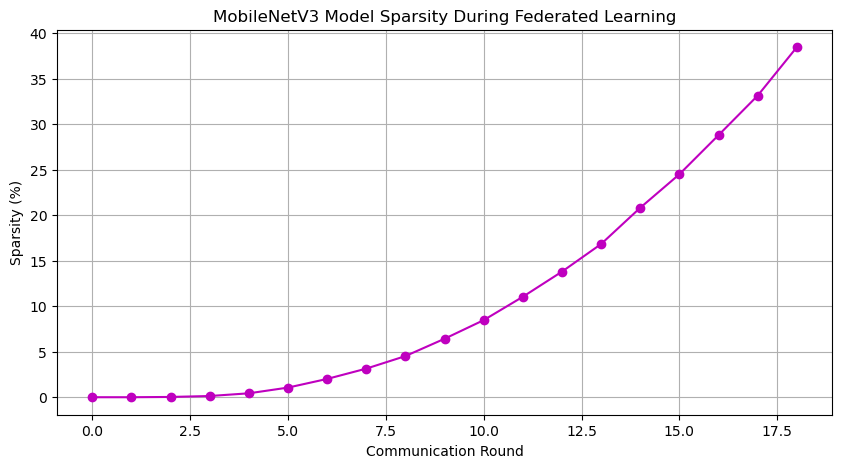

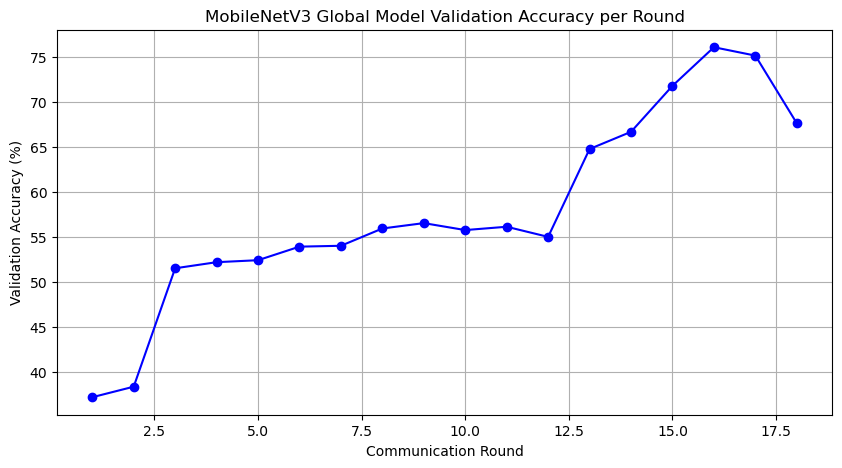

In [27]:
# Run federated learning with pruning for MobileNetV3
print("EXPERIMENT 3: FEDERATED LEARNING WITH PRUNING FOR MOBILENETV3")
mobilenet_federated_pruned_model, mobilenet_federated_pruning_metrics = run_federated_pruning_mobilenetv3()

## All Model Comparison

In [28]:
# Function to compare all models
def compare_all_mobilenetv3_models(models_dict, test_loader):
    """Compare different MobileNetV3 models on test data"""
    print(" Comparing All MobileNetV3 Models")

    results = {}
    for model_name, model in models_dict.items():
        # Ensure model is in evaluation mode
        model.eval()
        model = model.to(device)

        # Calculate model stats
        model_stats = print_model_stats(model, model_name)

        # Evaluate performance
        eval_results = evaluate_model(model, test_loader)

        # Record results
        results[model_name] = {
            'accuracy': eval_results['accuracy'],
            'loss': eval_results['loss'],
            'sparsity': model_stats['sparsity'],
            'total_params': model_stats['total_params'],
            'trainable_params': model_stats['trainable_params'],
            'zero_params': model_stats['zero_params'],
            'total_weights': model_stats['total_weights']
        }

        print(f"\n{model_name}:")
        print(f" Accuracy: {eval_results['accuracy']:.2f}%")
        print(f" Loss: {eval_results['loss']:.4f}")
        print(f" Sparsity: {model_stats['sparsity']:.2f}%")
        print(f" Model Size: {model_stats['total_params']:,} parameters")
        print(f" Zero Parameters: {model_stats['zero_params']:,} / {model_stats['total_weights']:,}")

    # Create comparison table
    print("MobileNetV3 Models Comparison Table")
    print("{:<30} {:<12} {:<12} {:<12} {:<20} {:<20}".format(
        'Model', 'Accuracy', 'Loss', 'Sparsity', 'Non-zero Params', 'Total Weights'))
    print("-" * 110)

    for model_name, stats in results.items():
        print("{:<30} {:<12.2f}% {:<12.4f} {:<12.2f}% {:<20,} {:<20,}".format(
            model_name,
            stats['accuracy'],
            stats['loss'],
            stats['sparsity'],
            stats['total_weights'] - stats['zero_params'],
            stats['total_weights']
        ))

    # Plot comparison charts
    plt.figure(figsize=(15, 10))

    # Accuracy comparison
    plt.subplot(2, 2, 1)
    accuracies = [stats['accuracy'] for _, stats in results.items()]
    plt.bar(results.keys(), accuracies, color=['blue', 'green', 'red', 'purple'])
    plt.title('Test Accuracy Comparison')
    plt.ylabel('Accuracy (%)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')

    # Sparsity comparison
    plt.subplot(2, 2, 2)
    sparsities = [stats['sparsity'] for _, stats in results.items()]
    plt.bar(results.keys(), sparsities, color=['blue', 'green', 'red', 'purple'])
    plt.title('Model Sparsity Comparison')
    plt.ylabel('Sparsity (%)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')

    # Parameter count comparison
    plt.subplot(2, 2, 3)
    non_zero_params = [stats['total_weights'] - stats['zero_params'] for _, stats in results.items()]
    plt.bar(results.keys(), non_zero_params, color=['blue', 'green', 'red', 'purple'])
    plt.title('Non-zero Parameters Comparison')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    # Loss comparison
    plt.subplot(2, 2, 4)
    losses = [stats['loss'] for _, stats in results.items()]
    plt.bar(results.keys(), losses, color=['blue', 'green', 'red', 'purple'])
    plt.title('Test Loss Comparison')
    plt.ylabel('Loss')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')

    plt.tight_layout()
    plt.show()

    return results

FINAL COMPARISON OF ALL MOBILENETV3 MODELS
 Comparing All MobileNetV3 Models
\MobileNetV3 Federated Learning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 0.00%
Zero parameters: 0 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M


Evaluating:   8%|▊         | 46/550 [00:01<00:10, 47.07it/s]

Evaluating: 100%|██████████| 550/550 [00:10<00:00, 51.52it/s]



MobileNetV3 Federated Learning:
 Accuracy: 80.65%
 Loss: 0.6412
 Sparsity: 0.00%
 Model Size: 4,877,398 parameters
 Zero Parameters: 0 / 4,858,288
\MobileNetV3 One-shot Pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 0.09%
Zero parameters: 4,307 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 46.47it/s]



MobileNetV3 One-shot Pruning:
 Accuracy: 99.90%
 Loss: 0.0035
 Sparsity: 0.09%
 Model Size: 4,877,398 parameters
 Zero Parameters: 4,307 / 4,858,288
\MobileNetV3 Federated Pruning Statistics
Total parameters: 4,877,398
Trainable parameters: 4,877,398
Global sparsity: 38.38%
Zero parameters: 1,864,626 / 4,858,288
Computational complexity: 220.72 MMac
Number of parameters: 4.88 M


Evaluating: 100%|██████████| 550/550 [00:11<00:00, 48.87it/s]



MobileNetV3 Federated Pruning:
 Accuracy: 77.19%
 Loss: 1.1908
 Sparsity: 38.38%
 Model Size: 4,877,398 parameters
 Zero Parameters: 1,864,626 / 4,858,288
MobileNetV3 Models Comparison Table
Model                          Accuracy     Loss         Sparsity     Non-zero Params      Total Weights       
--------------------------------------------------------------------------------------------------------------
MobileNetV3 Federated Learning 80.65       % 0.6412       0.00        % 4,858,288            4,858,288           
MobileNetV3 One-shot Pruning   99.90       % 0.0035       0.09        % 4,853,981            4,858,288           
MobileNetV3 Federated Pruning  77.19       % 1.1908       38.38       % 2,993,662            4,858,288           


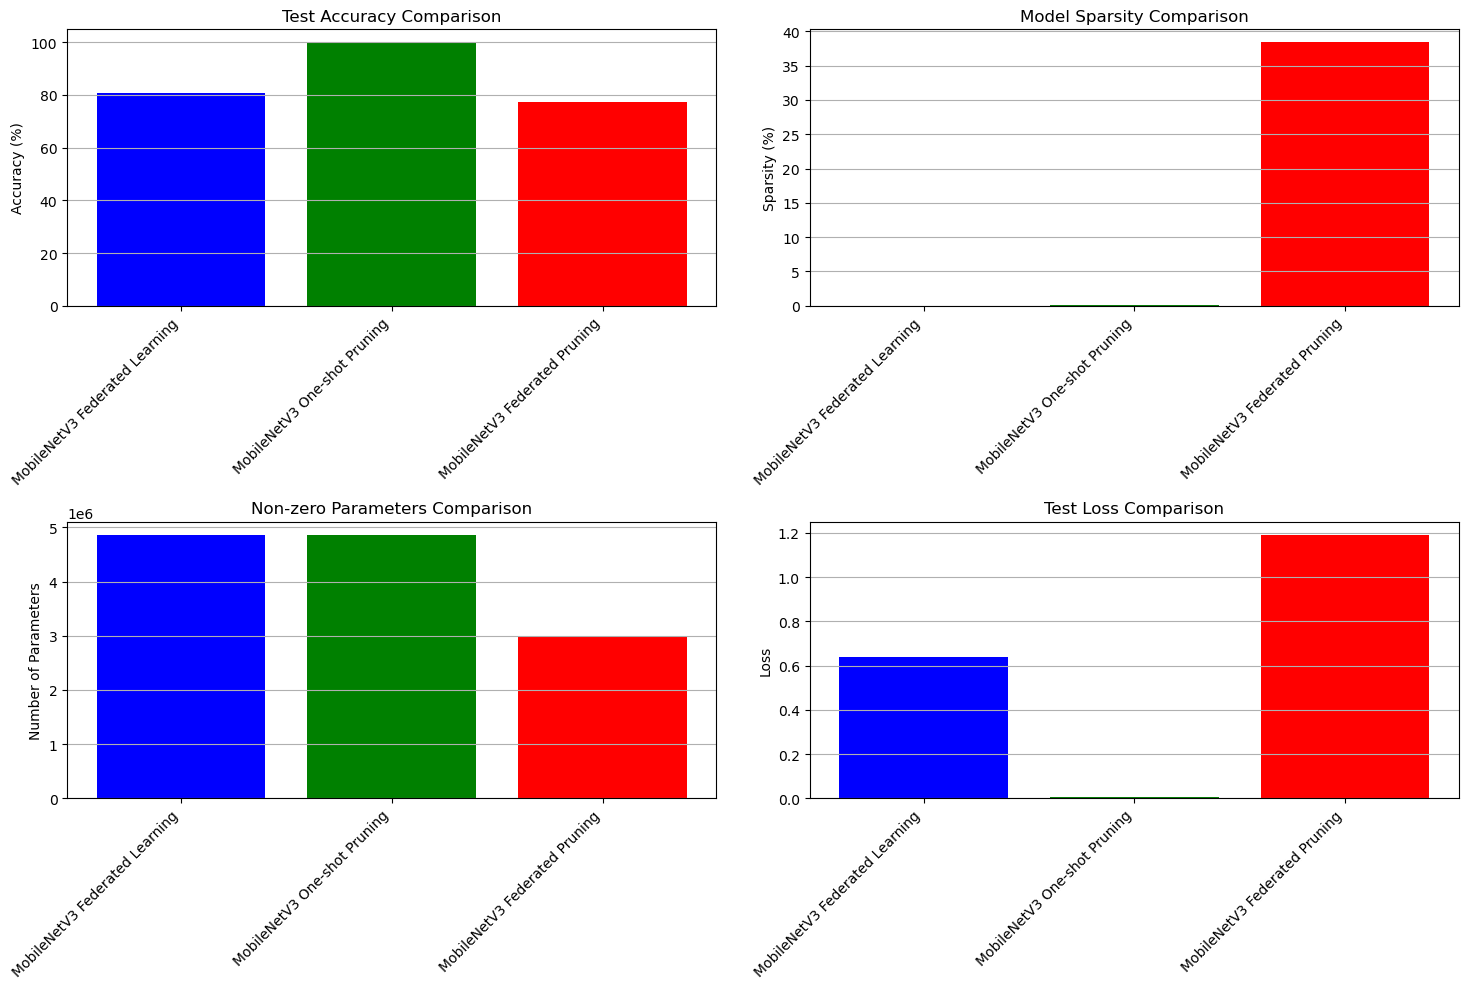

In [29]:
# Compare all models
print("FINAL COMPARISON OF ALL MOBILENETV3 MODELS")
all_mobilenet_models = {
    'MobileNetV3 Federated Learning': mobilenet_federated_model,
    'MobileNetV3 One-shot Pruning': mobilenet_oneshot_pruned_model,
    'MobileNetV3 Federated Pruning': mobilenet_federated_pruned_model
}
comparison_results = compare_all_mobilenetv3_models(all_mobilenet_models, val_loader)